In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'FreeHandV3'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(165000, 2, 128)
[2, 128]


In [11]:
model = neural_networks.freehand_v3(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 128, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 128, 16)        272       
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 128, 16)        64        
_________________________________________________________________
dense (Dense)                (None, 2, 128, 256)       4352      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 128, 32)        32800 

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/162 [..............................] - ETA: 36:51 - loss: 2.9034

  2/162 [..............................] - ETA: 10s - loss: 2.8442  

  3/162 [..............................] - ETA: 10s - loss: 2.8018

  4/162 [..............................] - ETA: 10s - loss: 2.7689

  5/162 [..............................] - ETA: 10s - loss: 2.7400

  6/162 [>.............................] - ETA: 10s - loss: 2.7156

  7/162 [>.............................] - ETA: 10s - loss: 2.6940

  8/162 [>.............................] - ETA: 10s - loss: 2.6738

  9/162 [>.............................] - ETA: 10s - loss: 2.6550

 10/162 [>.............................] - ETA: 9s - loss: 2.6380 

 11/162 [=>............................] - ETA: 9s - loss: 2.6221

 12/162 [=>............................] - ETA: 9s - loss: 2.6080

 13/162 [=>............................] - ETA: 9s - loss: 2.5946

 14/162 [=>............................] - ETA: 9s - loss: 2.5819

 15/162 [=>............................] - ETA: 9s - loss: 2.5699

 16/162 [=>............................] - ETA: 9s - loss: 2.5582

 17/162 [==>...........................] - ETA: 9s - loss: 2.5470

 18/162 [==>...........................] - ETA: 9s - loss: 2.5362

 19/162 [==>...........................] - ETA: 9s - loss: 2.5257

 20/162 [==>...........................] - ETA: 9s - loss: 2.5156

 21/162 [==>...........................] - ETA: 9s - loss: 2.5058

 22/162 [===>..........................] - ETA: 9s - loss: 2.4963

 23/162 [===>..........................] - ETA: 9s - loss: 2.4871

 24/162 [===>..........................] - ETA: 9s - loss: 2.4782

 25/162 [===>..........................] - ETA: 8s - loss: 2.4696

 26/162 [===>..........................] - ETA: 8s - loss: 2.4612

 27/162 [====>.........................] - ETA: 8s - loss: 2.4531

 28/162 [====>.........................] - ETA: 8s - loss: 2.4452



 29/162 [====>.........................] - ETA: 8s - loss: 2.4374



 30/162 [====>.........................] - ETA: 8s - loss: 2.4298

 31/162 [====>.........................] - ETA: 8s - loss: 2.4224

 32/162 [====>.........................] - ETA: 8s - loss: 2.4151

 33/162 [=====>........................] - ETA: 8s - loss: 2.4080

 34/162 [=====>........................] - ETA: 8s - loss: 2.4010

 35/162 [=====>........................] - ETA: 8s - loss: 2.3941

 36/162 [=====>........................] - ETA: 8s - loss: 2.3874

 37/162 [=====>........................] - ETA: 8s - loss: 2.3808

 38/162 [======>.......................] - ETA: 8s - loss: 2.3744

 39/162 [======>.......................] - ETA: 8s - loss: 2.3680

 40/162 [======>.......................] - ETA: 7s - loss: 2.3618

 41/162 [======>.......................] - ETA: 7s - loss: 2.3557

 42/162 [======>.......................] - ETA: 7s - loss: 2.3496

 43/162 [======>.......................] - ETA: 7s - loss: 2.3436

 44/162 [=======>......................] - ETA: 7s - loss: 2.3377

 45/162 [=======>......................] - ETA: 7s - loss: 2.3318

 46/162 [=======>......................] - ETA: 7s - loss: 2.3261

 47/162 [=======>......................] - ETA: 7s - loss: 2.3204

 48/162 [=======>......................] - ETA: 7s - loss: 2.3148

 49/162 [========>.....................] - ETA: 7s - loss: 2.3093

 50/162 [========>.....................] - ETA: 7s - loss: 2.3038

 51/162 [========>.....................] - ETA: 7s - loss: 2.2983

 52/162 [========>.....................] - ETA: 7s - loss: 2.2930

 53/162 [========>.....................]

 - ETA: 7s - loss: 2.2877

 54/162 [=========>....................] - ETA: 7s - loss: 2.2825

 55/162 [=========>....................] - ETA: 6s - loss: 2.2773

 56/162 [=========>....................] - ETA: 6s - loss: 2.2722

 57/162 [=========>....................] - ETA: 6s - loss: 2.2672

 58/162 [=========>....................] - ETA: 6s - loss: 2.2622

 59/162 [=========>....................] - ETA: 6s - loss: 2.2573

 60/162 [==========>...................] - ETA: 6s - loss: 2.2524

 61/162 [==========>...................] - ETA: 6s - loss: 2.2476

 62/162 [==========>...................] - ETA: 6s - loss: 2.2428

 63/162 [==========>...................] - ETA: 6s - loss: 2.2381

 64/162 [==========>...................] - ETA: 6s - loss: 2.2334

 65/162 [===========>..................] - ETA: 6s - loss: 2.2288

 66/162 [===========>..................] - ETA: 6s - loss: 2.2242

 67/162 [===========>..................] - ETA: 6s - loss: 2.2197

 68/162 [===========>..................] - ETA: 6s - loss: 2.2152

 69/162 [===========>..................] - ETA: 6s - loss: 2.2108

 70/162 [===========>..................] - ETA: 6s - loss: 2.2064



 71/162 [============>.................] - ETA: 5s - loss: 2.2020

 72/162 [============>.................] - ETA: 5s - loss: 2.1977

 73/162 [============>.................] - ETA: 5s - loss: 2.1935

 74/162 [============>.................] - ETA: 5s - loss: 2.1892

 75/162 [============>.................] - ETA: 5s - loss: 2.1851

 76/162 [=============>................] - ETA: 5s - loss: 2.1809

 77/162 [=============>................] - ETA: 5s - loss: 2.1768

 78/162 [=============>................] - ETA: 5s - loss: 2.1728

 79/162 [=============>................] - ETA: 5s - loss: 2.1688

 80/162 [=============>................] - ETA: 5s - loss: 2.1648

 81/162 [==============>...............] - ETA: 5s - loss: 2.1609

 82/162 [==============>...............] - ETA: 5s - loss: 2.1570

 83/162 [==============>...............] - ETA: 5s - loss: 2.1532

 84/162 [==============>...............] - ETA: 5s - loss: 2.1494

 85/162 [==============>...............] - ETA: 5s - loss: 2.1456

 86/162 [==============>...............] - ETA: 4s - loss: 2.1419

 87/162 [===============>..............] - ETA: 4s - loss: 2.1382

 88/162 [===============>..............] - ETA: 4s - loss: 2.1345

 89/162 [===============>..............] - ETA: 4s - loss: 2.1309

 90/162 [===============>..............] - ETA: 4s - loss: 2.1273

 91/162 [===============>..............] - ETA: 4s - loss: 2.1238

 92/162 [================>.............] - ETA: 4s - loss: 2.1203

 93/162 [================>.............]

 - ETA: 4s - loss: 2.1168

 94/162 [================>.............] - ETA: 4s - loss: 2.1133

 95/162 [================>.............] - ETA: 4s - loss: 2.1099

 96/162 [================>.............] - ETA: 4s - loss: 2.1065

 97/162 [================>.............] - ETA: 4s - loss: 2.1032

 98/162 [=================>............] - ETA: 4s - loss: 2.0999

 99/162 [=================>............] - ETA: 4s - loss: 2.0966

100/162 [=================>............] - ETA: 4s - loss: 2.0933

101/162 [=================>............] - ETA: 3s - loss: 2.0901

102/162 [=================>............] - ETA: 3s - loss: 2.0869

103/162 [==================>...........] - ETA: 3s - loss: 2.0837

104/162 [==================>...........] - ETA: 3s - loss: 2.0806

105/162 [==================>...........] - ETA: 3s - loss: 2.0775

106/162 [==================>...........] - ETA: 3s - loss: 2.0744

107/162 [==================>...........] - ETA: 3s - loss: 2.0713

108/162 [===================>..........] - ETA: 3s - loss: 2.0683

109/162 [===================>..........] - ETA: 3s - loss: 2.0653

110/162 [===================>..........] - ETA: 3s - loss: 2.0624



111/162 [===================>..........] - ETA: 3s - loss: 2.0594

112/162 [===================>..........] - ETA: 3s - loss: 2.0565

113/162 [===================>..........] - ETA: 3s - loss: 2.0536



114/162 [====================>.........] - ETA: 3s - loss: 2.0508

115/162 [====================>.........] - ETA: 3s - loss: 2.0479

116/162 [====================>.........] - ETA: 3s - loss: 2.0451

117/162 [====================>.........] - ETA: 2s - loss: 2.0423

118/162 [====================>.........] - ETA: 2s - loss: 2.0396

119/162 [=====================>........] - ETA: 2s - loss: 2.0368



120/162 [=====================>........] - ETA: 2s - loss: 2.0341

121/162 [=====================>........] - ETA: 2s - loss: 2.0315

122/162 [=====================>........] - ETA: 2s - loss: 2.0288

123/162 [=====================>........] - ETA: 2s - loss: 2.0262

124/162 [=====================>........] - ETA: 2s - loss: 2.0236

125/162 [======================>.......] - ETA: 2s - loss: 2.0210

126/162 [======================>.......] - ETA: 2s - loss: 2.0184

127/162 [======================>.......] - ETA: 2s - loss: 2.0159

128/162 [======================>.......] - ETA: 2s - loss: 2.0133

129/162 [======================>.......] - ETA: 2s - loss: 2.0108

130/162 [=======================>......] - ETA: 2s - loss: 2.0083

131/162 [=======================>......] - ETA: 2s - loss: 2.0059

132/162 [=======================>......] - ETA: 1s - loss: 2.0034

133/162 [=======================>......] - ETA: 1s - loss: 2.0010

134/162 [=======================>......] - ETA: 1s - loss: 1.9986

135/162 [========================>.....] - ETA: 1s - loss: 1.9962



136/162 [========================>.....] - ETA: 1s - loss: 1.9938



137/162 [========================>.....] - ETA: 1s - loss: 1.9915

138/162 [========================>.....] - ETA: 1s - loss: 1.9891

139/162 [========================>.....] - ETA: 1s - loss: 1.9868

140/162 [========================>.....] - ETA: 1s - loss: 1.9845

141/162 [=========================>....] - ETA: 1s - loss: 1.9822

142/162 [=========================>....] - ETA: 1s - loss: 1.9800

143/162 [=========================>....] - ETA: 1s - loss: 1.9777

144/162 [=========================>....] - ETA: 1s - loss: 1.9755

145/162 [=========================>....] - ETA: 1s - loss: 1.9733

146/162 [==========================>...] - ETA: 1s - loss: 1.9711

147/162 [==========================>...] - ETA: 0s - loss: 1.9689

148/162 [==========================>...] - ETA: 0s - loss: 1.9668

149/162 [==========================>...] - ETA: 0s - loss: 1.9646

150/162 [==========================>...] - ETA: 0s - loss: 1.9625

151/162 [==========================>...] - ETA: 0s - loss: 1.9604

152/162 [===========================>..] - ETA: 0s - loss: 1.9583

153/162 [===========================>..] - ETA: 0s - loss: 1.9562

154/162 [===========================>..] - ETA: 0s - loss: 1.9541

155/162 [===========================>..] - ETA: 0s - loss: 1.9521

156/162 [===========================>..] - ETA: 0s - loss: 1.9501

157/162 [============================>.] - ETA: 0s - loss: 1.9480

158/162 [============================>.] - ETA: 0s - loss: 1.9460

159/162 [============================>.] - ETA: 0s - loss: 1.9440

160/162 [============================>.] - ETA: 0s - loss: 1.9421

161/162 [============================>.] - ETA: 0s - loss: 1.9401

162/162 [==============================] - ETA: 0s - loss: 1.9381

162/162 [==============================] - 26s 78ms/step - loss: 1.9362 - val_loss: 5.9164


Epoch 2/100


  1/162 [..............................] - ETA: 10s - loss: 1.3204

  2/162 [..............................] - ETA: 10s - loss: 1.3066

  3/162 [..............................] - ETA: 10s - loss: 1.3100

  4/162 [..............................] - ETA: 10s - loss: 1.3149

  5/162 [..............................] - ETA: 10s - loss: 1.3203

  6/162 [>.............................] - ETA: 10s - loss: 1.3242

  7/162 [>.............................] - ETA: 10s - loss: 1.3272

  8/162 [>.............................] - ETA: 10s - loss: 1.3298

  9/162 [>.............................] - ETA: 10s - loss: 1.3311

 10/162 [>.............................] - ETA: 10s - loss: 1.3317

 11/162 [=>............................] - ETA: 9s - loss: 1.3324 

 12/162 [=>............................] - ETA: 9s - loss: 1.3330

 13/162 [=>............................] - ETA: 9s - loss: 1.3335

 14/162 [=>............................] - ETA: 9s - loss: 1.3340

 15/162 [=>............................] - ETA: 9s - loss: 1.3344

 16/162 [=>............................] - ETA: 9s - loss: 1.3346

 17/162 [==>...........................] - ETA: 9s - loss: 1.3347

 18/162 [==>...........................] - ETA: 9s - loss: 1.3348



 19/162 [==>...........................] - ETA: 9s - loss: 1.3349

 20/162 [==>...........................] - ETA: 9s - loss: 1.3351

 21/162 [==>...........................] - ETA: 9s - loss: 1.3353

 22/162 [===>..........................] - ETA: 9s - loss: 1.3353



 23/162 [===>..........................] - ETA: 9s - loss: 1.3353

 24/162 [===>..........................] - ETA: 9s - loss: 1.3352

 25/162 [===>..........................] - ETA: 9s - loss: 1.3352

 26/162 [===>..........................] - ETA: 8s - loss: 1.3351

 27/162 [====>.........................] - ETA: 8s - loss: 1.3350

 28/162 [====>.........................] - ETA: 8s - loss: 1.3350

 29/162 [====>.........................] - ETA: 8s - loss: 1.3350

 30/162 [====>.........................] - ETA: 8s - loss: 1.3350

 31/162 [====>.........................] - ETA: 8s - loss: 1.3351

 32/162 [====>.........................] - ETA: 8s - loss: 1.3351

 33/162 [=====>........................] - ETA: 8s - loss: 1.3352

 34/162 [=====>........................] - ETA: 8s - loss: 1.3352

 35/162 [=====>........................] - ETA: 8s - loss: 1.3353

 36/162 [=====>........................] - ETA: 8s - loss: 1.3354

 37/162 [=====>........................] - ETA: 8s - loss: 1.3354

 38/162 [======>.......................] - ETA: 8s - loss: 1.3354

 39/162 [======>.......................] - ETA: 8s - loss: 1.3354

 40/162 [======>.......................] - ETA: 8s - loss: 1.3355

 41/162 [======>.......................] - ETA: 7s - loss: 1.3355

 42/162 [======>.......................] - ETA: 7s - loss: 1.3355

 43/162 [======>.......................] - ETA: 7s - loss: 1.3355

 44/162 [=======>......................] - ETA: 7s - loss: 1.3355

 45/162 [=======>......................] - ETA: 7s - loss: 1.3356

 46/162 [=======>......................] - ETA: 7s - loss: 1.3356

 47/162 [=======>......................] - ETA: 7s - loss: 1.3355

 48/162 [=======>......................] - ETA: 7s - loss: 1.3355

 49/162 [========>.....................] - ETA: 7s - loss: 1.3355

 50/162 [========>.....................] - ETA: 7s - loss: 1.3354

 51/162 [========>.....................] - ETA: 7s - loss: 1.3354

 52/162 [========>.....................] - ETA: 7s - loss: 1.3354

 53/162 [========>.....................] - ETA: 7s - loss: 1.3353

 54/162 [=========>....................] - ETA: 7s - loss: 1.3353

 55/162 [=========>....................] - ETA: 7s - loss: 1.3352

 56/162 [=========>....................] - ETA: 6s - loss: 1.3351

 57/162 [=========>....................] - ETA: 6s - loss: 1.3351

 58/162 [=========>....................] - ETA: 6s - loss: 1.3350

 59/162 [=========>....................] - ETA: 6s - loss: 1.3349

 60/162 [==========>...................] - ETA: 6s - loss: 1.3348

 61/162 [==========>...................] - ETA: 6s - loss: 1.3347

 62/162 [==========>...................] - ETA: 6s - loss: 1.3346

 63/162 [==========>...................] - ETA: 6s - loss: 1.3345

 64/162 [==========>...................] - ETA: 6s - loss: 1.3344

 65/162 [===========>..................] - ETA: 6s - loss: 1.3343

 66/162 [===========>..................] - ETA: 6s - loss: 1.3342

 67/162 [===========>..................] - ETA: 6s - loss: 1.3340

 68/162 [===========>..................] - ETA: 6s - loss: 1.3339

 69/162 [===========>..................] - ETA: 6s - loss: 1.3338

 70/162 [===========>..................] - ETA: 6s - loss: 1.3337

 71/162 [============>.................] - ETA: 5s - loss: 1.3336

 72/162 [============>.................] - ETA: 5s - loss: 1.3334

 73/162 [============>.................] - ETA: 5s - loss: 1.3333

 74/162 [============>.................] - ETA: 5s - loss: 1.3332

 75/162 [============>.................] - ETA: 5s - loss: 1.3331

 76/162 [=============>................] - ETA: 5s - loss: 1.3329

 77/162 [=============>................] - ETA: 5s - loss: 1.3328

 78/162 [=============>................] - ETA: 5s - loss: 1.3327

 79/162 [=============>................] - ETA: 5s - loss: 1.3325

 80/162 [=============>................] - ETA: 5s - loss: 1.3324

 81/162 [==============>...............] - ETA: 5s - loss: 1.3323



 82/162 [==============>...............] - ETA: 5s - loss: 1.3322

 83/162 [==============>...............] - ETA: 5s - loss: 1.3321

 84/162 [==============>...............] - ETA: 5s - loss: 1.3319

 85/162 [==============>...............] - ETA: 5s - loss: 1.3318

 86/162 [==============>...............] - ETA: 4s - loss: 1.3317

 87/162 [===============>..............] - ETA: 4s - loss: 1.3316

 88/162 [===============>..............] - ETA: 4s - loss: 1.3315



 89/162 [===============>..............] - ETA: 4s - loss: 1.3314

 90/162 [===============>..............] - ETA: 4s - loss: 1.3313

 91/162 [===============>..............] - ETA: 4s - loss: 1.3311

 92/162 [================>.............] - ETA: 4s - loss: 1.3310

 93/162 [================>.............] - ETA: 4s - loss: 1.3309

 94/162 [================>.............] - ETA: 4s - loss: 1.3308

 95/162 [================>.............] - ETA: 4s - loss: 1.3306

 96/162 [================>.............] - ETA: 4s - loss: 1.3305



 97/162 [================>.............] - ETA: 4s - loss: 1.3304



 98/162 [=================>............] - ETA: 4s - loss: 1.3302

 99/162 [=================>............] - ETA: 4s - loss: 1.3301

100/162 [=================>............] - ETA: 4s - loss: 1.3299

101/162 [=================>............] - ETA: 4s - loss: 1.3298

102/162 [=================>............] - ETA: 3s - loss: 1.3296

103/162 [==================>...........] - ETA: 3s - loss: 1.3295

104/162 [==================>...........] - ETA: 3s - loss: 1.3293

105/162 [==================>...........] - ETA: 3s - loss: 1.3292

106/162 [==================>...........] - ETA: 3s - loss: 1.3290

107/162 [==================>...........] - ETA: 3s - loss: 1.3289

108/162 [===================>..........] - ETA: 3s - loss: 1.3288

109/162 [===================>..........] - ETA: 3s - loss: 1.3286

110/162 [===================>..........] - ETA: 3s - loss: 1.3285

111/162 [===================>..........] - ETA: 3s - loss: 1.3283

112/162 [===================>..........] - ETA: 3s - loss: 1.3282

113/162 [===================>..........] - ETA: 3s - loss: 1.3280

114/162 [====================>.........] - ETA: 3s - loss: 1.3279

115/162 [====================>.........] - ETA: 3s - loss: 1.3278

116/162 [====================>.........] - ETA: 3s - loss: 1.3276

117/162 [====================>.........] - ETA: 2s - loss: 1.3275

118/162 [====================>.........] - ETA: 2s - loss: 1.3274

119/162 [=====================>........] - ETA: 2s - loss: 1.3272

120/162 [=====================>........] - ETA: 2s - loss: 1.3271

121/162 [=====================>........] - ETA: 2s - loss: 1.3270

122/162 [=====================>........] - ETA: 2s - loss: 1.3268

123/162 [=====================>........] - ETA: 2s - loss: 1.3267

124/162 [=====================>........] - ETA: 2s - loss: 1.3265

125/162 [======================>.......] - ETA: 2s - loss: 1.3264

126/162 [======================>.......] - ETA: 2s - loss: 1.3263

127/162 [======================>.......] - ETA: 2s - loss: 1.3261

128/162 [======================>.......] - ETA: 2s - loss: 1.3260

129/162 [======================>.......] - ETA: 2s - loss: 1.3258

130/162 [=======================>......] - ETA: 2s - loss: 1.3257

131/162 [=======================>......] - ETA: 2s - loss: 1.3256

132/162 [=======================>......] - ETA: 1s - loss: 1.3254

133/162 [=======================>......] - ETA: 1s - loss: 1.3253

134/162 [=======================>......] - ETA: 1s - loss: 1.3252

135/162 [========================>.....] - ETA: 1s - loss: 1.3250

136/162 [========================>.....] - ETA: 1s - loss: 1.3249

137/162 [========================>.....] - ETA: 1s - loss: 1.3248

138/162 [========================>.....] - ETA: 1s - loss: 1.3246

139/162 [========================>.....] - ETA: 1s - loss: 1.3245

140/162 [========================>.....] - ETA: 1s - loss: 1.3243



141/162 [=========================>....] - ETA: 1s - loss: 1.3242



142/162 [=========================>....] - ETA: 1s - loss: 1.3241

143/162 [=========================>....] - ETA: 1s - loss: 1.3239

144/162 [=========================>....] - ETA: 1s - loss: 1.3238

145/162 [=========================>....] - ETA: 1s - loss: 1.3237

146/162 [==========================>...] - ETA: 1s - loss: 1.3235

147/162 [==========================>...] - ETA: 0s - loss: 1.3234

148/162 [==========================>...] - ETA: 0s - loss: 1.3233

149/162 [==========================>...] - ETA: 0s - loss: 1.3231

150/162 [==========================>...] - ETA: 0s - loss: 1.3230

151/162 [==========================>...] - ETA: 0s - loss: 1.3229

152/162 [===========================>..] - ETA: 0s - loss: 1.3227

153/162 [===========================>..] - ETA: 0s - loss: 1.3226

154/162 [===========================>..] - ETA: 0s - loss: 1.3225

155/162 [===========================>..] - ETA: 0s - loss: 1.3224

156/162 [===========================>..] - ETA: 0s - loss: 1.3222

157/162 [============================>.] - ETA: 0s - loss: 1.3221

158/162 [============================>.] - ETA: 0s - loss: 1.3220

159/162 [============================>.] - ETA: 0s - loss: 1.3219

160/162 [============================>.] - ETA: 0s - loss: 1.3217

161/162 [============================>.] - ETA: 0s - loss: 1.3216

162/162 [==============================] - 12s 73ms/step - loss: 1.3213 - val_loss: 5.9999


Epoch 3/100
  1/162 [..............................] - ETA: 10s - loss: 1.2896

  2/162 [..............................] - ETA: 10s - loss: 1.2738

  3/162 [..............................] - ETA: 10s - loss: 1.2704

  4/162 [..............................] - ETA: 10s - loss: 1.2714



  5/162 [..............................] - ETA: 10s - loss: 1.2712



  6/162 [>.............................] - ETA: 10s - loss: 1.2701



  7/162 [>.............................] - ETA: 10s - loss: 1.2691



  8/162 [>.............................] - ETA: 10s - loss: 1.2679



  9/162 [>.............................] - ETA: 10s - loss: 1.2676



 10/162 [>.............................] - ETA: 9s - loss: 1.2669 

 11/162 [=>............................] - ETA: 9s - loss: 1.2664

 12/162 [=>............................] - ETA: 9s - loss: 1.2663

 13/162 [=>............................] - ETA: 9s - loss: 1.2658

 14/162 [=>............................] - ETA: 9s - loss: 1.2653

 15/162 [=>............................] - ETA: 9s - loss: 1.2649

 16/162 [=>............................] - ETA: 9s - loss: 1.2646



 17/162 [==>...........................] - ETA: 9s - loss: 1.2642

 18/162 [==>...........................] - ETA: 9s - loss: 1.2638



 19/162 [==>...........................] - ETA: 9s - loss: 1.2633



 20/162 [==>...........................] - ETA: 9s - loss: 1.2629



 21/162 [==>...........................] - ETA: 9s - loss: 1.2626



 22/162 [===>..........................] - ETA: 9s - loss: 1.2622

 23/162 [===>..........................] - ETA: 9s - loss: 1.2619

 24/162 [===>..........................] - ETA: 9s - loss: 1.2615



 25/162 [===>..........................] - ETA: 8s - loss: 1.2612

 26/162 [===>..........................]

 - ETA: 8s - loss: 1.2609



 27/162 [====>.........................] - ETA: 8s - loss: 1.2606



 28/162 [====>.........................] - ETA: 8s - loss: 1.2603

 29/162 [====>.........................] - ETA: 8s - loss: 1.2601

 30/162 [====>.........................] - ETA: 8s - loss: 1.2598

 31/162 [====>.........................] - ETA: 8s - loss: 1.2596



 32/162 [====>.........................] - ETA: 8s - loss: 1.2594



 33/162 [=====>........................] - ETA: 8s - loss: 1.2591

 34/162 [=====>........................] - ETA: 8s - loss: 1.2589

 35/162 [=====>........................] - ETA: 8s - loss: 1.2587

 36/162 [=====>........................] - ETA: 8s - loss: 1.2586

 37/162 [=====>........................] - ETA: 8s - loss: 1.2584

 38/162 [======>.......................] - ETA: 8s - loss: 1.2582

 39/162 [======>.......................] - ETA: 8s - loss: 1.2581

 40/162 [======>.......................] - ETA: 7s - loss: 1.2579

 41/162 [======>.......................] - ETA: 7s - loss: 1.2578

 42/162 [======>.......................] - ETA: 7s - loss: 1.2576

 43/162 [======>.......................] - ETA: 7s - loss: 1.2575

 44/162 [=======>......................] - ETA: 7s - loss: 1.2573

 45/162 [=======>......................] - ETA: 7s - loss: 1.2571

 46/162 [=======>......................] - ETA: 7s - loss: 1.2570

 47/162 [=======>......................] - ETA: 7s - loss: 1.2568

 48/162 [=======>......................] - ETA: 7s - loss: 1.2566

 49/162 [========>.....................] - ETA: 7s - loss: 1.2564

 50/162 [========>.....................] - ETA: 7s - loss: 1.2563

 51/162 [========>.....................] - ETA: 7s - loss: 1.2561

 52/162 [========>.....................] - ETA: 7s - loss: 1.2559

 53/162 [========>.....................] - ETA: 7s - loss: 1.2557

 54/162 [=========>....................] - ETA: 7s - loss: 1.2555

 55/162 [=========>....................] - ETA: 7s - loss: 1.2554

 56/162 [=========>....................] - ETA: 6s - loss: 1.2552

 57/162 [=========>....................] - ETA: 6s - loss: 1.2550

 58/162 [=========>....................] - ETA: 6s - loss: 1.2549

 59/162 [=========>....................] - ETA: 6s - loss: 1.2547

 60/162 [==========>...................] - ETA: 6s - loss: 1.2546

 61/162 [==========>...................] - ETA: 6s - loss: 1.2545

 62/162 [==========>...................] - ETA: 6s - loss: 1.2544

 63/162 [==========>...................] - ETA: 6s - loss: 1.2542

 64/162 [==========>...................] - ETA: 6s - loss: 1.2541

 65/162 [===========>..................] - ETA: 6s - loss: 1.2540

 66/162 [===========>..................] - ETA: 6s - loss: 1.2539

 67/162 [===========>..................] - ETA: 6s - loss: 1.2538

 68/162 [===========>..................] - ETA: 6s - loss: 1.2537

 69/162 [===========>..................] - ETA: 6s - loss: 1.2536

 70/162 [===========>..................] - ETA: 6s - loss: 1.2535

 71/162 [============>.................] - ETA: 5s - loss: 1.2534



 72/162 [============>.................] - ETA: 5s - loss: 1.2534

 73/162 [============>.................] - ETA: 5s - loss: 1.2533

 74/162 [============>.................] - ETA: 5s - loss: 1.2532

 75/162 [============>.................] - ETA: 5s - loss: 1.2531

 76/162 [=============>................] - ETA: 5s - loss: 1.2530

 77/162 [=============>................] - ETA: 5s - loss: 1.2529

 78/162 [=============>................] - ETA: 5s - loss: 1.2529

 79/162 [=============>................] - ETA: 5s - loss: 1.2528

 80/162 [=============>................] - ETA: 5s - loss: 1.2527

 81/162 [==============>...............] - ETA: 5s - loss: 1.2526

 82/162 [==============>...............] - ETA: 5s - loss: 1.2526

 83/162 [==============>...............] - ETA: 5s - loss: 1.2525

 84/162 [==============>...............] - ETA: 5s - loss: 1.2524

 85/162 [==============>...............] - ETA: 5s - loss: 1.2523

 86/162 [==============>...............] - ETA: 4s - loss: 1.2522

 87/162 [===============>..............] - ETA: 4s - loss: 1.2522

 88/162 [===============>..............] - ETA: 4s - loss: 1.2521



 89/162 [===============>..............] - ETA: 4s - loss: 1.2520

 90/162 [===============>..............] - ETA: 4s - loss: 1.2519

 91/162 [===============>..............] - ETA: 4s - loss: 1.2518

 92/162 [================>.............] - ETA: 4s - loss: 1.2517

 93/162 [================>.............] - ETA: 4s - loss: 1.2517

 94/162 [================>.............] - ETA: 4s - loss: 1.2516

 95/162 [================>.............] - ETA: 4s - loss: 1.2515

 96/162 [================>.............] - ETA: 4s - loss: 1.2514

 97/162 [================>.............] - ETA: 4s - loss: 1.2513

 98/162 [=================>............] - ETA: 4s - loss: 1.2513



 99/162 [=================>............] - ETA: 4s - loss: 1.2512

100/162 [=================>............] - ETA: 4s - loss: 1.2511

101/162 [=================>............] - ETA: 3s - loss: 1.2510

102/162 [=================>............] - ETA: 3s - loss: 1.2510

103/162 [==================>...........]

 - ETA: 3s - loss: 1.2509

104/162 [==================>...........] - ETA: 3s - loss: 1.2508

105/162 [==================>...........] - ETA: 3s - loss: 1.2508

106/162 [==================>...........] - ETA: 3s - loss: 1.2507

107/162 [==================>...........] - ETA: 3s - loss: 1.2506

108/162 [===================>..........] - ETA: 3s - loss: 1.2505

109/162 [===================>..........] - ETA: 3s - loss: 1.2505

110/162 [===================>..........] - ETA: 3s - loss: 1.2504

111/162 [===================>..........] - ETA: 3s - loss: 1.2503

112/162 [===================>..........] - ETA: 3s - loss: 1.2502

113/162 [===================>..........] - ETA: 3s - loss: 1.2502

114/162 [====================>.........] - ETA: 3s - loss: 1.2501

115/162 [====================>.........] - ETA: 3s - loss: 1.2500

116/162 [====================>.........] - ETA: 3s - loss: 1.2500

117/162 [====================>.........] - ETA: 2s - loss: 1.2499

118/162 [====================>.........] - ETA: 2s - loss: 1.2499

119/162 [=====================>........] - ETA: 2s - loss: 1.2498

120/162 [=====================>........] - ETA: 2s - loss: 1.2497

121/162 [=====================>........] - ETA: 2s - loss: 1.2497

122/162 [=====================>........] - ETA: 2s - loss: 1.2496

123/162 [=====================>........] - ETA: 2s - loss: 1.2495

124/162 [=====================>........] - ETA: 2s - loss: 1.2495

125/162 [======================>.......] - ETA: 2s - loss: 1.2494

126/162 [======================>.......] - ETA: 2s - loss: 1.2494

127/162 [======================>.......] - ETA: 2s - loss: 1.2493

128/162 [======================>.......] - ETA: 2s - loss: 1.2492

129/162 [======================>.......] - ETA: 2s - loss: 1.2492

130/162 [=======================>......] - ETA: 2s - loss: 1.2491

131/162 [=======================>......] - ETA: 2s - loss: 1.2490

132/162 [=======================>......] - ETA: 1s - loss: 1.2490

133/162 [=======================>......] - ETA: 1s - loss: 1.2489

134/162 [=======================>......] - ETA: 1s - loss: 1.2488

135/162 [========================>.....] - ETA: 1s - loss: 1.2488

136/162 [========================>.....] - ETA: 1s - loss: 1.2487

137/162 [========================>.....] - ETA: 1s - loss: 1.2487

138/162 [========================>.....] - ETA: 1s - loss: 1.2486

139/162 [========================>.....] - ETA: 1s - loss: 1.2485

140/162 [========================>.....] - ETA: 1s - loss: 1.2485

141/162 [=========================>....] - ETA: 1s - loss: 1.2484

142/162 [=========================>....] - ETA: 1s - loss: 1.2484

143/162 [=========================>....] - ETA: 1s - loss: 1.2483

144/162 [=========================>....] - ETA: 1s - loss: 1.2483

145/162 [=========================>....] - ETA: 1s - loss: 1.2482

146/162 [==========================>...] - ETA: 1s - loss: 1.2482

147/162 [==========================>...] - ETA: 0s - loss: 1.2481

148/162 [==========================>...] - ETA: 0s - loss: 1.2481

149/162 [==========================>...] - ETA: 0s - loss: 1.2480

150/162 [==========================>...]

 - ETA: 0s - loss: 1.2480

151/162 [==========================>...] - ETA: 0s - loss: 1.2479

152/162 [===========================>..] - ETA: 0s - loss: 1.2478

153/162 [===========================>..] - ETA: 0s - loss: 1.2478

154/162 [===========================>..] - ETA: 0s - loss: 1.2477

155/162 [===========================>..] - ETA: 0s - loss: 1.2477

156/162 [===========================>..] - ETA: 0s - loss: 1.2476

157/162 [============================>.] - ETA: 0s - loss: 1.2476

158/162 [============================>.] - ETA: 0s - loss: 1.2475

159/162 [============================>.] - ETA: 0s - loss: 1.2475

160/162 [============================>.] - ETA: 0s - loss: 1.2474

161/162 [============================>.] - ETA: 0s - loss: 1.2474

162/162 [==============================] - 12s 72ms/step - loss: 1.2473 - val_loss: 6.0931


Epoch 4/100
  1/162 [..............................] - ETA: 10s - loss: 1.2698

  2/162 [..............................] - ETA: 10s - loss: 1.2618

  3/162 [..............................] - ETA: 10s - loss: 1.2661

  4/162 [..............................] - ETA: 10s - loss: 1.2628

  5/162 [..............................] - ETA: 10s - loss: 1.2574

  6/162 [>.............................] - ETA: 10s - loss: 1.2545

  7/162 [>.............................] - ETA: 10s - loss: 1.2516

  8/162 [>.............................] - ETA: 10s - loss: 1.2499

  9/162 [>.............................] - ETA: 10s - loss: 1.2482

 10/162 [>.............................] - ETA: 9s - loss: 1.2471 

 11/162 [=>............................] - ETA: 9s - loss: 1.2459

 12/162 [=>............................] - ETA: 9s - loss: 1.2450

 13/162 [=>............................] - ETA: 9s - loss: 1.2440

 14/162 [=>............................] - ETA: 9s - loss: 1.2430

 15/162 [=>............................] - ETA: 9s - loss: 1.2421

 16/162 [=>............................] - ETA: 9s - loss: 1.2412

 17/162 [==>...........................] - ETA: 9s - loss: 1.2403

 18/162 [==>...........................] - ETA: 9s - loss: 1.2395

 19/162 [==>...........................] - ETA: 9s - loss: 1.2388

 20/162 [==>...........................] - ETA: 9s - loss: 1.2381

 21/162 [==>...........................] - ETA: 9s - loss: 1.2375

 22/162 [===>..........................] - ETA: 9s - loss: 1.2369



 23/162 [===>..........................] - ETA: 9s - loss: 1.2364

 24/162 [===>..........................] - ETA: 9s - loss: 1.2359

 25/162 [===>..........................] - ETA: 8s - loss: 1.2356

 26/162 [===>..........................] - ETA: 8s - loss: 1.2353

 27/162 [====>.........................] - ETA: 8s - loss: 1.2349

 28/162 [====>.........................] - ETA: 8s - loss: 1.2346

 29/162 [====>.........................] - ETA: 8s - loss: 1.2344

 30/162 [====>.........................] - ETA: 8s - loss: 1.2341

 31/162 [====>.........................] - ETA: 8s - loss: 1.2339

 32/162 [====>.........................] - ETA: 8s - loss: 1.2335

 33/162 [=====>........................]

 - ETA: 8s - loss: 1.2333

 34/162 [=====>........................] - ETA: 8s - loss: 1.2330

 35/162 [=====>........................] - ETA: 8s - loss: 1.2327

 36/162 [=====>........................] - ETA: 8s - loss: 1.2324

 37/162 [=====>........................] - ETA: 8s - loss: 1.2321



 38/162 [======>.......................] - ETA: 8s - loss: 1.2318



 39/162 [======>.......................] - ETA: 8s - loss: 1.2315

 40/162 [======>.......................] - ETA: 7s - loss: 1.2312

 41/162 [======>.......................] - ETA: 7s - loss: 1.2309

 42/162 [======>.......................] - ETA: 7s - loss: 1.2307

 43/162 [======>.......................] - ETA: 7s - loss: 1.2304

 44/162 [=======>......................] - ETA: 7s - loss: 1.2301

 45/162 [=======>......................] - ETA: 7s - loss: 1.2298

 46/162 [=======>......................] - ETA: 7s - loss: 1.2296

 47/162 [=======>......................] - ETA: 7s - loss: 1.2293

 48/162 [=======>......................] - ETA: 7s - loss: 1.2291



 49/162 [========>.....................] - ETA: 7s - loss: 1.2289



 50/162 [========>.....................] - ETA: 7s - loss: 1.2287



 51/162 [========>.....................] - ETA: 7s - loss: 1.2284

 52/162 [========>.....................] - ETA: 7s - loss: 1.2282



 53/162 [========>.....................] - ETA: 7s - loss: 1.2280

 54/162 [=========>....................] - ETA: 7s - loss: 1.2278

 55/162 [=========>....................] - ETA: 7s - loss: 1.2276



 56/162 [=========>....................] - ETA: 6s - loss: 1.2274

 57/162 [=========>....................] - ETA: 6s - loss: 1.2273



 58/162 [=========>....................] - ETA: 6s - loss: 1.2271



 59/162 [=========>....................] - ETA: 6s - loss: 1.2269



 60/162 [==========>...................] - ETA: 6s - loss: 1.2268



 61/162 [==========>...................] - ETA: 6s - loss: 1.2266



 62/162 [==========>...................] - ETA: 6s - loss: 1.2265

 63/162 [==========>...................] - ETA: 6s - loss: 1.2264

 64/162 [==========>...................] - ETA: 6s - loss: 1.2262

 65/162 [===========>..................] - ETA: 6s - loss: 1.2261

 66/162 [===========>..................] - ETA: 6s - loss: 1.2260

 67/162 [===========>..................] - ETA: 6s - loss: 1.2259

 68/162 [===========>..................] - ETA: 6s - loss: 1.2258



 69/162 [===========>..................] - ETA: 6s - loss: 1.2257

 70/162 [===========>..................] - ETA: 6s - loss: 1.2256

 71/162 [============>.................] - ETA: 5s - loss: 1.2255

 72/162 [============>.................] - ETA: 5s - loss: 1.2253

 73/162 [============>.................] - ETA: 5s - loss: 1.2252

 74/162 [============>.................] - ETA: 5s - loss: 1.2251

 75/162 [============>.................] - ETA: 5s - loss: 1.2250

 76/162 [=============>................] - ETA: 5s - loss: 1.2248

 77/162 [=============>................] - ETA: 5s - loss: 1.2247

 78/162 [=============>................] - ETA: 5s - loss: 1.2246



 79/162 [=============>................] - ETA: 5s - loss: 1.2245

 80/162 [=============>................] - ETA: 5s - loss: 1.2244

 81/162 [==============>...............] - ETA: 5s - loss: 1.2242

 82/162 [==============>...............] - ETA: 5s - loss: 1.2241

 83/162 [==============>...............] - ETA: 5s - loss: 1.2240

 84/162 [==============>...............] - ETA: 5s - loss: 1.2239

 85/162 [==============>...............] - ETA: 5s - loss: 1.2238

 86/162 [==============>...............] - ETA: 4s - loss: 1.2236

 87/162 [===============>..............] - ETA: 4s - loss: 1.2235

 88/162 [===============>..............] - ETA: 4s - loss: 1.2234

 89/162 [===============>..............] - ETA: 4s - loss: 1.2233

 90/162 [===============>..............] - ETA: 4s - loss: 1.2232

 91/162 [===============>..............] - ETA: 4s - loss: 1.2231

 92/162 [================>.............] - ETA: 4s - loss: 1.2230

 93/162 [================>.............] - ETA: 4s - loss: 1.2229



 94/162 [================>.............] - ETA: 4s - loss: 1.2228

 95/162 [================>.............] - ETA: 4s - loss: 1.2227

 96/162 [================>.............] - ETA: 4s - loss: 1.2226



 97/162 [================>.............] - ETA: 4s - loss: 1.2225



 98/162 [=================>............] - ETA: 4s - loss: 1.2224

 99/162 [=================>............] - ETA: 4s - loss: 1.2224

100/162 [=================>............] - ETA: 4s - loss: 1.2223

101/162 [=================>............] - ETA: 3s - loss: 1.2222

102/162 [=================>............] - ETA: 3s - loss: 1.2221

103/162 [==================>...........] - ETA: 3s - loss: 1.2220

104/162 [==================>...........] - ETA: 3s - loss: 1.2220

105/162 [==================>...........] - ETA: 3s - loss: 1.2219

106/162 [==================>...........] - ETA: 3s - loss: 1.2218



107/162 [==================>...........] - ETA: 3s - loss: 1.2218

108/162 [===================>..........] - ETA: 3s - loss: 1.2217

109/162 [===================>..........] - ETA: 3s - loss: 1.2217

110/162 [===================>..........] - ETA: 3s - loss: 1.2216

111/162 [===================>..........] - ETA: 3s - loss: 1.2215

112/162 [===================>..........] - ETA: 3s - loss: 1.2215

113/162 [===================>..........] - ETA: 3s - loss: 1.2214

114/162 [====================>.........] - ETA: 3s - loss: 1.2213

115/162 [====================>.........] - ETA: 3s - loss: 1.2213

116/162 [====================>.........] - ETA: 3s - loss: 1.2212

117/162 [====================>.........] - ETA: 2s - loss: 1.2211

118/162 [====================>.........] - ETA: 2s - loss: 1.2211

119/162 [=====================>........] - ETA: 2s - loss: 1.2210

120/162 [=====================>........] - ETA: 2s - loss: 1.2209

121/162 [=====================>........] - ETA: 2s - loss: 1.2209

122/162 [=====================>........] - ETA: 2s - loss: 1.2208

123/162 [=====================>........] - ETA: 2s - loss: 1.2207



124/162 [=====================>........] - ETA: 2s - loss: 1.2207

125/162 [======================>.......] - ETA: 2s - loss: 1.2206

126/162 [======================>.......] - ETA: 2s - loss: 1.2206

127/162 [======================>.......] - ETA: 2s - loss: 1.2205

128/162 [======================>.......] - ETA: 2s - loss: 1.2205

129/162 [======================>.......] - ETA: 2s - loss: 1.2204

130/162 [=======================>......] - ETA: 2s - loss: 1.2203

131/162 [=======================>......] - ETA: 2s - loss: 1.2203

132/162 [=======================>......] - ETA: 1s - loss: 1.2202

133/162 [=======================>......] - ETA: 1s - loss: 1.2202

134/162 [=======================>......] - ETA: 1s - loss: 1.2201

135/162 [========================>.....] - ETA: 1s - loss: 1.2200

136/162 [========================>.....] - ETA: 1s - loss: 1.2200

137/162 [========================>.....] - ETA: 1s - loss: 1.2199

138/162 [========================>.....] - ETA: 1s - loss: 1.2199

139/162 [========================>.....] - ETA: 1s - loss: 1.2198

140/162 [========================>.....] - ETA: 1s - loss: 1.2198

141/162 [=========================>....] - ETA: 1s - loss: 1.2197

142/162 [=========================>....] - ETA: 1s - loss: 1.2196

143/162 [=========================>....] - ETA: 1s - loss: 1.2196



144/162 [=========================>....] - ETA: 1s - loss: 1.2195

145/162 [=========================>....] - ETA: 1s - loss: 1.2195

146/162 [==========================>...] - ETA: 1s - loss: 1.2194

147/162 [==========================>...] - ETA: 0s - loss: 1.2194

148/162 [==========================>...] - ETA: 0s - loss: 1.2193

149/162 [==========================>...] - ETA: 0s - loss: 1.2192

150/162 [==========================>...] - ETA: 0s - loss: 1.2192

151/162 [==========================>...] - ETA: 0s - loss: 1.2191

152/162 [===========================>..] - ETA: 0s - loss: 1.2191

153/162 [===========================>..] - ETA: 0s - loss: 1.2190

154/162 [===========================>..] - ETA: 0s - loss: 1.2190

155/162 [===========================>..] - ETA: 0s - loss: 1.2189

156/162 [===========================>..] - ETA: 0s - loss: 1.2189



157/162 [============================>.] - ETA: 0s - loss: 1.2188



158/162 [============================>.] - ETA: 0s - loss: 1.2187

159/162 [============================>.] - ETA: 0s - loss: 1.2187

160/162 [============================>.] - ETA: 0s - loss: 1.2186

161/162 [============================>.] - ETA: 0s - loss: 1.2186

162/162 [==============================] - 12s 73ms/step - loss: 1.2185 - val_loss: 5.1077


Epoch 5/100


  1/162 [..............................] - ETA: 10s - loss: 1.1885

  2/162 [..............................] - ETA: 10s - loss: 1.2074

  3/162 [..............................] - ETA: 10s - loss: 1.2138

  4/162 [..............................] - ETA: 10s - loss: 1.2170

  5/162 [..............................] - ETA: 10s - loss: 1.2179

  6/162 [>.............................] - ETA: 10s - loss: 1.2178

  7/162 [>.............................] - ETA: 10s - loss: 1.2173

  8/162 [>.............................] - ETA: 10s - loss: 1.2164

  9/162 [>.............................] - ETA: 10s - loss: 1.2155

 10/162 [>.............................] - ETA: 9s - loss: 1.2155 

 11/162 [=>............................] - ETA: 9s - loss: 1.2153

 12/162 [=>............................] - ETA: 9s - loss: 1.2147

 13/162 [=>............................] - ETA: 9s - loss: 1.2140

 14/162 [=>............................] - ETA: 9s - loss: 1.2134

 15/162 [=>............................] - ETA: 9s - loss: 1.2127

 16/162 [=>............................] - ETA: 9s - loss: 1.2120

 17/162 [==>...........................] - ETA: 9s - loss: 1.2113

 18/162 [==>...........................] - ETA: 9s - loss: 1.2107

 19/162 [==>...........................] - ETA: 9s - loss: 1.2102

 20/162 [==>...........................] - ETA: 9s - loss: 1.2096

 21/162 [==>...........................] - ETA: 9s - loss: 1.2091

 22/162 [===>..........................] - ETA: 9s - loss: 1.2086

 23/162 [===>..........................] - ETA: 9s - loss: 1.2081

 24/162 [===>..........................] - ETA: 9s - loss: 1.2077

 25/162 [===>..........................] - ETA: 9s - loss: 1.2073

 26/162 [===>..........................] - ETA: 8s - loss: 1.2068

 27/162 [====>.........................] - ETA: 8s - loss: 1.2064

 28/162 [====>.........................] - ETA: 8s - loss: 1.2059

 29/162 [====>.........................] - ETA: 8s - loss: 1.2055

 30/162 [====>.........................] - ETA: 8s - loss: 1.2050

 31/162 [====>.........................] - ETA: 8s - loss: 1.2046

 32/162 [====>.........................] - ETA: 8s - loss: 1.2043

 33/162 [=====>........................] - ETA: 8s - loss: 1.2039

 34/162 [=====>........................] - ETA: 8s - loss: 1.2036

 35/162 [=====>........................] - ETA: 8s - loss: 1.2032

 36/162 [=====>........................] - ETA: 8s - loss: 1.2029

 37/162 [=====>........................] - ETA: 8s - loss: 1.2026

 38/162 [======>.......................] - ETA: 8s - loss: 1.2023

 39/162 [======>.......................] - ETA: 8s - loss: 1.2021

 40/162 [======>.......................] - ETA: 8s - loss: 1.2019

 41/162 [======>.......................] - ETA: 7s - loss: 1.2016

 42/162 [======>.......................] - ETA: 7s - loss: 1.2014

 43/162 [======>.......................] - ETA: 7s - loss: 1.2011

 44/162 [=======>......................] - ETA: 7s - loss: 1.2009

 45/162 [=======>......................] - ETA: 7s - loss: 1.2007

 46/162 [=======>......................] - ETA: 7s - loss: 1.2005

 47/162 [=======>......................] - ETA: 7s - loss: 1.2004

 48/162 [=======>......................] - ETA: 7s - loss: 1.2002

 49/162 [========>.....................] - ETA: 7s - loss: 1.2000

 50/162 [========>.....................] - ETA: 7s - loss: 1.1999

 51/162 [========>.....................] - ETA: 7s - loss: 1.1998

 52/162 [========>.....................] - ETA: 7s - loss: 1.1996

 53/162 [========>.....................] - ETA: 7s - loss: 1.1995

 54/162 [=========>....................] - ETA: 7s - loss: 1.1994

 55/162 [=========>....................] - ETA: 7s - loss: 1.1993

 56/162 [=========>....................] - ETA: 6s - loss: 1.1992

 57/162 [=========>....................] - ETA: 6s - loss: 1.1991

 58/162 [=========>....................] - ETA: 6s - loss: 1.1990

 59/162 [=========>....................] - ETA: 6s - loss: 1.1989

 60/162 [==========>...................] - ETA: 6s - loss: 1.1988

 61/162 [==========>...................] - ETA: 6s - loss: 1.1987

 62/162 [==========>...................] - ETA: 6s - loss: 1.1986

 63/162 [==========>...................] - ETA: 6s - loss: 1.1985

 64/162 [==========>...................] - ETA: 6s - loss: 1.1984



 65/162 [===========>..................] - ETA: 6s - loss: 1.1983

 66/162 [===========>..................] - ETA: 6s - loss: 1.1983

 67/162 [===========>..................] - ETA: 6s - loss: 1.1982

 68/162 [===========>..................] - ETA: 6s - loss: 1.1981

 69/162 [===========>..................] - ETA: 6s - loss: 1.1980

 70/162 [===========>..................] - ETA: 6s - loss: 1.1979

 71/162 [============>.................] - ETA: 5s - loss: 1.1978

 72/162 [============>.................] - ETA: 5s - loss: 1.1978

 73/162 [============>.................] - ETA: 5s - loss: 1.1977

 74/162 [============>.................] - ETA: 5s - loss: 1.1976

 75/162 [============>.................] - ETA: 5s - loss: 1.1976

 76/162 [=============>................] - ETA: 5s - loss: 1.1975



 77/162 [=============>................] - ETA: 5s - loss: 1.1974

 78/162 [=============>................] - ETA: 5s - loss: 1.1974

 79/162 [=============>................] - ETA: 5s - loss: 1.1973

 80/162 [=============>................] - ETA: 5s - loss: 1.1973

 81/162 [==============>...............] - ETA: 5s - loss: 1.1972



 82/162 [==============>...............] - ETA: 5s - loss: 1.1972

 83/162 [==============>...............] - ETA: 5s - loss: 1.1971

 84/162 [==============>...............] - ETA: 5s - loss: 1.1971

 85/162 [==============>...............] - ETA: 5s - loss: 1.1970

 86/162 [==============>...............] - ETA: 4s - loss: 1.1970

 87/162 [===============>..............] - ETA: 4s - loss: 1.1969

 88/162 [===============>..............] - ETA: 4s - loss: 1.1969

 89/162 [===============>..............] - ETA: 4s - loss: 1.1969

 90/162 [===============>..............] - ETA: 4s - loss: 1.1968

 91/162 [===============>..............] - ETA: 4s - loss: 1.1968

 92/162 [================>.............] - ETA: 4s - loss: 1.1967



 93/162 [================>.............] - ETA: 4s - loss: 1.1967



 94/162 [================>.............] - ETA: 4s - loss: 1.1966

 95/162 [================>.............] - ETA: 4s - loss: 1.1966

 96/162 [================>.............] - ETA: 4s - loss: 1.1966

 97/162 [================>.............] - ETA: 4s - loss: 1.1966

 98/162 [=================>............] - ETA: 4s - loss: 1.1965

 99/162 [=================>............] - ETA: 4s - loss: 1.1965

100/162 [=================>............] - ETA: 4s - loss: 1.1965

101/162 [=================>............] - ETA: 4s - loss: 1.1964

102/162 [=================>............] - ETA: 3s - loss: 1.1964

103/162 [==================>...........] - ETA: 3s - loss: 1.1964

104/162 [==================>...........] - ETA: 3s - loss: 1.1963

105/162 [==================>...........] - ETA: 3s - loss: 1.1963

106/162 [==================>...........] - ETA: 3s - loss: 1.1963

107/162 [==================>...........] - ETA: 3s - loss: 1.1962

108/162 [===================>..........] - ETA: 3s - loss: 1.1962

109/162 [===================>..........] - ETA: 3s - loss: 1.1961

110/162 [===================>..........] - ETA: 3s - loss: 1.1961

111/162 [===================>..........] - ETA: 3s - loss: 1.1961

112/162 [===================>..........] - ETA: 3s - loss: 1.1960

113/162 [===================>..........] - ETA: 3s - loss: 1.1960

114/162 [====================>.........] - ETA: 3s - loss: 1.1959

115/162 [====================>.........] - ETA: 3s - loss: 1.1959

116/162 [====================>.........] - ETA: 3s - loss: 1.1959

117/162 [====================>.........] - ETA: 2s - loss: 1.1958

118/162 [====================>.........] - ETA: 2s - loss: 1.1958

119/162 [=====================>........] - ETA: 2s - loss: 1.1958

120/162 [=====================>........] - ETA: 2s - loss: 1.1957

121/162 [=====================>........] - ETA: 2s - loss: 1.1957

122/162 [=====================>........] - ETA: 2s - loss: 1.1956

123/162 [=====================>........] - ETA: 2s - loss: 1.1956

124/162 [=====================>........] - ETA: 2s - loss: 1.1956

125/162 [======================>.......] - ETA: 2s - loss: 1.1955

126/162 [======================>.......] - ETA: 2s - loss: 1.1955

127/162 [======================>.......] - ETA: 2s - loss: 1.1955

128/162 [======================>.......] - ETA: 2s - loss: 1.1954

129/162 [======================>.......] - ETA: 2s - loss: 1.1954

130/162 [=======================>......] - ETA: 2s - loss: 1.1954

131/162 [=======================>......] - ETA: 2s - loss: 1.1954

132/162 [=======================>......] - ETA: 1s - loss: 1.1953

133/162 [=======================>......] - ETA: 1s - loss: 1.1953

134/162 [=======================>......] - ETA: 1s - loss: 1.1953

135/162 [========================>.....] - ETA: 1s - loss: 1.1952

136/162 [========================>.....] - ETA: 1s - loss: 1.1952

137/162 [========================>.....] - ETA: 1s - loss: 1.1952

138/162 [========================>.....] - ETA: 1s - loss: 1.1951

139/162 [========================>.....] - ETA: 1s - loss: 1.1951

140/162 [========================>.....] - ETA: 1s - loss: 1.1951

141/162 [=========================>....] - ETA: 1s - loss: 1.1950

142/162 [=========================>....] - ETA: 1s - loss: 1.1950

143/162 [=========================>....] - ETA: 1s - loss: 1.1950

144/162 [=========================>....] - ETA: 1s - loss: 1.1949

145/162 [=========================>....] - ETA: 1s - loss: 1.1949

146/162 [==========================>...] - ETA: 1s - loss: 1.1949

147/162 [==========================>...] - ETA: 0s - loss: 1.1948

148/162 [==========================>...] - ETA: 0s - loss: 1.1948

149/162 [==========================>...] - ETA: 0s - loss: 1.1948

150/162 [==========================>...] - ETA: 0s - loss: 1.1947

151/162 [==========================>...] - ETA: 0s - loss: 1.1947

152/162 [===========================>..] - ETA: 0s - loss: 1.1947

153/162 [===========================>..] - ETA: 0s - loss: 1.1947

154/162 [===========================>..] - ETA: 0s - loss: 1.1946

155/162 [===========================>..] - ETA: 0s - loss: 1.1946

156/162 [===========================>..] - ETA: 0s - loss: 1.1946

157/162 [============================>.] - ETA: 0s - loss: 1.1945



158/162 [============================>.] - ETA: 0s - loss: 1.1945

159/162 [============================>.] - ETA: 0s - loss: 1.1945

160/162 [============================>.] - ETA: 0s - loss: 1.1945

161/162 [============================>.] - ETA: 0s - loss: 1.1944

162/162 [==============================] - 12s 73ms/step - loss: 1.1944 - val_loss: 1.2301


Epoch 6/100


  1/162 [..............................] - ETA: 10s - loss: 1.2130

  2/162 [..............................] - ETA: 10s - loss: 1.1934

  3/162 [..............................] - ETA: 10s - loss: 1.1887

  4/162 [..............................] - ETA: 10s - loss: 1.1858

  5/162 [..............................] - ETA: 10s - loss: 1.1837

  6/162 [>.............................] - ETA: 10s - loss: 1.1815

  7/162 [>.............................] - ETA: 10s - loss: 1.1788

  8/162 [>.............................] - ETA: 10s - loss: 1.1764

  9/162 [>.............................] - ETA: 10s - loss: 1.1749

 10/162 [>.............................] - ETA: 9s - loss: 1.1734 

 11/162 [=>............................] - ETA: 9s - loss: 1.1724

 12/162 [=>............................] - ETA: 9s - loss: 1.1717

 13/162 [=>............................] - ETA: 9s - loss: 1.1710

 14/162 [=>............................] - ETA: 9s - loss: 1.1705

 15/162 [=>............................] - ETA: 9s - loss: 1.1701

 16/162 [=>............................] - ETA: 9s - loss: 1.1699

 17/162 [==>...........................] - ETA: 9s - loss: 1.1696

 18/162 [==>...........................] - ETA: 9s - loss: 1.1695

 19/162 [==>...........................] - ETA: 9s - loss: 1.1695

 20/162 [==>...........................] - ETA: 9s - loss: 1.1694

 21/162 [==>...........................] - ETA: 9s - loss: 1.1695

 22/162 [===>..........................] - ETA: 9s - loss: 1.1696



 23/162 [===>..........................] - ETA: 9s - loss: 1.1697



 24/162 [===>..........................] - ETA: 9s - loss: 1.1697



 25/162 [===>..........................] - ETA: 8s - loss: 1.1697



 26/162 [===>..........................] - ETA: 8s - loss: 1.1697

 27/162 [====>.........................] - ETA: 8s - loss: 1.1697

 28/162 [====>.........................] - ETA: 8s - loss: 1.1697

 29/162 [====>.........................] - ETA: 8s - loss: 1.1698

 30/162 [====>.........................] - ETA: 8s - loss: 1.1699

 31/162 [====>.........................] - ETA: 8s - loss: 1.1700

 32/162 [====>.........................] - ETA: 8s - loss: 1.1701

 33/162 [=====>........................] - ETA: 8s - loss: 1.1701

 34/162 [=====>........................] - ETA: 8s - loss: 1.1702

 35/162 [=====>........................] - ETA: 8s - loss: 1.1702

 36/162 [=====>........................] - ETA: 8s - loss: 1.1703

 37/162 [=====>........................] - ETA: 8s - loss: 1.1703

 38/162 [======>.......................] - ETA: 8s - loss: 1.1703



 39/162 [======>.......................] - ETA: 8s - loss: 1.1703

 40/162 [======>.......................] - ETA: 8s - loss: 1.1703

 41/162 [======>.......................] - ETA: 7s - loss: 1.1704

 42/162 [======>.......................] - ETA: 7s - loss: 1.1704

 43/162 [======>.......................] - ETA: 7s - loss: 1.1704

 44/162 [=======>......................] - ETA: 7s - loss: 1.1705

 45/162 [=======>......................] - ETA: 7s - loss: 1.1705

 46/162 [=======>......................] - ETA: 7s - loss: 1.1705

 47/162 [=======>......................] - ETA: 7s - loss: 1.1705

 48/162 [=======>......................] - ETA: 7s - loss: 1.1706

 49/162 [========>.....................] - ETA: 7s - loss: 1.1706

 50/162 [========>.....................] - ETA: 7s - loss: 1.1705

 51/162 [========>.....................] - ETA: 7s - loss: 1.1706

 52/162 [========>.....................] - ETA: 7s - loss: 1.1706

 53/162 [========>.....................] - ETA: 7s - loss: 1.1706

 54/162 [=========>....................] - ETA: 7s - loss: 1.1706

 55/162 [=========>....................] - ETA: 7s - loss: 1.1706

 56/162 [=========>....................] - ETA: 6s - loss: 1.1707

 57/162 [=========>....................] - ETA: 6s - loss: 1.1707

 58/162 [=========>....................] - ETA: 6s - loss: 1.1708

 59/162 [=========>....................] - ETA: 6s - loss: 1.1708

 60/162 [==========>...................] - ETA: 6s - loss: 1.1708

 61/162 [==========>...................] - ETA: 6s - loss: 1.1708

 62/162 [==========>...................] - ETA: 6s - loss: 1.1708

 63/162 [==========>...................] - ETA: 6s - loss: 1.1708

 64/162 [==========>...................] - ETA: 6s - loss: 1.1708

 65/162 [===========>..................] - ETA: 6s - loss: 1.1708

 66/162 [===========>..................] - ETA: 6s - loss: 1.1708

 67/162 [===========>..................] - ETA: 6s - loss: 1.1708

 68/162 [===========>..................] - ETA: 6s - loss: 1.1708

 69/162 [===========>..................] - ETA: 6s - loss: 1.1708

 70/162 [===========>..................] - ETA: 6s - loss: 1.1708

 71/162 [============>.................] - ETA: 5s - loss: 1.1708

 72/162 [============>.................] - ETA: 5s - loss: 1.1708

 73/162 [============>.................] - ETA: 5s - loss: 1.1708

 74/162 [============>.................] - ETA: 5s - loss: 1.1708

 75/162 [============>.................] - ETA: 5s - loss: 1.1707

 76/162 [=============>................] - ETA: 5s - loss: 1.1708

 77/162 [=============>................] - ETA: 5s - loss: 1.1708

 78/162 [=============>................] - ETA: 5s - loss: 1.1708



 79/162 [=============>................] - ETA: 5s - loss: 1.1708

 80/162 [=============>................] - ETA: 5s - loss: 1.1708

 81/162 [==============>...............] - ETA: 5s - loss: 1.1708

 82/162 [==============>...............] - ETA: 5s - loss: 1.1708

 83/162 [==============>...............] - ETA: 5s - loss: 1.1708

 84/162 [==============>...............] - ETA: 5s - loss: 1.1708

 85/162 [==============>...............] - ETA: 5s - loss: 1.1708

 86/162 [==============>...............] - ETA: 4s - loss: 1.1708

 87/162 [===============>..............] - ETA: 4s - loss: 1.1708

 88/162 [===============>..............] - ETA: 4s - loss: 1.1708

 89/162 [===============>..............] - ETA: 4s - loss: 1.1708

 90/162 [===============>..............] - ETA: 4s - loss: 1.1708

 91/162 [===============>..............] - ETA: 4s - loss: 1.1709

 92/162 [================>.............] - ETA: 4s - loss: 1.1709

 93/162 [================>.............] - ETA: 4s - loss: 1.1709

 94/162 [================>.............] - ETA: 4s - loss: 1.1709

 95/162 [================>.............] - ETA: 4s - loss: 1.1709

 96/162 [================>.............] - ETA: 4s - loss: 1.1709

 97/162 [================>.............] - ETA: 4s - loss: 1.1709

 98/162 [=================>............] - ETA: 4s - loss: 1.1709

 99/162 [=================>............] - ETA: 4s - loss: 1.1709

100/162 [=================>............] - ETA: 4s - loss: 1.1709

101/162 [=================>............] - ETA: 4s - loss: 1.1709

102/162 [=================>............] - ETA: 3s - loss: 1.1710

103/162 [==================>...........] - ETA: 3s - loss: 1.1710

104/162 [==================>...........] - ETA: 3s - loss: 1.1710

105/162 [==================>...........] - ETA: 3s - loss: 1.1710

106/162 [==================>...........] - ETA: 3s - loss: 1.1710

107/162 [==================>...........] - ETA: 3s - loss: 1.1710

108/162 [===================>..........] - ETA: 3s - loss: 1.1710

109/162 [===================>..........] - ETA: 3s - loss: 1.1710

110/162 [===================>..........] - ETA: 3s - loss: 1.1710

111/162 [===================>..........] - ETA: 3s - loss: 1.1710

112/162 [===================>..........] - ETA: 3s - loss: 1.1711

113/162 [===================>..........] - ETA: 3s - loss: 1.1711

114/162 [====================>.........] - ETA: 3s - loss: 1.1711

115/162 [====================>.........] - ETA: 3s - loss: 1.1711

116/162 [====================>.........] - ETA: 3s - loss: 1.1711

117/162 [====================>.........] - ETA: 2s - loss: 1.1711

118/162 [====================>.........] - ETA: 2s - loss: 1.1711

119/162 [=====================>........] - ETA: 2s - loss: 1.1711

120/162 [=====================>........] - ETA: 2s - loss: 1.1711

121/162 [=====================>........] - ETA: 2s - loss: 1.1711

122/162 [=====================>........] - ETA: 2s - loss: 1.1711

123/162 [=====================>........] - ETA: 2s - loss: 1.1711

124/162 [=====================>........] - ETA: 2s - loss: 1.1711

125/162 [======================>.......] - ETA: 2s - loss: 1.1711

126/162 [======================>.......] - ETA: 2s - loss: 1.1712

127/162 [======================>.......] - ETA: 2s - loss: 1.1712

128/162 [======================>.......] - ETA: 2s - loss: 1.1712

129/162 [======================>.......] - ETA: 2s - loss: 1.1712

130/162 [=======================>......] - ETA: 2s - loss: 1.1712

131/162 [=======================>......] - ETA: 2s - loss: 1.1712



132/162 [=======================>......] - ETA: 1s - loss: 1.1712

133/162 [=======================>......] - ETA: 1s - loss: 1.1712

134/162 [=======================>......] - ETA: 1s - loss: 1.1712

135/162 [========================>.....] - ETA: 1s - loss: 1.1712

136/162 [========================>.....] - ETA: 1s - loss: 1.1713

137/162 [========================>.....] - ETA: 1s - loss: 1.1713

138/162 [========================>.....] - ETA: 1s - loss: 1.1713

139/162 [========================>.....] - ETA: 1s - loss: 1.1713

140/162 [========================>.....] - ETA: 1s - loss: 1.1713

141/162 [=========================>....] - ETA: 1s - loss: 1.1713

142/162 [=========================>....] - ETA: 1s - loss: 1.1713

143/162 [=========================>....] - ETA: 1s - loss: 1.1713

144/162 [=========================>....] - ETA: 1s - loss: 1.1713

145/162 [=========================>....] - ETA: 1s - loss: 1.1713

146/162 [==========================>...] - ETA: 1s - loss: 1.1713

147/162 [==========================>...] - ETA: 0s - loss: 1.1713

148/162 [==========================>...] - ETA: 0s - loss: 1.1713

149/162 [==========================>...] - ETA: 0s - loss: 1.1714

150/162 [==========================>...] - ETA: 0s - loss: 1.1714

151/162 [==========================>...] - ETA: 0s - loss: 1.1714

152/162 [===========================>..] - ETA: 0s - loss: 1.1714

153/162 [===========================>..] - ETA: 0s - loss: 1.1714

154/162 [===========================>..] - ETA: 0s - loss: 1.1714

155/162 [===========================>..] - ETA: 0s - loss: 1.1714

156/162 [===========================>..] - ETA: 0s - loss: 1.1714

157/162 [============================>.] - ETA: 0s - loss: 1.1714

158/162 [============================>.] - ETA: 0s - loss: 1.1714

159/162 [============================>.] - ETA: 0s - loss: 1.1715

160/162 [============================>.] - ETA: 0s - loss: 1.1715

161/162 [============================>.] - ETA: 0s - loss: 1.1715

162/162 [==============================] - 12s 72ms/step - loss: 1.1715 - val_loss: 1.1882


Epoch 7/100


  1/162 [..............................] - ETA: 10s - loss: 1.1585

  2/162 [..............................] - ETA: 10s - loss: 1.1660

  3/162 [..............................] - ETA: 10s - loss: 1.1612

  4/162 [..............................] - ETA: 10s - loss: 1.1584

  5/162 [..............................] - ETA: 10s - loss: 1.1571

  6/162 [>.............................] - ETA: 10s - loss: 1.1578

  7/162 [>.............................] - ETA: 10s - loss: 1.1588

  8/162 [>.............................] - ETA: 10s - loss: 1.1601

  9/162 [>.............................] - ETA: 10s - loss: 1.1615

 10/162 [>.............................] - ETA: 9s - loss: 1.1622 

 11/162 [=>............................] - ETA: 9s - loss: 1.1626

 12/162 [=>............................] - ETA: 9s - loss: 1.1624

 13/162 [=>............................] - ETA: 9s - loss: 1.1622

 14/162 [=>............................] - ETA: 9s - loss: 1.1620

 15/162 [=>............................] - ETA: 9s - loss: 1.1620

 16/162 [=>............................] - ETA: 9s - loss: 1.1619

 17/162 [==>...........................] - ETA: 9s - loss: 1.1619

 18/162 [==>...........................] - ETA: 9s - loss: 1.1617

 19/162 [==>...........................] - ETA: 9s - loss: 1.1617

 20/162 [==>...........................] - ETA: 9s - loss: 1.1616

 21/162 [==>...........................] - ETA: 9s - loss: 1.1615

 22/162 [===>..........................] - ETA: 9s - loss: 1.1613

 23/162 [===>..........................] - ETA: 9s - loss: 1.1612

 24/162 [===>..........................] - ETA: 9s - loss: 1.1610

 25/162 [===>..........................] - ETA: 8s - loss: 1.1608

 26/162 [===>..........................] - ETA: 8s - loss: 1.1606

 27/162 [====>.........................] - ETA: 8s - loss: 1.1603

 28/162 [====>.........................] - ETA: 8s - loss: 1.1601

 29/162 [====>.........................] - ETA: 8s - loss: 1.1600

 30/162 [====>.........................] - ETA: 8s - loss: 1.1599

 31/162 [====>.........................] - ETA: 8s - loss: 1.1598

 32/162 [====>.........................] - ETA: 8s - loss: 1.1597

 33/162 [=====>........................] - ETA: 8s - loss: 1.1596

 34/162 [=====>........................] - ETA: 8s - loss: 1.1596

 35/162 [=====>........................] - ETA: 8s - loss: 1.1596

 36/162 [=====>........................] - ETA: 8s - loss: 1.1596

 37/162 [=====>........................] - ETA: 8s - loss: 1.1595

 38/162 [======>.......................] - ETA: 8s - loss: 1.1595

 39/162 [======>.......................] - ETA: 8s - loss: 1.1595

 40/162 [======>.......................] - ETA: 8s - loss: 1.1594

 41/162 [======>.......................] - ETA: 7s - loss: 1.1593

 42/162 [======>.......................] - ETA: 7s - loss: 1.1592

 43/162 [======>.......................] - ETA: 7s - loss: 1.1591

 44/162 [=======>......................] - ETA: 7s - loss: 1.1591

 45/162 [=======>......................] - ETA: 7s - loss: 1.1590



 46/162 [=======>......................] - ETA: 7s - loss: 1.1589

 47/162 [=======>......................] - ETA: 7s - loss: 1.1589

 48/162 [=======>......................] - ETA: 7s - loss: 1.1588

 49/162 [========>.....................] - ETA: 7s - loss: 1.1588

 50/162 [========>.....................] - ETA: 7s - loss: 1.1587

 51/162 [========>.....................] - ETA: 7s - loss: 1.1587

 52/162 [========>.....................] - ETA: 7s - loss: 1.1586

 53/162 [========>.....................] - ETA: 7s - loss: 1.1585

 54/162 [=========>....................] - ETA: 7s - loss: 1.1585

 55/162 [=========>....................] - ETA: 7s - loss: 1.1584

 56/162 [=========>....................] - ETA: 6s - loss: 1.1583

 57/162 [=========>....................] - ETA: 6s - loss: 1.1582

 58/162 [=========>....................] - ETA: 6s - loss: 1.1581

 59/162 [=========>....................] - ETA: 6s - loss: 1.1580

 60/162 [==========>...................] - ETA: 6s - loss: 1.1580

 61/162 [==========>...................] - ETA: 6s - loss: 1.1579

 62/162 [==========>...................] - ETA: 6s - loss: 1.1578

 63/162 [==========>...................]

 - ETA: 6s - loss: 1.1577

 64/162 [==========>...................] - ETA: 6s - loss: 1.1576

 65/162 [===========>..................] - ETA: 6s - loss: 1.1574

 66/162 [===========>..................] - ETA: 6s - loss: 1.1573

 67/162 [===========>..................] - ETA: 6s - loss: 1.1572



 68/162 [===========>..................] - ETA: 6s - loss: 1.1571



 69/162 [===========>..................] - ETA: 6s - loss: 1.1571

 70/162 [===========>..................] - ETA: 6s - loss: 1.1570

 71/162 [============>.................] - ETA: 5s - loss: 1.1569

 72/162 [============>.................] - ETA: 5s - loss: 1.1568

 73/162 [============>.................] - ETA: 5s - loss: 1.1567

 74/162 [============>.................] - ETA: 5s - loss: 1.1567

 75/162 [============>.................] - ETA: 5s - loss: 1.1566

 76/162 [=============>................] - ETA: 5s - loss: 1.1565

 77/162 [=============>................] - ETA: 5s - loss: 1.1565

 78/162 [=============>................] - ETA: 5s - loss: 1.1564

 79/162 [=============>................] - ETA: 5s - loss: 1.1564

 80/162 [=============>................] - ETA: 5s - loss: 1.1563

 81/162 [==============>...............] - ETA: 5s - loss: 1.1562

 82/162 [==============>...............] - ETA: 5s - loss: 1.1562

 83/162 [==============>...............] - ETA: 5s - loss: 1.1562

 84/162 [==============>...............] - ETA: 5s - loss: 1.1561

 85/162 [==============>...............] - ETA: 5s - loss: 1.1561

 86/162 [==============>...............] - ETA: 4s - loss: 1.1560

 87/162 [===============>..............] - ETA: 4s - loss: 1.1560

 88/162 [===============>..............] - ETA: 4s - loss: 1.1560

 89/162 [===============>..............] - ETA: 4s - loss: 1.1560

 90/162 [===============>..............]

 - ETA: 4s - loss: 1.1559

 91/162 [===============>..............] - ETA: 4s - loss: 1.1559

 92/162 [================>.............] - ETA: 4s - loss: 1.1559

 93/162 [================>.............] - ETA: 4s - loss: 1.1559

 94/162 [================>.............] - ETA: 4s - loss: 1.1558

 95/162 [================>.............] - ETA: 4s - loss: 1.1558

 96/162 [================>.............] - ETA: 4s - loss: 1.1558

 97/162 [================>.............] - ETA: 4s - loss: 1.1558

 98/162 [=================>............] - ETA: 4s - loss: 1.1557

 99/162 [=================>............] - ETA: 4s - loss: 1.1557

100/162 [=================>............] - ETA: 4s - loss: 1.1557

101/162 [=================>............] - ETA: 4s - loss: 1.1557

102/162 [=================>............] - ETA: 3s - loss: 1.1557

103/162 [==================>...........] - ETA: 3s - loss: 1.1557



104/162 [==================>...........] - ETA: 3s - loss: 1.1557

105/162 [==================>...........] - ETA: 3s - loss: 1.1557

106/162 [==================>...........] - ETA: 3s - loss: 1.1557

107/162 [==================>...........]

 - ETA: 3s - loss: 1.1556

108/162 [===================>..........] - ETA: 3s - loss: 1.1556

109/162 [===================>..........] - ETA: 3s - loss: 1.1556

110/162 [===================>..........] - ETA: 3s - loss: 1.1556

111/162 [===================>..........] - ETA: 3s - loss: 1.1556

112/162 [===================>..........] - ETA: 3s - loss: 1.1556

113/162 [===================>..........] - ETA: 3s - loss: 1.1556

114/162 [====================>.........] - ETA: 3s - loss: 1.1556

115/162 [====================>.........] - ETA: 3s - loss: 1.1556

116/162 [====================>.........] - ETA: 3s - loss: 1.1556

117/162 [====================>.........] - ETA: 2s - loss: 1.1556

118/162 [====================>.........]

 - ETA: 2s - loss: 1.1556

119/162 [=====================>........] - ETA: 2s - loss: 1.1556

120/162 [=====================>........] - ETA: 2s - loss: 1.1556

121/162 [=====================>........] - ETA: 2s - loss: 1.1556

122/162 [=====================>........] - ETA: 2s - loss: 1.1556

123/162 [=====================>........] - ETA: 2s - loss: 1.1556



124/162 [=====================>........] - ETA: 2s - loss: 1.1556

125/162 [======================>.......] - ETA: 2s - loss: 1.1556

126/162 [======================>.......] - ETA: 2s - loss: 1.1556

127/162 [======================>.......] - ETA: 2s - loss: 1.1556

128/162 [======================>.......] - ETA: 2s - loss: 1.1556

129/162 [======================>.......] - ETA: 2s - loss: 1.1556

130/162 [=======================>......] - ETA: 2s - loss: 1.1556

131/162 [=======================>......] - ETA: 2s - loss: 1.1556

132/162 [=======================>......] - ETA: 1s - loss: 1.1556

133/162 [=======================>......] - ETA: 1s - loss: 1.1556

134/162 [=======================>......]

 - ETA: 1s - loss: 1.1556

135/162 [========================>.....] - ETA: 1s - loss: 1.1557

136/162 [========================>.....] - ETA: 1s - loss: 1.1557

137/162 [========================>.....] - ETA: 1s - loss: 1.1557

138/162 [========================>.....] - ETA: 1s - loss: 1.1557

139/162 [========================>.....] - ETA: 1s - loss: 1.1557



140/162 [========================>.....] - ETA: 1s - loss: 1.1557



141/162 [=========================>....] - ETA: 1s - loss: 1.1557

142/162 [=========================>....] - ETA: 1s - loss: 1.1557

143/162 [=========================>....] - ETA: 1s - loss: 1.1557

144/162 [=========================>....] - ETA: 1s - loss: 1.1558

145/162 [=========================>....] - ETA: 1s - loss: 1.1558



146/162 [==========================>...] - ETA: 1s - loss: 1.1558

147/162 [==========================>...] - ETA: 0s - loss: 1.1558

148/162 [==========================>...] - ETA: 0s - loss: 1.1558

149/162 [==========================>...] - ETA: 0s - loss: 1.1558

150/162 [==========================>...] - ETA: 0s - loss: 1.1558

151/162 [==========================>...] - ETA: 0s - loss: 1.1558

152/162 [===========================>..] - ETA: 0s - loss: 1.1558

153/162 [===========================>..] - ETA: 0s - loss: 1.1558

154/162 [===========================>..] - ETA: 0s - loss: 1.1558

155/162 [===========================>..] - ETA: 0s - loss: 1.1558

156/162 [===========================>..] - ETA: 0s - loss: 1.1558

157/162 [============================>.] - ETA: 0s - loss: 1.1558

158/162 [============================>.] - ETA: 0s - loss: 1.1558

159/162 [============================>.] - ETA: 0s - loss: 1.1558

160/162 [============================>.] - ETA: 0s - loss: 1.1559

161/162 [============================>.] - ETA: 0s - loss: 1.1559

162/162 [==============================] - 12s 73ms/step - loss: 1.1559 - val_loss: 1.1834


Epoch 8/100
  1/162 [..............................] - ETA: 10s - loss: 1.1271

  2/162 [..............................] - ETA: 10s - loss: 1.1260

  3/162 [..............................] - ETA: 10s - loss: 1.1296

  4/162 [..............................] - ETA: 10s - loss: 1.1337

  5/162 [..............................] - ETA: 10s - loss: 1.1355

  6/162 [>.............................] - ETA: 10s - loss: 1.1374

  7/162 [>.............................] - ETA: 10s - loss: 1.1385

  8/162 [>.............................] - ETA: 10s - loss: 1.1390

  9/162 [>.............................] - ETA: 10s - loss: 1.1389

 10/162 [>.............................] - ETA: 10s - loss: 1.1393

 11/162 [=>............................] - ETA: 9s - loss: 1.1389 

 12/162 [=>............................] - ETA: 9s - loss: 1.1389

 13/162 [=>............................] - ETA: 9s - loss: 1.1390

 14/162 [=>............................] - ETA: 9s - loss: 1.1389

 15/162 [=>............................] - ETA: 9s - loss: 1.1389

 16/162 [=>............................] - ETA: 9s - loss: 1.1386

 17/162 [==>...........................] - ETA: 9s - loss: 1.1384

 18/162 [==>...........................] - ETA: 9s - loss: 1.1383

 19/162 [==>...........................] - ETA: 9s - loss: 1.1382

 20/162 [==>...........................] - ETA: 9s - loss: 1.1382

 21/162 [==>...........................] - ETA: 9s - loss: 1.1382

 22/162 [===>..........................] - ETA: 9s - loss: 1.1382

 23/162 [===>..........................] - ETA: 9s - loss: 1.1381

 24/162 [===>..........................] - ETA: 9s - loss: 1.1381

 25/162 [===>..........................] - ETA: 9s - loss: 1.1381

 26/162 [===>..........................] - ETA: 8s - loss: 1.1379

 27/162 [====>.........................] - ETA: 8s - loss: 1.1378

 28/162 [====>.........................] - ETA: 8s - loss: 1.1378

 29/162 [====>.........................] - ETA: 8s - loss: 1.1377

 30/162 [====>.........................] - ETA: 8s - loss: 1.1376

 31/162 [====>.........................] - ETA: 8s - loss: 1.1375

 32/162 [====>.........................] - ETA: 8s - loss: 1.1374

 33/162 [=====>........................] - ETA: 8s - loss: 1.1374

 34/162 [=====>........................] - ETA: 8s - loss: 1.1374

 35/162 [=====>........................] - ETA: 8s - loss: 1.1373

 36/162 [=====>........................] - ETA: 8s - loss: 1.1374

 37/162 [=====>........................] - ETA: 8s - loss: 1.1373

 38/162 [======>.......................] - ETA: 8s - loss: 1.1373

 39/162 [======>.......................] - ETA: 8s - loss: 1.1373

 40/162 [======>.......................] - ETA: 8s - loss: 1.1373

 41/162 [======>.......................] - ETA: 7s - loss: 1.1373

 42/162 [======>.......................] - ETA: 7s - loss: 1.1372

 43/162 [======>.......................] - ETA: 7s - loss: 1.1372

 44/162 [=======>......................] - ETA: 7s - loss: 1.1372

 45/162 [=======>......................] - ETA: 7s - loss: 1.1371

 46/162 [=======>......................] - ETA: 7s - loss: 1.1371

 47/162 [=======>......................]

 - ETA: 7s - loss: 1.1371

 48/162 [=======>......................] - ETA: 7s - loss: 1.1371

 49/162 [========>.....................] - ETA: 7s - loss: 1.1371

 50/162 [========>.....................] - ETA: 7s - loss: 1.1371

 51/162 [========>.....................] - ETA: 7s - loss: 1.1371

 52/162 [========>.....................] - ETA: 7s - loss: 1.1371

 53/162 [========>.....................] - ETA: 7s - loss: 1.1370

 54/162 [=========>....................] - ETA: 7s - loss: 1.1369

 55/162 [=========>....................] - ETA: 7s - loss: 1.1369

 56/162 [=========>....................] - ETA: 6s - loss: 1.1368



 57/162 [=========>....................] - ETA: 6s - loss: 1.1368

 58/162 [=========>....................] - ETA: 6s - loss: 1.1367



 59/162 [=========>....................] - ETA: 6s - loss: 1.1367



 60/162 [==========>...................] - ETA: 6s - loss: 1.1366

 61/162 [==========>...................] - ETA: 6s - loss: 1.1366

 62/162 [==========>...................] - ETA: 6s - loss: 1.1366

 63/162 [==========>...................] - ETA: 6s - loss: 1.1365

 64/162 [==========>...................] - ETA: 6s - loss: 1.1365

 65/162 [===========>..................] - ETA: 6s - loss: 1.1366

 66/162 [===========>..................] - ETA: 6s - loss: 1.1366

 67/162 [===========>..................] - ETA: 6s - loss: 1.1366

 68/162 [===========>..................] - ETA: 6s - loss: 1.1366



 69/162 [===========>..................] - ETA: 6s - loss: 1.1366

 70/162 [===========>..................] - ETA: 6s - loss: 1.1366

 71/162 [============>.................] - ETA: 5s - loss: 1.1365

 72/162 [============>.................] - ETA: 5s - loss: 1.1365

 73/162 [============>.................] - ETA: 5s - loss: 1.1365



 74/162 [============>.................] - ETA: 5s - loss: 1.1365

 75/162 [============>.................] - ETA: 5s - loss: 1.1365

 76/162 [=============>................] - ETA: 5s - loss: 1.1365

 77/162 [=============>................] - ETA: 5s - loss: 1.1366

 78/162 [=============>................] - ETA: 5s - loss: 1.1366

 79/162 [=============>................] - ETA: 5s - loss: 1.1366

 80/162 [=============>................] - ETA: 5s - loss: 1.1366

 81/162 [==============>...............] - ETA: 5s - loss: 1.1366

 82/162 [==============>...............] - ETA: 5s - loss: 1.1366



 83/162 [==============>...............] - ETA: 5s - loss: 1.1367



 84/162 [==============>...............] - ETA: 5s - loss: 1.1367

 85/162 [==============>...............] - ETA: 5s - loss: 1.1367

 86/162 [==============>...............] - ETA: 5s - loss: 1.1367

 87/162 [===============>..............] - ETA: 4s - loss: 1.1367

 88/162 [===============>..............] - ETA: 4s - loss: 1.1367

 89/162 [===============>..............] - ETA: 4s - loss: 1.1367

 90/162 [===============>..............] - ETA: 4s - loss: 1.1368



 91/162 [===============>..............] - ETA: 4s - loss: 1.1368



 92/162 [================>.............] - ETA: 4s - loss: 1.1368

 93/162 [================>.............] - ETA: 4s - loss: 1.1368

 94/162 [================>.............] - ETA: 4s - loss: 1.1368

 95/162 [================>.............] - ETA: 4s - loss: 1.1368

 96/162 [================>.............] - ETA: 4s - loss: 1.1369

 97/162 [================>.............] - ETA: 4s - loss: 1.1369

 98/162 [=================>............] - ETA: 4s - loss: 1.1369

 99/162 [=================>............] - ETA: 4s - loss: 1.1369

100/162 [=================>............] - ETA: 4s - loss: 1.1369

101/162 [=================>............] - ETA: 4s - loss: 1.1369

102/162 [=================>............] - ETA: 3s - loss: 1.1369

103/162 [==================>...........] - ETA: 3s - loss: 1.1369

104/162 [==================>...........] - ETA: 3s - loss: 1.1369

105/162 [==================>...........] - ETA: 3s - loss: 1.1369

106/162 [==================>...........] - ETA: 3s - loss: 1.1369

107/162 [==================>...........] - ETA: 3s - loss: 1.1369

108/162 [===================>..........] - ETA: 3s - loss: 1.1370

109/162 [===================>..........] - ETA: 3s - loss: 1.1370

110/162 [===================>..........] - ETA: 3s - loss: 1.1370

111/162 [===================>..........] - ETA: 3s - loss: 1.1370

112/162 [===================>..........] - ETA: 3s - loss: 1.1370

113/162 [===================>..........] - ETA: 3s - loss: 1.1370

114/162 [====================>.........] - ETA: 3s - loss: 1.1370

115/162 [====================>.........] - ETA: 3s - loss: 1.1370

116/162 [====================>.........] - ETA: 3s - loss: 1.1370

117/162 [====================>.........] - ETA: 2s - loss: 1.1371

118/162 [====================>.........] - ETA: 2s - loss: 1.1371

119/162 [=====================>........] - ETA: 2s - loss: 1.1371

120/162 [=====================>........] - ETA: 2s - loss: 1.1371

121/162 [=====================>........] - ETA: 2s - loss: 1.1371

122/162 [=====================>........] - ETA: 2s - loss: 1.1371



123/162 [=====================>........] - ETA: 2s - loss: 1.1371

124/162 [=====================>........] - ETA: 2s - loss: 1.1371

125/162 [======================>.......] - ETA: 2s - loss: 1.1371

126/162 [======================>.......] - ETA: 2s - loss: 1.1371

127/162 [======================>.......] - ETA: 2s - loss: 1.1372

128/162 [======================>.......] - ETA: 2s - loss: 1.1372

129/162 [======================>.......] - ETA: 2s - loss: 1.1372

130/162 [=======================>......] - ETA: 2s - loss: 1.1372

131/162 [=======================>......] - ETA: 2s - loss: 1.1372

132/162 [=======================>......] - ETA: 1s - loss: 1.1373

133/162 [=======================>......] - ETA: 1s - loss: 1.1373



134/162 [=======================>......] - ETA: 1s - loss: 1.1373



135/162 [========================>.....] - ETA: 1s - loss: 1.1373



136/162 [========================>.....] - ETA: 1s - loss: 1.1373



137/162 [========================>.....] - ETA: 1s - loss: 1.1374

138/162 [========================>.....] - ETA: 1s - loss: 1.1374

139/162 [========================>.....] - ETA: 1s - loss: 1.1374

140/162 [========================>.....] - ETA: 1s - loss: 1.1374

141/162 [=========================>....] - ETA: 1s - loss: 1.1374

142/162 [=========================>....] - ETA: 1s - loss: 1.1375

143/162 [=========================>....] - ETA: 1s - loss: 1.1375

144/162 [=========================>....] - ETA: 1s - loss: 1.1375

145/162 [=========================>....] - ETA: 1s - loss: 1.1375

146/162 [==========================>...] - ETA: 1s - loss: 1.1376

147/162 [==========================>...] - ETA: 0s - loss: 1.1376

148/162 [==========================>...] - ETA: 0s - loss: 1.1376

149/162 [==========================>...] - ETA: 0s - loss: 1.1376

150/162 [==========================>...] - ETA: 0s - loss: 1.1377

151/162 [==========================>...] - ETA: 0s - loss: 1.1377



152/162 [===========================>..] - ETA: 0s - loss: 1.1377



153/162 [===========================>..] - ETA: 0s - loss: 1.1377

154/162 [===========================>..] - ETA: 0s - loss: 1.1378

155/162 [===========================>..] - ETA: 0s - loss: 1.1378

156/162 [===========================>..] - ETA: 0s - loss: 1.1378

157/162 [============================>.] - ETA: 0s - loss: 1.1378

158/162 [============================>.] - ETA: 0s - loss: 1.1379

159/162 [============================>.] - ETA: 0s - loss: 1.1379

160/162 [============================>.] - ETA: 0s - loss: 1.1379

161/162 [============================>.] - ETA: 0s - loss: 1.1380

162/162 [==============================] - 12s 73ms/step - loss: 1.1380 - val_loss: 1.2131


Epoch 9/100
  1/162 [..............................] - ETA: 10s - loss: 1.1775

  2/162 [..............................] - ETA: 10s - loss: 1.1721

  3/162 [..............................] - ETA: 10s - loss: 1.1691

  4/162 [..............................] - ETA: 10s - loss: 1.1652

  5/162 [..............................] - ETA: 10s - loss: 1.1620

  6/162 [>.............................] - ETA: 10s - loss: 1.1590

  7/162 [>.............................] - ETA: 10s - loss: 1.1563

  8/162 [>.............................] - ETA: 10s - loss: 1.1540

  9/162 [>.............................] - ETA: 10s - loss: 1.1523

 10/162 [>.............................] - ETA: 9s - loss: 1.1508 

 11/162 [=>............................] - ETA: 9s - loss: 1.1498

 12/162 [=>............................]

 - ETA: 9s - loss: 1.1490

 13/162 [=>............................] - ETA: 9s - loss: 1.1484

 14/162 [=>............................] - ETA: 9s - loss: 1.1477

 15/162 [=>............................] - ETA: 9s - loss: 1.1469

 16/162 [=>............................] - ETA: 9s - loss: 1.1465

 17/162 [==>...........................] - ETA: 9s - loss: 1.1460



 18/162 [==>...........................] - ETA: 9s - loss: 1.1455



 19/162 [==>...........................] - ETA: 9s - loss: 1.1450

 20/162 [==>...........................] - ETA: 9s - loss: 1.1445

 21/162 [==>...........................] - ETA: 9s - loss: 1.1439

 22/162 [===>..........................] - ETA: 9s - loss: 1.1434

 23/162 [===>..........................] - ETA: 9s - loss: 1.1428

 24/162 [===>..........................] - ETA: 9s - loss: 1.1423

 25/162 [===>..........................] - ETA: 9s - loss: 1.1418

 26/162 [===>..........................] - ETA: 8s - loss: 1.1413

 27/162 [====>.........................] - ETA: 8s - loss: 1.1408

 28/162 [====>.........................] - ETA: 8s - loss: 1.1404

 29/162 [====>.........................] - ETA: 8s - loss: 1.1401

 30/162 [====>.........................] - ETA: 8s - loss: 1.1397

 31/162 [====>.........................] - ETA: 8s - loss: 1.1393

 32/162 [====>.........................] - ETA: 8s - loss: 1.1389

 33/162 [=====>........................] - ETA: 8s - loss: 1.1385

 34/162 [=====>........................] - ETA: 8s - loss: 1.1381

 35/162 [=====>........................] - ETA: 8s - loss: 1.1378

 36/162 [=====>........................] - ETA: 8s - loss: 1.1374

 37/162 [=====>........................] - ETA: 8s - loss: 1.1371

 38/162 [======>.......................] - ETA: 8s - loss: 1.1368

 39/162 [======>.......................] - ETA: 8s - loss: 1.1365

 40/162 [======>.......................] - ETA: 8s - loss: 1.1363

 41/162 [======>.......................] - ETA: 7s - loss: 1.1360



 42/162 [======>.......................] - ETA: 7s - loss: 1.1358



 43/162 [======>.......................] - ETA: 7s - loss: 1.1356

 44/162 [=======>......................] - ETA: 7s - loss: 1.1354



 45/162 [=======>......................] - ETA: 7s - loss: 1.1352

 46/162 [=======>......................] - ETA: 7s - loss: 1.1351



 47/162 [=======>......................] - ETA: 7s - loss: 1.1349

 48/162 [=======>......................] - ETA: 7s - loss: 1.1347

 49/162 [========>.....................] - ETA: 7s - loss: 1.1346

 50/162 [========>.....................] - ETA: 7s - loss: 1.1344

 51/162 [========>.....................] - ETA: 7s - loss: 1.1343

 52/162 [========>.....................] - ETA: 7s - loss: 1.1342

 53/162 [========>.....................] - ETA: 7s - loss: 1.1341

 54/162 [=========>....................] - ETA: 7s - loss: 1.1340

 55/162 [=========>....................] - ETA: 7s - loss: 1.1339

 56/162 [=========>....................] - ETA: 6s - loss: 1.1338

 57/162 [=========>....................] - ETA: 6s - loss: 1.1337

 58/162 [=========>....................] - ETA: 6s - loss: 1.1336

 59/162 [=========>....................] - ETA: 6s - loss: 1.1336

 60/162 [==========>...................] - ETA: 6s - loss: 1.1335

 61/162 [==========>...................] - ETA: 6s - loss: 1.1334

 62/162 [==========>...................] - ETA: 6s - loss: 1.1333

 63/162 [==========>...................] - ETA: 6s - loss: 1.1332

 64/162 [==========>...................] - ETA: 6s - loss: 1.1332

 65/162 [===========>..................] - ETA: 6s - loss: 1.1331

 66/162 [===========>..................] - ETA: 6s - loss: 1.1330

 67/162 [===========>..................] - ETA: 6s - loss: 1.1329

 68/162 [===========>..................] - ETA: 6s - loss: 1.1328

 69/162 [===========>..................] - ETA: 6s - loss: 1.1327

 70/162 [===========>..................] - ETA: 6s - loss: 1.1326

 71/162 [============>.................] - ETA: 5s - loss: 1.1326

 72/162 [============>.................] - ETA: 5s - loss: 1.1325

 73/162 [============>.................] - ETA: 5s - loss: 1.1325

 74/162 [============>.................] - ETA: 5s - loss: 1.1325

 75/162 [============>.................]

 - ETA: 5s - loss: 1.1324

 76/162 [=============>................] - ETA: 5s - loss: 1.1324

 77/162 [=============>................] - ETA: 5s - loss: 1.1323

 78/162 [=============>................] - ETA: 5s - loss: 1.1323

 79/162 [=============>................] - ETA: 5s - loss: 1.1323

 80/162 [=============>................] - ETA: 5s - loss: 1.1323



 81/162 [==============>...............] - ETA: 5s - loss: 1.1323



 82/162 [==============>...............] - ETA: 5s - loss: 1.1323

 83/162 [==============>...............] - ETA: 5s - loss: 1.1322

 84/162 [==============>...............] - ETA: 5s - loss: 1.1322

 85/162 [==============>...............] - ETA: 5s - loss: 1.1322

 86/162 [==============>...............] - ETA: 5s - loss: 1.1322

 87/162 [===============>..............] - ETA: 4s - loss: 1.1322

 88/162 [===============>..............] - ETA: 4s - loss: 1.1322

 89/162 [===============>..............] - ETA: 4s - loss: 1.1322

 90/162 [===============>..............] - ETA: 4s - loss: 1.1322

 91/162 [===============>..............]

 - ETA: 4s - loss: 1.1322

 92/162 [================>.............] - ETA: 4s - loss: 1.1322

 93/162 [================>.............] - ETA: 4s - loss: 1.1322

 94/162 [================>.............] - ETA: 4s - loss: 1.1322

 95/162 [================>.............] - ETA: 4s - loss: 1.1322

 96/162 [================>.............] - ETA: 4s - loss: 1.1322

 97/162 [================>.............] - ETA: 4s - loss: 1.1322

 98/162 [=================>............] - ETA: 4s - loss: 1.1322

 99/162 [=================>............] - ETA: 4s - loss: 1.1323

100/162 [=================>............] - ETA: 4s - loss: 1.1323

101/162 [=================>............] - ETA: 4s - loss: 1.1322

102/162 [=================>............] - ETA: 3s - loss: 1.1323

103/162 [==================>...........] - ETA: 3s - loss: 1.1323



104/162 [==================>...........] - ETA: 3s - loss: 1.1323



105/162 [==================>...........] - ETA: 3s - loss: 1.1323

106/162 [==================>...........] - ETA: 3s - loss: 1.1323

107/162 [==================>...........] - ETA: 3s - loss: 1.1323

108/162 [===================>..........] - ETA: 3s - loss: 1.1323

109/162 [===================>..........] - ETA: 3s - loss: 1.1323

110/162 [===================>..........] - ETA: 3s - loss: 1.1323

111/162 [===================>..........] - ETA: 3s - loss: 1.1323

112/162 [===================>..........] - ETA: 3s - loss: 1.1323

113/162 [===================>..........] - ETA: 3s - loss: 1.1323

114/162 [====================>.........] - ETA: 3s - loss: 1.1323

115/162 [====================>.........] - ETA: 3s - loss: 1.1323

116/162 [====================>.........] - ETA: 3s - loss: 1.1323

117/162 [====================>.........] - ETA: 2s - loss: 1.1323

118/162 [====================>.........] - ETA: 2s - loss: 1.1323

119/162 [=====================>........] - ETA: 2s - loss: 1.1323

120/162 [=====================>........] - ETA: 2s - loss: 1.1323

121/162 [=====================>........] - ETA: 2s - loss: 1.1323

122/162 [=====================>........] - ETA: 2s - loss: 1.1323



123/162 [=====================>........] - ETA: 2s - loss: 1.1323

124/162 [=====================>........] - ETA: 2s - loss: 1.1323

125/162 [======================>.......] - ETA: 2s - loss: 1.1323

126/162 [======================>.......] - ETA: 2s - loss: 1.1323

127/162 [======================>.......] - ETA: 2s - loss: 1.1323

128/162 [======================>.......] - ETA: 2s - loss: 1.1323

129/162 [======================>.......] - ETA: 2s - loss: 1.1323

130/162 [=======================>......] - ETA: 2s - loss: 1.1323

131/162 [=======================>......] - ETA: 2s - loss: 1.1323

132/162 [=======================>......] - ETA: 1s - loss: 1.1323

133/162 [=======================>......] - ETA: 1s - loss: 1.1323

134/162 [=======================>......] - ETA: 1s - loss: 1.1323

135/162 [========================>.....] - ETA: 1s - loss: 1.1323

136/162 [========================>.....] - ETA: 1s - loss: 1.1323

137/162 [========================>.....] - ETA: 1s - loss: 1.1323

138/162 [========================>.....] - ETA: 1s - loss: 1.1323



139/162 [========================>.....] - ETA: 1s - loss: 1.1323

140/162 [========================>.....] - ETA: 1s - loss: 1.1323

141/162 [=========================>....] - ETA: 1s - loss: 1.1322

142/162 [=========================>....] - ETA: 1s - loss: 1.1322

143/162 [=========================>....] - ETA: 1s - loss: 1.1322

144/162 [=========================>....] - ETA: 1s - loss: 1.1322

145/162 [=========================>....] - ETA: 1s - loss: 1.1322

146/162 [==========================>...] - ETA: 1s - loss: 1.1322

147/162 [==========================>...] - ETA: 0s - loss: 1.1322

148/162 [==========================>...] - ETA: 0s - loss: 1.1322

149/162 [==========================>...] - ETA: 0s - loss: 1.1322

150/162 [==========================>...] - ETA: 0s - loss: 1.1322

151/162 [==========================>...] - ETA: 0s - loss: 1.1322

152/162 [===========================>..] - ETA: 0s - loss: 1.1322

153/162 [===========================>..] - ETA: 0s - loss: 1.1322

154/162 [===========================>..] - ETA: 0s - loss: 1.1322

155/162 [===========================>..] - ETA: 0s - loss: 1.1322

156/162 [===========================>..] - ETA: 0s - loss: 1.1322

157/162 [============================>.] - ETA: 0s - loss: 1.1322

158/162 [============================>.] - ETA: 0s - loss: 1.1322

159/162 [============================>.] - ETA: 0s - loss: 1.1322

160/162 [============================>.] - ETA: 0s - loss: 1.1322

161/162 [============================>.] - ETA: 0s - loss: 1.1322

162/162 [==============================] - 12s 73ms/step - loss: 1.1322 - val_loss: 1.1615


Epoch 10/100
  1/162 [..............................] - ETA: 10s - loss: 1.0899

  2/162 [..............................] - ETA: 10s - loss: 1.1016

  3/162 [..............................] - ETA: 10s - loss: 1.1023

  4/162 [..............................] - ETA: 10s - loss: 1.1027

  5/162 [..............................] - ETA: 10s - loss: 1.1021

  6/162 [>.............................] - ETA: 10s - loss: 1.1026

  7/162 [>.............................] - ETA: 10s - loss: 1.1030

  8/162 [>.............................] - ETA: 10s - loss: 1.1036

  9/162 [>.............................] - ETA: 10s - loss: 1.1039

 10/162 [>.............................] - ETA: 9s - loss: 1.1036 

 11/162 [=>............................] - ETA: 9s - loss: 1.1038

 12/162 [=>............................] - ETA: 9s - loss: 1.1039

 13/162 [=>............................] - ETA: 9s - loss: 1.1042

 14/162 [=>............................] - ETA: 9s - loss: 1.1041

 15/162 [=>............................] - ETA: 9s - loss: 1.1041

 16/162 [=>............................] - ETA: 9s - loss: 1.1042

 17/162 [==>...........................] - ETA: 9s - loss: 1.1044

 18/162 [==>...........................] - ETA: 9s - loss: 1.1045

 19/162 [==>...........................] - ETA: 9s - loss: 1.1047

 20/162 [==>...........................] - ETA: 9s - loss: 1.1049

 21/162 [==>...........................] - ETA: 9s - loss: 1.1050

 22/162 [===>..........................] - ETA: 9s - loss: 1.1053

 23/162 [===>..........................] - ETA: 9s - loss: 1.1054

 24/162 [===>..........................] - ETA: 9s - loss: 1.1057

 25/162 [===>..........................] - ETA: 9s - loss: 1.1060

 26/162 [===>..........................] - ETA: 8s - loss: 1.1063

 27/162 [====>.........................] - ETA: 8s - loss: 1.1065

 28/162 [====>.........................] - ETA: 8s - loss: 1.1067

 29/162 [====>.........................] - ETA: 8s - loss: 1.1069

 30/162 [====>.........................] - ETA: 8s - loss: 1.1072

 31/162 [====>.........................] - ETA: 8s - loss: 1.1075

 32/162 [====>.........................] - ETA: 8s - loss: 1.1077

 33/162 [=====>........................] - ETA: 8s - loss: 1.1079

 34/162 [=====>........................] - ETA: 8s - loss: 1.1081

 35/162 [=====>........................] - ETA: 8s - loss: 1.1084

 36/162 [=====>........................] - ETA: 8s - loss: 1.1086

 37/162 [=====>........................] - ETA: 8s - loss: 1.1089

 38/162 [======>.......................] - ETA: 8s - loss: 1.1091

 39/162 [======>.......................] - ETA: 8s - loss: 1.1094

 40/162 [======>.......................] - ETA: 8s - loss: 1.1096

 41/162 [======>.......................] - ETA: 7s - loss: 1.1099

 42/162 [======>.......................] - ETA: 7s - loss: 1.1101

 43/162 [======>.......................] - ETA: 7s - loss: 1.1103

 44/162 [=======>......................] - ETA: 7s - loss: 1.1105

 45/162 [=======>......................] - ETA: 7s - loss: 1.1108

 46/162 [=======>......................] - ETA: 7s - loss: 1.1110

 47/162 [=======>......................] - ETA: 7s - loss: 1.1112

 48/162 [=======>......................] - ETA: 7s - loss: 1.1114

 49/162 [========>.....................] - ETA: 7s - loss: 1.1115

 50/162 [========>.....................] - ETA: 7s - loss: 1.1117

 51/162 [========>.....................] - ETA: 7s - loss: 1.1119

 52/162 [========>.....................] - ETA: 7s - loss: 1.1120

 53/162 [========>.....................] - ETA: 7s - loss: 1.1122

 54/162 [=========>....................] - ETA: 7s - loss: 1.1123

 55/162 [=========>....................] - ETA: 7s - loss: 1.1124

 56/162 [=========>....................] - ETA: 6s - loss: 1.1124

 57/162 [=========>....................] - ETA: 6s - loss: 1.1125

 58/162 [=========>....................] - ETA: 6s - loss: 1.1126

 59/162 [=========>....................] - ETA: 6s - loss: 1.1127

 60/162 [==========>...................] - ETA: 6s - loss: 1.1128

 61/162 [==========>...................]

 - ETA: 6s - loss: 1.1129

 62/162 [==========>...................] - ETA: 6s - loss: 1.1129

 63/162 [==========>...................] - ETA: 6s - loss: 1.1130

 64/162 [==========>...................] - ETA: 6s - loss: 1.1131

 65/162 [===========>..................] - ETA: 6s - loss: 1.1131

 66/162 [===========>..................] - ETA: 6s - loss: 1.1132

 67/162 [===========>..................] - ETA: 6s - loss: 1.1133

 68/162 [===========>..................] - ETA: 6s - loss: 1.1133

 69/162 [===========>..................] - ETA: 6s - loss: 1.1134

 70/162 [===========>..................] - ETA: 6s - loss: 1.1134

 71/162 [============>.................] - ETA: 5s - loss: 1.1135

 72/162 [============>.................] - ETA: 5s - loss: 1.1136

 73/162 [============>.................] - ETA: 5s - loss: 1.1137

 74/162 [============>.................] - ETA: 5s - loss: 1.1138

 75/162 [============>.................] - ETA: 5s - loss: 1.1138

 76/162 [=============>................] - ETA: 5s - loss: 1.1139

 77/162 [=============>................] - ETA: 5s - loss: 1.1140

 78/162 [=============>................] - ETA: 5s - loss: 1.1141

 79/162 [=============>................] - ETA: 5s - loss: 1.1141

 80/162 [=============>................] - ETA: 5s - loss: 1.1142

 81/162 [==============>...............] - ETA: 5s - loss: 1.1143

 82/162 [==============>...............] - ETA: 5s - loss: 1.1143

 83/162 [==============>...............] - ETA: 5s - loss: 1.1144

 84/162 [==============>...............] - ETA: 5s - loss: 1.1145

 85/162 [==============>...............]

 - ETA: 5s - loss: 1.1145

 86/162 [==============>...............] - ETA: 5s - loss: 1.1146

 87/162 [===============>..............] - ETA: 4s - loss: 1.1147

 88/162 [===============>..............] - ETA: 4s - loss: 1.1147

 89/162 [===============>..............] - ETA: 4s - loss: 1.1148

 90/162 [===============>..............] - ETA: 4s - loss: 1.1149

 91/162 [===============>..............] - ETA: 4s - loss: 1.1149

 92/162 [================>.............] - ETA: 4s - loss: 1.1150

 93/162 [================>.............] - ETA: 4s - loss: 1.1150

 94/162 [================>.............] - ETA: 4s - loss: 1.1151

 95/162 [================>.............] - ETA: 4s - loss: 1.1151

 96/162 [================>.............] - ETA: 4s - loss: 1.1152

 97/162 [================>.............] - ETA: 4s - loss: 1.1152

 98/162 [=================>............] - ETA: 4s - loss: 1.1153

 99/162 [=================>............] - ETA: 4s - loss: 1.1153

100/162 [=================>............] - ETA: 4s - loss: 1.1153

101/162 [=================>............] - ETA: 4s - loss: 1.1154

102/162 [=================>............] - ETA: 3s - loss: 1.1154

103/162 [==================>...........] - ETA: 3s - loss: 1.1155

104/162 [==================>...........] - ETA: 3s - loss: 1.1155

105/162 [==================>...........] - ETA: 3s - loss: 1.1156

106/162 [==================>...........] - ETA: 3s - loss: 1.1156

107/162 [==================>...........] - ETA: 3s - loss: 1.1156

108/162 [===================>..........] - ETA: 3s - loss: 1.1156

109/162 [===================>..........] - ETA: 3s - loss: 1.1157

110/162 [===================>..........] - ETA: 3s - loss: 1.1157



111/162 [===================>..........] - ETA: 3s - loss: 1.1157

112/162 [===================>..........] - ETA: 3s - loss: 1.1158

113/162 [===================>..........] - ETA: 3s - loss: 1.1158

114/162 [====================>.........] - ETA: 3s - loss: 1.1158

115/162 [====================>.........] - ETA: 3s - loss: 1.1159

116/162 [====================>.........] - ETA: 3s - loss: 1.1159

117/162 [====================>.........] - ETA: 2s - loss: 1.1160

118/162 [====================>.........] - ETA: 2s - loss: 1.1160

119/162 [=====================>........] - ETA: 2s - loss: 1.1161

120/162 [=====================>........] - ETA: 2s - loss: 1.1161

121/162 [=====================>........] - ETA: 2s - loss: 1.1161

122/162 [=====================>........] - ETA: 2s - loss: 1.1162

123/162 [=====================>........] - ETA: 2s - loss: 1.1162

124/162 [=====================>........] - ETA: 2s - loss: 1.1162



125/162 [======================>.......] - ETA: 2s - loss: 1.1163

126/162 [======================>.......] - ETA: 2s - loss: 1.1163

127/162 [======================>.......] - ETA: 2s - loss: 1.1164

128/162 [======================>.......] - ETA: 2s - loss: 1.1164

129/162 [======================>.......] - ETA: 2s - loss: 1.1165

130/162 [=======================>......] - ETA: 2s - loss: 1.1165



131/162 [=======================>......] - ETA: 2s - loss: 1.1165

132/162 [=======================>......] - ETA: 1s - loss: 1.1166

133/162 [=======================>......] - ETA: 1s - loss: 1.1166

134/162 [=======================>......] - ETA: 1s - loss: 1.1167

135/162 [========================>.....] - ETA: 1s - loss: 1.1167

136/162 [========================>.....] - ETA: 1s - loss: 1.1167

137/162 [========================>.....] - ETA: 1s - loss: 1.1168

138/162 [========================>.....] - ETA: 1s - loss: 1.1168

139/162 [========================>.....] - ETA: 1s - loss: 1.1168

140/162 [========================>.....] - ETA: 1s - loss: 1.1169

141/162 [=========================>....] - ETA: 1s - loss: 1.1169

142/162 [=========================>....] - ETA: 1s - loss: 1.1169

143/162 [=========================>....] - ETA: 1s - loss: 1.1170

144/162 [=========================>....] - ETA: 1s - loss: 1.1170

145/162 [=========================>....] - ETA: 1s - loss: 1.1170

146/162 [==========================>...] - ETA: 1s - loss: 1.1171

147/162 [==========================>...] - ETA: 0s - loss: 1.1171

148/162 [==========================>...] - ETA: 0s - loss: 1.1171

149/162 [==========================>...] - ETA: 0s - loss: 1.1171

150/162 [==========================>...] - ETA: 0s - loss: 1.1172

151/162 [==========================>...] - ETA: 0s - loss: 1.1172

152/162 [===========================>..] - ETA: 0s - loss: 1.1172

153/162 [===========================>..] - ETA: 0s - loss: 1.1172

154/162 [===========================>..] - ETA: 0s - loss: 1.1173

155/162 [===========================>..] - ETA: 0s - loss: 1.1173

156/162 [===========================>..] - ETA: 0s - loss: 1.1173

157/162 [============================>.] - ETA: 0s - loss: 1.1173

158/162 [============================>.] - ETA: 0s - loss: 1.1174

159/162 [============================>.] - ETA: 0s - loss: 1.1174

160/162 [============================>.] - ETA: 0s - loss: 1.1174

161/162 [============================>.] - ETA: 0s - loss: 1.1174

162/162 [==============================] - 12s 73ms/step - loss: 1.1175 - val_loss: 1.1694


Epoch 11/100
  1/162 [..............................] - ETA: 10s - loss: 1.1461

  2/162 [..............................] - ETA: 10s - loss: 1.1323



  3/162 [..............................] - ETA: 10s - loss: 1.1227

  4/162 [..............................] - ETA: 10s - loss: 1.1195

  5/162 [..............................] - ETA: 10s - loss: 1.1199

  6/162 [>.............................] - ETA: 10s - loss: 1.1200

  7/162 [>.............................] - ETA: 10s - loss: 1.1207

  8/162 [>.............................] - ETA: 10s - loss: 1.1213

  9/162 [>.............................] - ETA: 10s - loss: 1.1214

 10/162 [>.............................] - ETA: 10s - loss: 1.1209

 11/162 [=>............................] - ETA: 9s - loss: 1.1206 

 12/162 [=>............................] - ETA: 9s - loss: 1.1207

 13/162 [=>............................] - ETA: 9s - loss: 1.1208

 14/162 [=>............................] - ETA: 9s - loss: 1.1211

 15/162 [=>............................] - ETA: 9s - loss: 1.1212

 16/162 [=>............................] - ETA: 9s - loss: 1.1213

 17/162 [==>...........................] - ETA: 9s - loss: 1.1214

 18/162 [==>...........................] - ETA: 9s - loss: 1.1216



 19/162 [==>...........................] - ETA: 9s - loss: 1.1215

 20/162 [==>...........................] - ETA: 9s - loss: 1.1215

 21/162 [==>...........................] - ETA: 9s - loss: 1.1213

 22/162 [===>..........................] - ETA: 9s - loss: 1.1211

 23/162 [===>..........................] - ETA: 9s - loss: 1.1209

 24/162 [===>..........................] - ETA: 9s - loss: 1.1208

 25/162 [===>..........................] - ETA: 9s - loss: 1.1207

 26/162 [===>..........................] - ETA: 8s - loss: 1.1206

 27/162 [====>.........................] - ETA: 8s - loss: 1.1204

 28/162 [====>.........................] - ETA: 8s - loss: 1.1202

 29/162 [====>.........................] - ETA: 8s - loss: 1.1200

 30/162 [====>.........................] - ETA: 8s - loss: 1.1197

 31/162 [====>.........................] - ETA: 8s - loss: 1.1196

 32/162 [====>.........................] - ETA: 8s - loss: 1.1194

 33/162 [=====>........................] - ETA: 8s - loss: 1.1192

 34/162 [=====>........................] - ETA: 8s - loss: 1.1189



 35/162 [=====>........................] - ETA: 8s - loss: 1.1188



 36/162 [=====>........................] - ETA: 8s - loss: 1.1186

 37/162 [=====>........................] - ETA: 8s - loss: 1.1183

 38/162 [======>.......................] - ETA: 8s - loss: 1.1181

 39/162 [======>.......................] - ETA: 8s - loss: 1.1179

 40/162 [======>.......................] - ETA: 8s - loss: 1.1176

 41/162 [======>.......................] - ETA: 7s - loss: 1.1174

 42/162 [======>.......................] - ETA: 7s - loss: 1.1172

 43/162 [======>.......................] - ETA: 7s - loss: 1.1170

 44/162 [=======>......................] - ETA: 7s - loss: 1.1168

 45/162 [=======>......................] - ETA: 7s - loss: 1.1167

 46/162 [=======>......................] - ETA: 7s - loss: 1.1165



 47/162 [=======>......................] - ETA: 7s - loss: 1.1163

 48/162 [=======>......................] - ETA: 7s - loss: 1.1162

 49/162 [========>.....................] - ETA: 7s - loss: 1.1161

 50/162 [========>.....................] - ETA: 7s - loss: 1.1159

 51/162 [========>.....................] - ETA: 7s - loss: 1.1157

 52/162 [========>.....................] - ETA: 7s - loss: 1.1156

 53/162 [========>.....................] - ETA: 7s - loss: 1.1154

 54/162 [=========>....................] - ETA: 7s - loss: 1.1153

 55/162 [=========>....................] - ETA: 7s - loss: 1.1152

 56/162 [=========>....................] - ETA: 6s - loss: 1.1151



 57/162 [=========>....................] - ETA: 6s - loss: 1.1149



 58/162 [=========>....................] - ETA: 6s - loss: 1.1148



 59/162 [=========>....................] - ETA: 6s - loss: 1.1147

 60/162 [==========>...................] - ETA: 6s - loss: 1.1146

 61/162 [==========>...................] - ETA: 6s - loss: 1.1144

 62/162 [==========>...................] - ETA: 6s - loss: 1.1143

 63/162 [==========>...................] - ETA: 6s - loss: 1.1142

 64/162 [==========>...................] - ETA: 6s - loss: 1.1141

 65/162 [===========>..................] - ETA: 6s - loss: 1.1140

 66/162 [===========>..................] - ETA: 6s - loss: 1.1139

 67/162 [===========>..................] - ETA: 6s - loss: 1.1138

 68/162 [===========>..................] - ETA: 6s - loss: 1.1136

 69/162 [===========>..................] - ETA: 6s - loss: 1.1135

 70/162 [===========>..................] - ETA: 6s - loss: 1.1134

 71/162 [============>.................] - ETA: 5s - loss: 1.1133

 72/162 [============>.................] - ETA: 5s - loss: 1.1132

 73/162 [============>.................] - ETA: 5s - loss: 1.1131

 74/162 [============>.................] - ETA: 5s - loss: 1.1130



 75/162 [============>.................] - ETA: 5s - loss: 1.1129

 76/162 [=============>................] - ETA: 5s - loss: 1.1128

 77/162 [=============>................] - ETA: 5s - loss: 1.1127

 78/162 [=============>................] - ETA: 5s - loss: 1.1126

 79/162 [=============>................] - ETA: 5s - loss: 1.1125

 80/162 [=============>................] - ETA: 5s - loss: 1.1124

 81/162 [==============>...............] - ETA: 5s - loss: 1.1124

 82/162 [==============>...............] - ETA: 5s - loss: 1.1123

 83/162 [==============>...............] - ETA: 5s - loss: 1.1122

 84/162 [==============>...............] - ETA: 5s - loss: 1.1121

 85/162 [==============>...............] - ETA: 5s - loss: 1.1120

 86/162 [==============>...............] - ETA: 5s - loss: 1.1120

 87/162 [===============>..............] - ETA: 4s - loss: 1.1119

 88/162 [===============>..............] - ETA: 4s - loss: 1.1119

 89/162 [===============>..............] - ETA: 4s - loss: 1.1118

 90/162 [===============>..............] - ETA: 4s - loss: 1.1118

 91/162 [===============>..............] - ETA: 4s - loss: 1.1117

 92/162 [================>.............] - ETA: 4s - loss: 1.1117

 93/162 [================>.............] - ETA: 4s - loss: 1.1116

 94/162 [================>.............] - ETA: 4s - loss: 1.1116

 95/162 [================>.............] - ETA: 4s - loss: 1.1115

 96/162 [================>.............] - ETA: 4s - loss: 1.1115

 97/162 [================>.............] - ETA: 4s - loss: 1.1115

 98/162 [=================>............] - ETA: 4s - loss: 1.1114

 99/162 [=================>............] - ETA: 4s - loss: 1.1114

100/162 [=================>............] - ETA: 4s - loss: 1.1113

101/162 [=================>............] - ETA: 4s - loss: 1.1113

102/162 [=================>............] - ETA: 3s - loss: 1.1113

103/162 [==================>...........] - ETA: 3s - loss: 1.1112

104/162 [==================>...........] - ETA: 3s - loss: 1.1112

105/162 [==================>...........] - ETA: 3s - loss: 1.1112

106/162 [==================>...........] - ETA: 3s - loss: 1.1111

107/162 [==================>...........] - ETA: 3s - loss: 1.1111

108/162 [===================>..........] - ETA: 3s - loss: 1.1110

109/162 [===================>..........] - ETA: 3s - loss: 1.1110

110/162 [===================>..........] - ETA: 3s - loss: 1.1110

111/162 [===================>..........] - ETA: 3s - loss: 1.1109

112/162 [===================>..........] - ETA: 3s - loss: 1.1109

113/162 [===================>..........] - ETA: 3s - loss: 1.1109

114/162 [====================>.........] - ETA: 3s - loss: 1.1108

115/162 [====================>.........] - ETA: 3s - loss: 1.1108

116/162 [====================>.........] - ETA: 3s - loss: 1.1108

117/162 [====================>.........] - ETA: 2s - loss: 1.1107

118/162 [====================>.........] - ETA: 2s - loss: 1.1107

119/162 [=====================>........] - ETA: 2s - loss: 1.1107

120/162 [=====================>........] - ETA: 2s - loss: 1.1106

121/162 [=====================>........] - ETA: 2s - loss: 1.1106

122/162 [=====================>........] - ETA: 2s - loss: 1.1106

123/162 [=====================>........] - ETA: 2s - loss: 1.1106

124/162 [=====================>........] - ETA: 2s - loss: 1.1106

125/162 [======================>.......] - ETA: 2s - loss: 1.1105

126/162 [======================>.......] - ETA: 2s - loss: 1.1105

127/162 [======================>.......] - ETA: 2s - loss: 1.1105

128/162 [======================>.......] - ETA: 2s - loss: 1.1105

129/162 [======================>.......] - ETA: 2s - loss: 1.1104

130/162 [=======================>......] - ETA: 2s - loss: 1.1104

131/162 [=======================>......] - ETA: 2s - loss: 1.1104

132/162 [=======================>......] - ETA: 1s - loss: 1.1103

133/162 [=======================>......] - ETA: 1s - loss: 1.1103

134/162 [=======================>......] - ETA: 1s - loss: 1.1103

135/162 [========================>.....] - ETA: 1s - loss: 1.1103

136/162 [========================>.....] - ETA: 1s - loss: 1.1102

137/162 [========================>.....] - ETA: 1s - loss: 1.1102

138/162 [========================>.....] - ETA: 1s - loss: 1.1102

139/162 [========================>.....] - ETA: 1s - loss: 1.1101

140/162 [========================>.....] - ETA: 1s - loss: 1.1101

141/162 [=========================>....] - ETA: 1s - loss: 1.1101

142/162 [=========================>....] - ETA: 1s - loss: 1.1101

143/162 [=========================>....] - ETA: 1s - loss: 1.1101

144/162 [=========================>....] - ETA: 1s - loss: 1.1100

145/162 [=========================>....] - ETA: 1s - loss: 1.1100

146/162 [==========================>...] - ETA: 1s - loss: 1.1100

147/162 [==========================>...] - ETA: 0s - loss: 1.1100

148/162 [==========================>...] - ETA: 0s - loss: 1.1100

149/162 [==========================>...] - ETA: 0s - loss: 1.1100

150/162 [==========================>...] - ETA: 0s - loss: 1.1100

151/162 [==========================>...] - ETA: 0s - loss: 1.1099

152/162 [===========================>..] - ETA: 0s - loss: 1.1099

153/162 [===========================>..] - ETA: 0s - loss: 1.1099

154/162 [===========================>..] - ETA: 0s - loss: 1.1099

155/162 [===========================>..] - ETA: 0s - loss: 1.1099

156/162 [===========================>..] - ETA: 0s - loss: 1.1099

157/162 [============================>.] - ETA: 0s - loss: 1.1099

158/162 [============================>.] - ETA: 0s - loss: 1.1099

159/162 [============================>.] - ETA: 0s - loss: 1.1099

160/162 [============================>.] - ETA: 0s - loss: 1.1099

161/162 [============================>.] - ETA: 0s - loss: 1.1099

162/162 [==============================] - 12s 73ms/step - loss: 1.1099 - val_loss: 1.1786


Epoch 12/100
  1/162 [..............................] - ETA: 10s - loss: 1.0505

  2/162 [..............................] - ETA: 10s - loss: 1.0527

  3/162 [..............................] - ETA: 10s - loss: 1.0637

  4/162 [..............................] - ETA: 10s - loss: 1.0719

  5/162 [..............................] - ETA: 10s - loss: 1.0782

  6/162 [>.............................] - ETA: 10s - loss: 1.0805

  7/162 [>.............................] - ETA: 10s - loss: 1.0836

  8/162 [>.............................] - ETA: 10s - loss: 1.0863

  9/162 [>.............................] - ETA: 10s - loss: 1.0878

 10/162 [>.............................] - ETA: 9s - loss: 1.0890 

 11/162 [=>............................] - ETA: 9s - loss: 1.0901

 12/162 [=>............................] - ETA: 9s - loss: 1.0913

 13/162 [=>............................] - ETA: 9s - loss: 1.0924

 14/162 [=>............................] - ETA: 9s - loss: 1.0930

 15/162 [=>............................] - ETA: 9s - loss: 1.0936

 16/162 [=>............................] - ETA: 9s - loss: 1.0942

 17/162 [==>...........................] - ETA: 9s - loss: 1.0947

 18/162 [==>...........................] - ETA: 9s - loss: 1.0951

 19/162 [==>...........................] - ETA: 9s - loss: 1.0954

 20/162 [==>...........................] - ETA: 9s - loss: 1.0957

 21/162 [==>...........................] - ETA: 9s - loss: 1.0960

 22/162 [===>..........................] - ETA: 9s - loss: 1.0962

 23/162 [===>..........................] - ETA: 9s - loss: 1.0964



 24/162 [===>..........................] - ETA: 9s - loss: 1.0967

 25/162 [===>..........................] - ETA: 8s - loss: 1.0970

 26/162 [===>..........................] - ETA: 8s - loss: 1.0972

 27/162 [====>.........................] - ETA: 8s - loss: 1.0974

 28/162 [====>.........................] - ETA: 8s - loss: 1.0976



 29/162 [====>.........................] - ETA: 8s - loss: 1.0978

 30/162 [====>.........................] - ETA: 8s - loss: 1.0979

 31/162 [====>.........................] - ETA: 8s - loss: 1.0980

 32/162 [====>.........................] - ETA: 8s - loss: 1.0981

 33/162 [=====>........................] - ETA: 8s - loss: 1.0981

 34/162 [=====>........................] - ETA: 8s - loss: 1.0982

 35/162 [=====>........................] - ETA: 8s - loss: 1.0982

 36/162 [=====>........................] - ETA: 8s - loss: 1.0982

 37/162 [=====>........................] - ETA: 8s - loss: 1.0983

 38/162 [======>.......................] - ETA: 8s - loss: 1.0983

 39/162 [======>.......................] - ETA: 8s - loss: 1.0983

 40/162 [======>.......................] - ETA: 7s - loss: 1.0983

 41/162 [======>.......................] - ETA: 7s - loss: 1.0983

 42/162 [======>.......................] - ETA: 7s - loss: 1.0982

 43/162 [======>.......................] - ETA: 7s - loss: 1.0982

 44/162 [=======>......................] - ETA: 7s - loss: 1.0982

 45/162 [=======>......................] - ETA: 7s - loss: 1.0982

 46/162 [=======>......................] - ETA: 7s - loss: 1.0982

 47/162 [=======>......................] - ETA: 7s - loss: 1.0982

 48/162 [=======>......................] - ETA: 7s - loss: 1.0982

 49/162 [========>.....................] - ETA: 7s - loss: 1.0982

 50/162 [========>.....................] - ETA: 7s - loss: 1.0982

 51/162 [========>.....................] - ETA: 7s - loss: 1.0982

 52/162 [========>.....................] - ETA: 7s - loss: 1.0982

 53/162 [========>.....................] - ETA: 7s - loss: 1.0982

 54/162 [=========>....................] - ETA: 7s - loss: 1.0982

 55/162 [=========>....................] - ETA: 7s - loss: 1.0982

 56/162 [=========>....................] - ETA: 6s - loss: 1.0981

 57/162 [=========>....................] - ETA: 6s - loss: 1.0981

 58/162 [=========>....................] - ETA: 6s - loss: 1.0981

 59/162 [=========>....................] - ETA: 6s - loss: 1.0981



 60/162 [==========>...................] - ETA: 6s - loss: 1.0981

 61/162 [==========>...................] - ETA: 6s - loss: 1.0981

 62/162 [==========>...................] - ETA: 6s - loss: 1.0981

 63/162 [==========>...................] - ETA: 6s - loss: 1.0981

 64/162 [==========>...................] - ETA: 6s - loss: 1.0982

 65/162 [===========>..................] - ETA: 6s - loss: 1.0982

 66/162 [===========>..................] - ETA: 6s - loss: 1.0982

 67/162 [===========>..................] - ETA: 6s - loss: 1.0982

 68/162 [===========>..................] - ETA: 6s - loss: 1.0982

 69/162 [===========>..................] - ETA: 6s - loss: 1.0983

 70/162 [===========>..................] - ETA: 6s - loss: 1.0983

 71/162 [============>.................] - ETA: 5s - loss: 1.0983

 72/162 [============>.................] - ETA: 5s - loss: 1.0983

 73/162 [============>.................] - ETA: 5s - loss: 1.0983

 74/162 [============>.................] - ETA: 5s - loss: 1.0983

 75/162 [============>.................] - ETA: 5s - loss: 1.0983

 76/162 [=============>................] - ETA: 5s - loss: 1.0983

 77/162 [=============>................] - ETA: 5s - loss: 1.0983

 78/162 [=============>................] - ETA: 5s - loss: 1.0983



 79/162 [=============>................] - ETA: 5s - loss: 1.0983

 80/162 [=============>................] - ETA: 5s - loss: 1.0983

 81/162 [==============>...............] - ETA: 5s - loss: 1.0983

 82/162 [==============>...............] - ETA: 5s - loss: 1.0983

 83/162 [==============>...............] - ETA: 5s - loss: 1.0983

 84/162 [==============>...............] - ETA: 5s - loss: 1.0983

 85/162 [==============>...............] - ETA: 5s - loss: 1.0983

 86/162 [==============>...............] - ETA: 4s - loss: 1.0984

 87/162 [===============>..............] - ETA: 4s - loss: 1.0984

 88/162 [===============>..............] - ETA: 4s - loss: 1.0984

 89/162 [===============>..............] - ETA: 4s - loss: 1.0984

 90/162 [===============>..............] - ETA: 4s - loss: 1.0984

 91/162 [===============>..............] - ETA: 4s - loss: 1.0984

 92/162 [================>.............] - ETA: 4s - loss: 1.0983

 93/162 [================>.............] - ETA: 4s - loss: 1.0983

 94/162 [================>.............] - ETA: 4s - loss: 1.0983

 95/162 [================>.............] - ETA: 4s - loss: 1.0983

 96/162 [================>.............] - ETA: 4s - loss: 1.0983

 97/162 [================>.............] - ETA: 4s - loss: 1.0983

 98/162 [=================>............]

 - ETA: 4s - loss: 1.0983

 99/162 [=================>............] - ETA: 4s - loss: 1.0983

100/162 [=================>............] - ETA: 4s - loss: 1.0983

101/162 [=================>............] - ETA: 3s - loss: 1.0983

102/162 [=================>............] - ETA: 3s - loss: 1.0983

103/162 [==================>...........] - ETA: 3s - loss: 1.0983

104/162 [==================>...........] - ETA: 3s - loss: 1.0983

105/162 [==================>...........] - ETA: 3s - loss: 1.0983

106/162 [==================>...........] - ETA: 3s - loss: 1.0982

107/162 [==================>...........] - ETA: 3s - loss: 1.0982

108/162 [===================>..........] - ETA: 3s - loss: 1.0982

109/162 [===================>..........] - ETA: 3s - loss: 1.0982

110/162 [===================>..........] - ETA: 3s - loss: 1.0982

111/162 [===================>..........] - ETA: 3s - loss: 1.0982

112/162 [===================>..........] - ETA: 3s - loss: 1.0982

113/162 [===================>..........] - ETA: 3s - loss: 1.0982

114/162 [====================>.........] - ETA: 3s - loss: 1.0982

115/162 [====================>.........] - ETA: 3s - loss: 1.0982

116/162 [====================>.........]

 - ETA: 3s - loss: 1.0982

117/162 [====================>.........] - ETA: 2s - loss: 1.0982

118/162 [====================>.........] - ETA: 2s - loss: 1.0982

119/162 [=====================>........] - ETA: 2s - loss: 1.0982

120/162 [=====================>........] - ETA: 2s - loss: 1.0982

121/162 [=====================>........] - ETA: 2s - loss: 1.0982



122/162 [=====================>........] - ETA: 2s - loss: 1.0982

123/162 [=====================>........] - ETA: 2s - loss: 1.0983

124/162 [=====================>........] - ETA: 2s - loss: 1.0983

125/162 [======================>.......] - ETA: 2s - loss: 1.0983

126/162 [======================>.......] - ETA: 2s - loss: 1.0983

127/162 [======================>.......] - ETA: 2s - loss: 1.0983

128/162 [======================>.......]

 - ETA: 2s - loss: 1.0983

129/162 [======================>.......] - ETA: 2s - loss: 1.0983

130/162 [=======================>......] - ETA: 2s - loss: 1.0983

131/162 [=======================>......] - ETA: 2s - loss: 1.0983

132/162 [=======================>......] - ETA: 1s - loss: 1.0983

133/162 [=======================>......] - ETA: 1s - loss: 1.0983

134/162 [=======================>......] - ETA: 1s - loss: 1.0983



135/162 [========================>.....] - ETA: 1s - loss: 1.0983

136/162 [========================>.....] - ETA: 1s - loss: 1.0983

137/162 [========================>.....] - ETA: 1s - loss: 1.0983

138/162 [========================>.....] - ETA: 1s - loss: 1.0983

139/162 [========================>.....] - ETA: 1s - loss: 1.0983

140/162 [========================>.....] - ETA: 1s - loss: 1.0983

141/162 [=========================>....] - ETA: 1s - loss: 1.0983

142/162 [=========================>....] - ETA: 1s - loss: 1.0983

143/162 [=========================>....] - ETA: 1s - loss: 1.0984

144/162 [=========================>....] - ETA: 1s - loss: 1.0984

145/162 [=========================>....] - ETA: 1s - loss: 1.0984

146/162 [==========================>...] - ETA: 1s - loss: 1.0984

147/162 [==========================>...] - ETA: 0s - loss: 1.0984

148/162 [==========================>...] - ETA: 0s - loss: 1.0984

149/162 [==========================>...] - ETA: 0s - loss: 1.0984

150/162 [==========================>...] - ETA: 0s - loss: 1.0984

151/162 [==========================>...] - ETA: 0s - loss: 1.0984

152/162 [===========================>..] - ETA: 0s - loss: 1.0984

153/162 [===========================>..] - ETA: 0s - loss: 1.0984

154/162 [===========================>..] - ETA: 0s - loss: 1.0984

155/162 [===========================>..] - ETA: 0s - loss: 1.0984

156/162 [===========================>..] - ETA: 0s - loss: 1.0984

157/162 [============================>.] - ETA: 0s - loss: 1.0984

158/162 [============================>.] - ETA: 0s - loss: 1.0984

159/162 [============================>.] - ETA: 0s - loss: 1.0984



160/162 [============================>.] - ETA: 0s - loss: 1.0984



161/162 [============================>.] - ETA: 0s - loss: 1.0984

162/162 [==============================] - 12s 72ms/step - loss: 1.0984 - val_loss: 1.1753


Epoch 13/100
  1/162 [..............................] - ETA: 10s - loss: 1.1042

  2/162 [..............................] - ETA: 10s - loss: 1.1019

  3/162 [..............................] - ETA: 10s - loss: 1.1015

  4/162 [..............................] - ETA: 10s - loss: 1.1016

  5/162 [..............................] - ETA: 10s - loss: 1.1015

  6/162 [>.............................] - ETA: 10s - loss: 1.1016

  7/162 [>.............................] - ETA: 10s - loss: 1.0999

  8/162 [>.............................] - ETA: 10s - loss: 1.0991

  9/162 [>.............................] - ETA: 10s - loss: 1.0983



 10/162 [>.............................] - ETA: 9s - loss: 1.0968 

 11/162 [=>............................] - ETA: 9s - loss: 1.0963



 12/162 [=>............................] - ETA: 9s - loss: 1.0958



 13/162 [=>............................] - ETA: 9s - loss: 1.0959



 14/162 [=>............................] - ETA: 9s - loss: 1.0960

 15/162 [=>............................] - ETA: 9s - loss: 1.0959

 16/162 [=>............................] - ETA: 9s - loss: 1.0960

 17/162 [==>...........................] - ETA: 9s - loss: 1.0960

 18/162 [==>...........................] - ETA: 9s - loss: 1.0959

 19/162 [==>...........................] - ETA: 9s - loss: 1.0959

 20/162 [==>...........................] - ETA: 9s - loss: 1.0959

 21/162 [==>...........................] - ETA: 9s - loss: 1.0957

 22/162 [===>..........................] - ETA: 9s - loss: 1.0955

 23/162 [===>..........................] - ETA: 9s - loss: 1.0952

 24/162 [===>..........................] - ETA: 9s - loss: 1.0949

 25/162 [===>..........................] - ETA: 9s - loss: 1.0946

 26/162 [===>..........................] - ETA: 8s - loss: 1.0943



 27/162 [====>.........................] - ETA: 8s - loss: 1.0940

 28/162 [====>.........................] - ETA: 8s - loss: 1.0937

 29/162 [====>.........................] - ETA: 8s - loss: 1.0935



 30/162 [====>.........................] - ETA: 8s - loss: 1.0933

 31/162 [====>.........................]

 - ETA: 8s - loss: 1.0931

 32/162 [====>.........................] - ETA: 8s - loss: 1.0929

 33/162 [=====>........................] - ETA: 8s - loss: 1.0927

 34/162 [=====>........................] - ETA: 8s - loss: 1.0925

 35/162 [=====>........................] - ETA: 8s - loss: 1.0923

 36/162 [=====>........................] - ETA: 8s - loss: 1.0921

 37/162 [=====>........................] - ETA: 8s - loss: 1.0919

 38/162 [======>.......................] - ETA: 8s - loss: 1.0917

 39/162 [======>.......................] - ETA: 8s - loss: 1.0916

 40/162 [======>.......................] - ETA: 8s - loss: 1.0914

 41/162 [======>.......................] - ETA: 7s - loss: 1.0913

 42/162 [======>.......................] - ETA: 7s - loss: 1.0913

 43/162 [======>.......................] - ETA: 7s - loss: 1.0911

 44/162 [=======>......................] - ETA: 7s - loss: 1.0910

 45/162 [=======>......................] - ETA: 7s - loss: 1.0909

 46/162 [=======>......................] - ETA: 7s - loss: 1.0908

 47/162 [=======>......................] - ETA: 7s - loss: 1.0907

 48/162 [=======>......................] - ETA: 7s - loss: 1.0906

 49/162 [========>.....................] - ETA: 7s - loss: 1.0905

 50/162 [========>.....................] - ETA: 7s - loss: 1.0905

 51/162 [========>.....................] - ETA: 7s - loss: 1.0904

 52/162 [========>.....................] - ETA: 7s - loss: 1.0903

 53/162 [========>.....................] - ETA: 7s - loss: 1.0902

 54/162 [=========>....................] - ETA: 7s - loss: 1.0900



 55/162 [=========>....................] - ETA: 7s - loss: 1.0899



 56/162 [=========>....................] - ETA: 6s - loss: 1.0898



 57/162 [=========>....................] - ETA: 6s - loss: 1.0898

 58/162 [=========>....................] - ETA: 6s - loss: 1.0897

 59/162 [=========>....................] - ETA: 6s - loss: 1.0896

 60/162 [==========>...................] - ETA: 6s - loss: 1.0895

 61/162 [==========>...................] - ETA: 6s - loss: 1.0894

 62/162 [==========>...................] - ETA: 6s - loss: 1.0894

 63/162 [==========>...................] - ETA: 6s - loss: 1.0893

 64/162 [==========>...................] - ETA: 6s - loss: 1.0892

 65/162 [===========>..................] - ETA: 6s - loss: 1.0891

 66/162 [===========>..................] - ETA: 6s - loss: 1.0890

 67/162 [===========>..................] - ETA: 6s - loss: 1.0889

 68/162 [===========>..................] - ETA: 6s - loss: 1.0888

 69/162 [===========>..................] - ETA: 6s - loss: 1.0888

 70/162 [===========>..................] - ETA: 6s - loss: 1.0887

 71/162 [============>.................] - ETA: 5s - loss: 1.0886

 72/162 [============>.................] - ETA: 5s - loss: 1.0886

 73/162 [============>.................] - ETA: 5s - loss: 1.0885



 74/162 [============>.................] - ETA: 5s - loss: 1.0885

 75/162 [============>.................] - ETA: 5s - loss: 1.0885



 76/162 [=============>................] - ETA: 5s - loss: 1.0884

 77/162 [=============>................] - ETA: 5s - loss: 1.0884

 78/162 [=============>................] - ETA: 5s - loss: 1.0883

 79/162 [=============>................] - ETA: 5s - loss: 1.0883

 80/162 [=============>................] - ETA: 5s - loss: 1.0883

 81/162 [==============>...............] - ETA: 5s - loss: 1.0882

 82/162 [==============>...............] - ETA: 5s - loss: 1.0882

 83/162 [==============>...............] - ETA: 5s - loss: 1.0881

 84/162 [==============>...............] - ETA: 5s - loss: 1.0881

 85/162 [==============>...............] - ETA: 5s - loss: 1.0881

 86/162 [==============>...............] - ETA: 4s - loss: 1.0880

 87/162 [===============>..............] - ETA: 4s - loss: 1.0880

 88/162 [===============>..............] - ETA: 4s - loss: 1.0880

 89/162 [===============>..............] - ETA: 4s - loss: 1.0880

 90/162 [===============>..............] - ETA: 4s - loss: 1.0880

 91/162 [===============>..............] - ETA: 4s - loss: 1.0879

 92/162 [================>.............] - ETA: 4s - loss: 1.0879

 93/162 [================>.............] - ETA: 4s - loss: 1.0879

 94/162 [================>.............] - ETA: 4s - loss: 1.0878

 95/162 [================>.............] - ETA: 4s - loss: 1.0878

 96/162 [================>.............] - ETA: 4s - loss: 1.0878

 97/162 [================>.............] - ETA: 4s - loss: 1.0878

 98/162 [=================>............] - ETA: 4s - loss: 1.0877

 99/162 [=================>............] - ETA: 4s - loss: 1.0877

100/162 [=================>............] - ETA: 4s - loss: 1.0877

101/162 [=================>............] - ETA: 4s - loss: 1.0877

102/162 [=================>............] - ETA: 3s - loss: 1.0877

103/162 [==================>...........] - ETA: 3s - loss: 1.0877

104/162 [==================>...........] - ETA: 3s - loss: 1.0877

105/162 [==================>...........] - ETA: 3s - loss: 1.0876

106/162 [==================>...........] - ETA: 3s - loss: 1.0876

107/162 [==================>...........] - ETA: 3s - loss: 1.0876



108/162 [===================>..........] - ETA: 3s - loss: 1.0876



109/162 [===================>..........] - ETA: 3s - loss: 1.0876

110/162 [===================>..........] - ETA: 3s - loss: 1.0876

111/162 [===================>..........] - ETA: 3s - loss: 1.0876

112/162 [===================>..........] - ETA: 3s - loss: 1.0876

113/162 [===================>..........] - ETA: 3s - loss: 1.0876

114/162 [====================>.........] - ETA: 3s - loss: 1.0876

115/162 [====================>.........] - ETA: 3s - loss: 1.0876

116/162 [====================>.........] - ETA: 3s - loss: 1.0876

117/162 [====================>.........] - ETA: 2s - loss: 1.0876

118/162 [====================>.........] - ETA: 2s - loss: 1.0877

119/162 [=====================>........] - ETA: 2s - loss: 1.0877

120/162 [=====================>........] - ETA: 2s - loss: 1.0877

121/162 [=====================>........] - ETA: 2s - loss: 1.0877

122/162 [=====================>........] - ETA: 2s - loss: 1.0877

123/162 [=====================>........] - ETA: 2s - loss: 1.0877

124/162 [=====================>........] - ETA: 2s - loss: 1.0877

125/162 [======================>.......] - ETA: 2s - loss: 1.0877

126/162 [======================>.......] - ETA: 2s - loss: 1.0877

127/162 [======================>.......] - ETA: 2s - loss: 1.0877

128/162 [======================>.......] - ETA: 2s - loss: 1.0877

129/162 [======================>.......] - ETA: 2s - loss: 1.0877

130/162 [=======================>......] - ETA: 2s - loss: 1.0877

131/162 [=======================>......] - ETA: 2s - loss: 1.0878

132/162 [=======================>......] - ETA: 1s - loss: 1.0878

133/162 [=======================>......] - ETA: 1s - loss: 1.0878

134/162 [=======================>......] - ETA: 1s - loss: 1.0878

135/162 [========================>.....] - ETA: 1s - loss: 1.0878

136/162 [========================>.....] - ETA: 1s - loss: 1.0878

137/162 [========================>.....]

 - ETA: 1s - loss: 1.0878

138/162 [========================>.....] - ETA: 1s - loss: 1.0878

139/162 [========================>.....] - ETA: 1s - loss: 1.0878

140/162 [========================>.....] - ETA: 1s - loss: 1.0879

141/162 [=========================>....] - ETA: 1s - loss: 1.0879

142/162 [=========================>....] - ETA: 1s - loss: 1.0879

143/162 [=========================>....] - ETA: 1s - loss: 1.0879

144/162 [=========================>....] - ETA: 1s - loss: 1.0879

145/162 [=========================>....] - ETA: 1s - loss: 1.0879

146/162 [==========================>...] - ETA: 1s - loss: 1.0879



147/162 [==========================>...] - ETA: 0s - loss: 1.0880

148/162 [==========================>...] - ETA: 0s - loss: 1.0880

149/162 [==========================>...] - ETA: 0s - loss: 1.0880

150/162 [==========================>...] - ETA: 0s - loss: 1.0880

151/162 [==========================>...] - ETA: 0s - loss: 1.0880

152/162 [===========================>..] - ETA: 0s - loss: 1.0880

153/162 [===========================>..] - ETA: 0s - loss: 1.0881

154/162 [===========================>..] - ETA: 0s - loss: 1.0881

155/162 [===========================>..] - ETA: 0s - loss: 1.0881

156/162 [===========================>..] - ETA: 0s - loss: 1.0881

157/162 [============================>.] - ETA: 0s - loss: 1.0881

158/162 [============================>.] - ETA: 0s - loss: 1.0881

159/162 [============================>.] - ETA: 0s - loss: 1.0882



160/162 [============================>.] - ETA: 0s - loss: 1.0882

161/162 [============================>.] - ETA: 0s - loss: 1.0882

162/162 [==============================] - 12s 73ms/step - loss: 1.0882 - val_loss: 1.1719


Epoch 14/100
  1/162 [..............................] - ETA: 10s - loss: 1.0761

  2/162 [..............................] - ETA: 10s - loss: 1.0770

  3/162 [..............................] - ETA: 10s - loss: 1.0832

  4/162 [..............................] - ETA: 10s - loss: 1.0838

  5/162 [..............................] - ETA: 10s - loss: 1.0842

  6/162 [>.............................] - ETA: 10s - loss: 1.0850

  7/162 [>.............................] - ETA: 10s - loss: 1.0847

  8/162 [>.............................] - ETA: 10s - loss: 1.0856

  9/162 [>.............................] - ETA: 10s - loss: 1.0862

 10/162 [>.............................] - ETA: 9s - loss: 1.0868 

 11/162 [=>............................] - ETA: 9s - loss: 1.0878

 12/162 [=>............................] - ETA: 9s - loss: 1.0882

 13/162 [=>............................] - ETA: 9s - loss: 1.0884

 14/162 [=>............................] - ETA: 9s - loss: 1.0887

 15/162 [=>............................] - ETA: 9s - loss: 1.0888

 16/162 [=>............................] - ETA: 9s - loss: 1.0889

 17/162 [==>...........................] - ETA: 9s - loss: 1.0891

 18/162 [==>...........................] - ETA: 9s - loss: 1.0890

 19/162 [==>...........................] - ETA: 9s - loss: 1.0890

 20/162 [==>...........................] - ETA: 9s - loss: 1.0890

 21/162 [==>...........................] - ETA: 9s - loss: 1.0890

 22/162 [===>..........................] - ETA: 9s - loss: 1.0890

 23/162 [===>..........................] - ETA: 9s - loss: 1.0890

 24/162 [===>..........................] - ETA: 9s - loss: 1.0890

 25/162 [===>..........................] - ETA: 8s - loss: 1.0889

 26/162 [===>..........................] - ETA: 8s - loss: 1.0888

 27/162 [====>.........................] - ETA: 8s - loss: 1.0886

 28/162 [====>.........................] - ETA: 8s - loss: 1.0885

 29/162 [====>.........................] - ETA: 8s - loss: 1.0884



 30/162 [====>.........................] - ETA: 8s - loss: 1.0882

 31/162 [====>.........................] - ETA: 8s - loss: 1.0881

 32/162 [====>.........................] - ETA: 8s - loss: 1.0879

 33/162 [=====>........................] - ETA: 8s - loss: 1.0878

 34/162 [=====>........................] - ETA: 8s - loss: 1.0876

 35/162 [=====>........................] - ETA: 8s - loss: 1.0874

 36/162 [=====>........................] - ETA: 8s - loss: 1.0872

 37/162 [=====>........................] - ETA: 8s - loss: 1.0871

 38/162 [======>.......................] - ETA: 8s - loss: 1.0870

 39/162 [======>.......................] - ETA: 8s - loss: 1.0869

 40/162 [======>.......................] - ETA: 8s - loss: 1.0869

 41/162 [======>.......................] - ETA: 7s - loss: 1.0868

 42/162 [======>.......................] - ETA: 7s - loss: 1.0867

 43/162 [======>.......................] - ETA: 7s - loss: 1.0867

 44/162 [=======>......................] - ETA: 7s - loss: 1.0866

 45/162 [=======>......................] - ETA: 7s - loss: 1.0866

 46/162 [=======>......................] - ETA: 7s - loss: 1.0865

 47/162 [=======>......................] - ETA: 7s - loss: 1.0864

 48/162 [=======>......................] - ETA: 7s - loss: 1.0864

 49/162 [========>.....................] - ETA: 7s - loss: 1.0863

 50/162 [========>.....................] - ETA: 7s - loss: 1.0862

 51/162 [========>.....................] - ETA: 7s - loss: 1.0861

 52/162 [========>.....................] - ETA: 7s - loss: 1.0860

 53/162 [========>.....................] - ETA: 7s - loss: 1.0859

 54/162 [=========>....................] - ETA: 7s - loss: 1.0859

 55/162 [=========>....................] - ETA: 7s - loss: 1.0857

 56/162 [=========>....................] - ETA: 6s - loss: 1.0856

 57/162 [=========>....................] - ETA: 6s - loss: 1.0855

 58/162 [=========>....................] - ETA: 6s - loss: 1.0854

 59/162 [=========>....................] - ETA: 6s - loss: 1.0853

 60/162 [==========>...................] - ETA: 6s - loss: 1.0852

 61/162 [==========>...................] - ETA: 6s - loss: 1.0851

 62/162 [==========>...................] - ETA: 6s - loss: 1.0850



 63/162 [==========>...................] - ETA: 6s - loss: 1.0849

 64/162 [==========>...................] - ETA: 6s - loss: 1.0849

 65/162 [===========>..................] - ETA: 6s - loss: 1.0848

 66/162 [===========>..................] - ETA: 6s - loss: 1.0847

 67/162 [===========>..................] - ETA: 6s - loss: 1.0846

 68/162 [===========>..................] - ETA: 6s - loss: 1.0845

 69/162 [===========>..................] - ETA: 6s - loss: 1.0844

 70/162 [===========>..................] - ETA: 6s - loss: 1.0843

 71/162 [============>.................] - ETA: 5s - loss: 1.0842

 72/162 [============>.................] - ETA: 5s - loss: 1.0842

 73/162 [============>.................] - ETA: 5s - loss: 1.0841



 74/162 [============>.................] - ETA: 5s - loss: 1.0840



 75/162 [============>.................] - ETA: 5s - loss: 1.0840



 76/162 [=============>................] - ETA: 5s - loss: 1.0839

 77/162 [=============>................] - ETA: 5s - loss: 1.0838

 78/162 [=============>................] - ETA: 5s - loss: 1.0838

 79/162 [=============>................] - ETA: 5s - loss: 1.0837

 80/162 [=============>................] - ETA: 5s - loss: 1.0837

 81/162 [==============>...............] - ETA: 5s - loss: 1.0836

 82/162 [==============>...............] - ETA: 5s - loss: 1.0836

 83/162 [==============>...............] - ETA: 5s - loss: 1.0835

 84/162 [==============>...............] - ETA: 5s - loss: 1.0835

 85/162 [==============>...............] - ETA: 5s - loss: 1.0834

 86/162 [==============>...............] - ETA: 4s - loss: 1.0834

 87/162 [===============>..............] - ETA: 4s - loss: 1.0833

 88/162 [===============>..............] - ETA: 4s - loss: 1.0833

 89/162 [===============>..............] - ETA: 4s - loss: 1.0832

 90/162 [===============>..............] - ETA: 4s - loss: 1.0832

 91/162 [===============>..............] - ETA: 4s - loss: 1.0831

 92/162 [================>.............] - ETA: 4s - loss: 1.0831

 93/162 [================>.............] - ETA: 4s - loss: 1.0830

 94/162 [================>.............] - ETA: 4s - loss: 1.0830

 95/162 [================>.............] - ETA: 4s - loss: 1.0829

 96/162 [================>.............] - ETA: 4s - loss: 1.0829

 97/162 [================>.............] - ETA: 4s - loss: 1.0829

 98/162 [=================>............] - ETA: 4s - loss: 1.0829



 99/162 [=================>............] - ETA: 4s - loss: 1.0828

100/162 [=================>............] - ETA: 4s - loss: 1.0828

101/162 [=================>............] - ETA: 4s - loss: 1.0828

102/162 [=================>............] - ETA: 3s - loss: 1.0828

103/162 [==================>...........] - ETA: 3s - loss: 1.0827

104/162 [==================>...........] - ETA: 3s - loss: 1.0827

105/162 [==================>...........] - ETA: 3s - loss: 1.0827

106/162 [==================>...........] - ETA: 3s - loss: 1.0827

107/162 [==================>...........] - ETA: 3s - loss: 1.0827

108/162 [===================>..........] - ETA: 3s - loss: 1.0827

109/162 [===================>..........] - ETA: 3s - loss: 1.0827

110/162 [===================>..........] - ETA: 3s - loss: 1.0826

111/162 [===================>..........] - ETA: 3s - loss: 1.0826

112/162 [===================>..........] - ETA: 3s - loss: 1.0826

113/162 [===================>..........] - ETA: 3s - loss: 1.0826

114/162 [====================>.........] - ETA: 3s - loss: 1.0826

115/162 [====================>.........] - ETA: 3s - loss: 1.0826

116/162 [====================>.........] - ETA: 3s - loss: 1.0826

117/162 [====================>.........] - ETA: 2s - loss: 1.0825

118/162 [====================>.........] - ETA: 2s - loss: 1.0825

119/162 [=====================>........] - ETA: 2s - loss: 1.0825

120/162 [=====================>........] - ETA: 2s - loss: 1.0825

121/162 [=====================>........] - ETA: 2s - loss: 1.0825

122/162 [=====================>........] - ETA: 2s - loss: 1.0825

123/162 [=====================>........] - ETA: 2s - loss: 1.0825

124/162 [=====================>........] - ETA: 2s - loss: 1.0825

125/162 [======================>.......] - ETA: 2s - loss: 1.0825

126/162 [======================>.......] - ETA: 2s - loss: 1.0825

127/162 [======================>.......] - ETA: 2s - loss: 1.0825

128/162 [======================>.......] - ETA: 2s - loss: 1.0825

129/162 [======================>.......] - ETA: 2s - loss: 1.0825

130/162 [=======================>......] - ETA: 2s - loss: 1.0824

131/162 [=======================>......] - ETA: 2s - loss: 1.0824

132/162 [=======================>......] - ETA: 1s - loss: 1.0824

133/162 [=======================>......] - ETA: 1s - loss: 1.0824

134/162 [=======================>......] - ETA: 1s - loss: 1.0824

135/162 [========================>.....] - ETA: 1s - loss: 1.0824

136/162 [========================>.....] - ETA: 1s - loss: 1.0824

137/162 [========================>.....] - ETA: 1s - loss: 1.0823

138/162 [========================>.....] - ETA: 1s - loss: 1.0823

139/162 [========================>.....] - ETA: 1s - loss: 1.0823

140/162 [========================>.....] - ETA: 1s - loss: 1.0823

141/162 [=========================>....] - ETA: 1s - loss: 1.0823

142/162 [=========================>....] - ETA: 1s - loss: 1.0823



143/162 [=========================>....] - ETA: 1s - loss: 1.0823



144/162 [=========================>....] - ETA: 1s - loss: 1.0822

145/162 [=========================>....] - ETA: 1s - loss: 1.0822

146/162 [==========================>...] - ETA: 1s - loss: 1.0822

147/162 [==========================>...] - ETA: 0s - loss: 1.0822

148/162 [==========================>...] - ETA: 0s - loss: 1.0822

149/162 [==========================>...] - ETA: 0s - loss: 1.0822

150/162 [==========================>...] - ETA: 0s - loss: 1.0821

151/162 [==========================>...] - ETA: 0s - loss: 1.0821

152/162 [===========================>..] - ETA: 0s - loss: 1.0821

153/162 [===========================>..] - ETA: 0s - loss: 1.0821

154/162 [===========================>..] - ETA: 0s - loss: 1.0821

155/162 [===========================>..] - ETA: 0s - loss: 1.0821

156/162 [===========================>..] - ETA: 0s - loss: 1.0820

157/162 [============================>.] - ETA: 0s - loss: 1.0820



158/162 [============================>.] - ETA: 0s - loss: 1.0820



159/162 [============================>.] - ETA: 0s - loss: 1.0820

160/162 [============================>.] - ETA: 0s - loss: 1.0820

161/162 [============================>.] - ETA: 0s - loss: 1.0820

162/162 [==============================] - 12s 73ms/step - loss: 1.0819 - val_loss: 1.1610


Epoch 15/100


  1/162 [..............................] - ETA: 10s - loss: 1.0986

  2/162 [..............................] - ETA: 10s - loss: 1.0869

  3/162 [..............................] - ETA: 10s - loss: 1.0783

  4/162 [..............................] - ETA: 10s - loss: 1.0759

  5/162 [..............................] - ETA: 10s - loss: 1.0766

  6/162 [>.............................] - ETA: 10s - loss: 1.0779



  7/162 [>.............................] - ETA: 10s - loss: 1.0790

  8/162 [>.............................] - ETA: 10s - loss: 1.0792

  9/162 [>.............................] - ETA: 10s - loss: 1.0796

 10/162 [>.............................] - ETA: 9s - loss: 1.0798 

 11/162 [=>............................] - ETA: 9s - loss: 1.0802

 12/162 [=>............................] - ETA: 9s - loss: 1.0802

 13/162 [=>............................] - ETA: 9s - loss: 1.0802

 14/162 [=>............................] - ETA: 9s - loss: 1.0801

 15/162 [=>............................] - ETA: 9s - loss: 1.0800

 16/162 [=>............................] - ETA: 9s - loss: 1.0798

 17/162 [==>...........................] - ETA: 9s - loss: 1.0795

 18/162 [==>...........................] - ETA: 9s - loss: 1.0790

 19/162 [==>...........................] - ETA: 9s - loss: 1.0785

 20/162 [==>...........................] - ETA: 9s - loss: 1.0781

 21/162 [==>...........................] - ETA: 9s - loss: 1.0776

 22/162 [===>..........................] - ETA: 9s - loss: 1.0773

 23/162 [===>..........................] - ETA: 9s - loss: 1.0770

 24/162 [===>..........................] - ETA: 9s - loss: 1.0767

 25/162 [===>..........................] - ETA: 9s - loss: 1.0764

 26/162 [===>..........................] - ETA: 8s - loss: 1.0763

 27/162 [====>.........................] - ETA: 8s - loss: 1.0762

 28/162 [====>.........................] - ETA: 8s - loss: 1.0761

 29/162 [====>.........................] - ETA: 8s - loss: 1.0760

 30/162 [====>.........................] - ETA: 8s - loss: 1.0759

 31/162 [====>.........................] - ETA: 8s - loss: 1.0758

 32/162 [====>.........................] - ETA: 8s - loss: 1.0758

 33/162 [=====>........................] - ETA: 8s - loss: 1.0757

 34/162 [=====>........................] - ETA: 8s - loss: 1.0757

 35/162 [=====>........................] - ETA: 8s - loss: 1.0756

 36/162 [=====>........................] - ETA: 8s - loss: 1.0756

 37/162 [=====>........................] - ETA: 8s - loss: 1.0756

 38/162 [======>.......................] - ETA: 8s - loss: 1.0756

 39/162 [======>.......................] - ETA: 8s - loss: 1.0756

 40/162 [======>.......................] - ETA: 8s - loss: 1.0756

 41/162 [======>.......................] - ETA: 7s - loss: 1.0755

 42/162 [======>.......................] - ETA: 7s - loss: 1.0755

 43/162 [======>.......................] - ETA: 7s - loss: 1.0754

 44/162 [=======>......................] - ETA: 7s - loss: 1.0754

 45/162 [=======>......................] - ETA: 7s - loss: 1.0753

 46/162 [=======>......................] - ETA: 7s - loss: 1.0753

 47/162 [=======>......................] - ETA: 7s - loss: 1.0752

 48/162 [=======>......................] - ETA: 7s - loss: 1.0752

 49/162 [========>.....................] - ETA: 7s - loss: 1.0751

 50/162 [========>.....................] - ETA: 7s - loss: 1.0750

 51/162 [========>.....................] - ETA: 7s - loss: 1.0749

 52/162 [========>.....................] - ETA: 7s - loss: 1.0748

 53/162 [========>.....................] - ETA: 7s - loss: 1.0747

 54/162 [=========>....................] - ETA: 7s - loss: 1.0746

 55/162 [=========>....................] - ETA: 7s - loss: 1.0746

 56/162 [=========>....................] - ETA: 6s - loss: 1.0745

 57/162 [=========>....................] - ETA: 6s - loss: 1.0744

 58/162 [=========>....................] - ETA: 6s - loss: 1.0743

 59/162 [=========>....................] - ETA: 6s - loss: 1.0742

 60/162 [==========>...................] - ETA: 6s - loss: 1.0741

 61/162 [==========>...................] - ETA: 6s - loss: 1.0741

 62/162 [==========>...................] - ETA: 6s - loss: 1.0740

 63/162 [==========>...................] - ETA: 6s - loss: 1.0739

 64/162 [==========>...................] - ETA: 6s - loss: 1.0738

 65/162 [===========>..................] - ETA: 6s - loss: 1.0737

 66/162 [===========>..................] - ETA: 6s - loss: 1.0736

 67/162 [===========>..................] - ETA: 6s - loss: 1.0735

 68/162 [===========>..................] - ETA: 6s - loss: 1.0735

 69/162 [===========>..................] - ETA: 6s - loss: 1.0734

 70/162 [===========>..................] - ETA: 6s - loss: 1.0733

 71/162 [============>.................] - ETA: 5s - loss: 1.0732

 72/162 [============>.................] - ETA: 5s - loss: 1.0732

 73/162 [============>.................] - ETA: 5s - loss: 1.0731

 74/162 [============>.................] - ETA: 5s - loss: 1.0730

 75/162 [============>.................] - ETA: 5s - loss: 1.0730

 76/162 [=============>................] - ETA: 5s - loss: 1.0729

 77/162 [=============>................] - ETA: 5s - loss: 1.0728

 78/162 [=============>................] - ETA: 5s - loss: 1.0727

 79/162 [=============>................] - ETA: 5s - loss: 1.0727

 80/162 [=============>................] - ETA: 5s - loss: 1.0726

 81/162 [==============>...............] - ETA: 5s - loss: 1.0726

 82/162 [==============>...............] - ETA: 5s - loss: 1.0725

 83/162 [==============>...............] - ETA: 5s - loss: 1.0725

 84/162 [==============>...............] - ETA: 5s - loss: 1.0724

 85/162 [==============>...............] - ETA: 5s - loss: 1.0724

 86/162 [==============>...............] - ETA: 4s - loss: 1.0723

 87/162 [===============>..............] - ETA: 4s - loss: 1.0723

 88/162 [===============>..............] - ETA: 4s - loss: 1.0722

 89/162 [===============>..............] - ETA: 4s - loss: 1.0722

 90/162 [===============>..............] - ETA: 4s - loss: 1.0721

 91/162 [===============>..............] - ETA: 4s - loss: 1.0721

 92/162 [================>.............] - ETA: 4s - loss: 1.0720

 93/162 [================>.............] - ETA: 4s - loss: 1.0720

 94/162 [================>.............] - ETA: 4s - loss: 1.0719

 95/162 [================>.............] - ETA: 4s - loss: 1.0719

 96/162 [================>.............] - ETA: 4s - loss: 1.0719

 97/162 [================>.............] - ETA: 4s - loss: 1.0718

 98/162 [=================>............] - ETA: 4s - loss: 1.0718

 99/162 [=================>............] - ETA: 4s - loss: 1.0718

100/162 [=================>............] - ETA: 4s - loss: 1.0717

101/162 [=================>............] - ETA: 4s - loss: 1.0717

102/162 [=================>............] - ETA: 3s - loss: 1.0717

103/162 [==================>...........] - ETA: 3s - loss: 1.0717

104/162 [==================>...........] - ETA: 3s - loss: 1.0716

105/162 [==================>...........] - ETA: 3s - loss: 1.0716

106/162 [==================>...........] - ETA: 3s - loss: 1.0716

107/162 [==================>...........] - ETA: 3s - loss: 1.0716

108/162 [===================>..........] - ETA: 3s - loss: 1.0716

109/162 [===================>..........] - ETA: 3s - loss: 1.0716

110/162 [===================>..........] - ETA: 3s - loss: 1.0716

111/162 [===================>..........] - ETA: 3s - loss: 1.0716

112/162 [===================>..........] - ETA: 3s - loss: 1.0716

113/162 [===================>..........] - ETA: 3s - loss: 1.0716

114/162 [====================>.........] - ETA: 3s - loss: 1.0716

115/162 [====================>.........] - ETA: 3s - loss: 1.0716

116/162 [====================>.........] - ETA: 3s - loss: 1.0716

117/162 [====================>.........] - ETA: 2s - loss: 1.0716

118/162 [====================>.........] - ETA: 2s - loss: 1.0716

119/162 [=====================>........] - ETA: 2s - loss: 1.0716

120/162 [=====================>........] - ETA: 2s - loss: 1.0716

121/162 [=====================>........] - ETA: 2s - loss: 1.0716

122/162 [=====================>........] - ETA: 2s - loss: 1.0717

123/162 [=====================>........] - ETA: 2s - loss: 1.0717

124/162 [=====================>........] - ETA: 2s - loss: 1.0717

125/162 [======================>.......] - ETA: 2s - loss: 1.0717

126/162 [======================>.......] - ETA: 2s - loss: 1.0717

127/162 [======================>.......] - ETA: 2s - loss: 1.0717

128/162 [======================>.......] - ETA: 2s - loss: 1.0717

129/162 [======================>.......]

 - ETA: 2s - loss: 1.0718

130/162 [=======================>......] - ETA: 2s - loss: 1.0718

131/162 [=======================>......] - ETA: 2s - loss: 1.0718

132/162 [=======================>......] - ETA: 1s - loss: 1.0718

133/162 [=======================>......] - ETA: 1s - loss: 1.0718

134/162 [=======================>......] - ETA: 1s - loss: 1.0718

135/162 [========================>.....] - ETA: 1s - loss: 1.0718

136/162 [========================>.....] - ETA: 1s - loss: 1.0719

137/162 [========================>.....] - ETA: 1s - loss: 1.0719

138/162 [========================>.....] - ETA: 1s - loss: 1.0719

139/162 [========================>.....] - ETA: 1s - loss: 1.0719

140/162 [========================>.....] - ETA: 1s - loss: 1.0719

141/162 [=========================>....] - ETA: 1s - loss: 1.0719

142/162 [=========================>....] - ETA: 1s - loss: 1.0720

143/162 [=========================>....] - ETA: 1s - loss: 1.0720

144/162 [=========================>....] - ETA: 1s - loss: 1.0720

145/162 [=========================>....] - ETA: 1s - loss: 1.0720

146/162 [==========================>...] - ETA: 1s - loss: 1.0720

147/162 [==========================>...] - ETA: 0s - loss: 1.0721

148/162 [==========================>...] - ETA: 0s - loss: 1.0721

149/162 [==========================>...] - ETA: 0s - loss: 1.0721

150/162 [==========================>...] - ETA: 0s - loss: 1.0721

151/162 [==========================>...] - ETA: 0s - loss: 1.0721

152/162 [===========================>..] - ETA: 0s - loss: 1.0722

153/162 [===========================>..] - ETA: 0s - loss: 1.0722

154/162 [===========================>..] - ETA: 0s - loss: 1.0722

155/162 [===========================>..] - ETA: 0s - loss: 1.0722

156/162 [===========================>..] - ETA: 0s - loss: 1.0722

157/162 [============================>.] - ETA: 0s - loss: 1.0723

158/162 [============================>.] - ETA: 0s - loss: 1.0723

159/162 [============================>.] - ETA: 0s - loss: 1.0723

160/162 [============================>.] - ETA: 0s - loss: 1.0723

161/162 [============================>.] - ETA: 0s - loss: 1.0723

162/162 [==============================] - 12s 73ms/step - loss: 1.0724 - val_loss: 1.1648


Epoch 16/100
  1/162 [..............................] - ETA: 10s - loss: 1.0536

  2/162 [..............................] - ETA: 10s - loss: 1.0707

  3/162 [..............................] - ETA: 10s - loss: 1.0724

  4/162 [..............................] - ETA: 10s - loss: 1.0699

  5/162 [..............................] - ETA: 10s - loss: 1.0670

  6/162 [>.............................] - ETA: 10s - loss: 1.0648

  7/162 [>.............................] - ETA: 10s - loss: 1.0630

  8/162 [>.............................] - ETA: 10s - loss: 1.0617

  9/162 [>.............................] - ETA: 10s - loss: 1.0609

 10/162 [>.............................] - ETA: 10s - loss: 1.0607

 11/162 [=>............................] - ETA: 9s - loss: 1.0601 

 12/162 [=>............................] - ETA: 9s - loss: 1.0602

 13/162 [=>............................] - ETA: 9s - loss: 1.0605

 14/162 [=>............................]

 - ETA: 9s - loss: 1.0605

 15/162 [=>............................] - ETA: 9s - loss: 1.0606

 16/162 [=>............................] - ETA: 9s - loss: 1.0607

 17/162 [==>...........................] - ETA: 9s - loss: 1.0607

 18/162 [==>...........................] - ETA: 9s - loss: 1.0606

 19/162 [==>...........................] - ETA: 9s - loss: 1.0605

 20/162 [==>...........................] - ETA: 9s - loss: 1.0605

 21/162 [==>...........................] - ETA: 9s - loss: 1.0605

 22/162 [===>..........................] - ETA: 9s - loss: 1.0604

 23/162 [===>..........................] - ETA: 9s - loss: 1.0602

 24/162 [===>..........................] - ETA: 9s - loss: 1.0600

 25/162 [===>..........................] - ETA: 9s - loss: 1.0598

 26/162 [===>..........................] - ETA: 8s - loss: 1.0596

 27/162 [====>.........................] - ETA: 8s - loss: 1.0594

 28/162 [====>.........................] - ETA: 8s - loss: 1.0593

 29/162 [====>.........................] - ETA: 8s - loss: 1.0593

 30/162 [====>.........................] - ETA: 8s - loss: 1.0593

 31/162 [====>.........................] - ETA: 8s - loss: 1.0592



 32/162 [====>.........................] - ETA: 8s - loss: 1.0592

 33/162 [=====>........................] - ETA: 8s - loss: 1.0592

 34/162 [=====>........................] - ETA: 8s - loss: 1.0591

 35/162 [=====>........................] - ETA: 8s - loss: 1.0590

 36/162 [=====>........................] - ETA: 8s - loss: 1.0590

 37/162 [=====>........................] - ETA: 8s - loss: 1.0589

 38/162 [======>.......................] - ETA: 8s - loss: 1.0588

 39/162 [======>.......................] - ETA: 8s - loss: 1.0587

 40/162 [======>.......................] - ETA: 8s - loss: 1.0586

 41/162 [======>.......................] - ETA: 7s - loss: 1.0586



 42/162 [======>.......................] - ETA: 7s - loss: 1.0585

 43/162 [======>.......................] - ETA: 7s - loss: 1.0585

 44/162 [=======>......................] - ETA: 7s - loss: 1.0584

 45/162 [=======>......................] - ETA: 7s - loss: 1.0584

 46/162 [=======>......................] - ETA: 7s - loss: 1.0585

 47/162 [=======>......................] - ETA: 7s - loss: 1.0585

 48/162 [=======>......................] - ETA: 7s - loss: 1.0585

 49/162 [========>.....................] - ETA: 7s - loss: 1.0586

 50/162 [========>.....................] - ETA: 7s - loss: 1.0586

 51/162 [========>.....................] - ETA: 7s - loss: 1.0587

 52/162 [========>.....................] - ETA: 7s - loss: 1.0587

 53/162 [========>.....................] - ETA: 7s - loss: 1.0587

 54/162 [=========>....................] - ETA: 7s - loss: 1.0587

 55/162 [=========>....................] - ETA: 7s - loss: 1.0587

 56/162 [=========>....................] - ETA: 6s - loss: 1.0587

 57/162 [=========>....................] - ETA: 6s - loss: 1.0587

 58/162 [=========>....................] - ETA: 6s - loss: 1.0587

 59/162 [=========>....................] - ETA: 6s - loss: 1.0587

 60/162 [==========>...................] - ETA: 6s - loss: 1.0587

 61/162 [==========>...................] - ETA: 6s - loss: 1.0587

 62/162 [==========>...................] - ETA: 6s - loss: 1.0587

 63/162 [==========>...................] - ETA: 6s - loss: 1.0587

 64/162 [==========>...................] - ETA: 6s - loss: 1.0587

 65/162 [===========>..................] - ETA: 6s - loss: 1.0587

 66/162 [===========>..................] - ETA: 6s - loss: 1.0587

 67/162 [===========>..................] - ETA: 6s - loss: 1.0587

 68/162 [===========>..................] - ETA: 6s - loss: 1.0587

 69/162 [===========>..................] - ETA: 6s - loss: 1.0587

 70/162 [===========>..................] - ETA: 6s - loss: 1.0587

 71/162 [============>.................] - ETA: 5s - loss: 1.0587

 72/162 [============>.................] - ETA: 5s - loss: 1.0588

 73/162 [============>.................] - ETA: 5s - loss: 1.0588

 74/162 [============>.................] - ETA: 5s - loss: 1.0588

 75/162 [============>.................] - ETA: 5s - loss: 1.0588

 76/162 [=============>................] - ETA: 5s - loss: 1.0589

 77/162 [=============>................] - ETA: 5s - loss: 1.0589

 78/162 [=============>................] - ETA: 5s - loss: 1.0589

 79/162 [=============>................] - ETA: 5s - loss: 1.0590

 80/162 [=============>................] - ETA: 5s - loss: 1.0590

 81/162 [==============>...............] - ETA: 5s - loss: 1.0591

 82/162 [==============>...............] - ETA: 5s - loss: 1.0591

 83/162 [==============>...............] - ETA: 5s - loss: 1.0591

 84/162 [==============>...............] - ETA: 5s - loss: 1.0592

 85/162 [==============>...............] - ETA: 5s - loss: 1.0592

 86/162 [==============>...............] - ETA: 4s - loss: 1.0592

 87/162 [===============>..............] - ETA: 4s - loss: 1.0593

 88/162 [===============>..............] - ETA: 4s - loss: 1.0593

 89/162 [===============>..............] - ETA: 4s - loss: 1.0594

 90/162 [===============>..............] - ETA: 4s - loss: 1.0594

 91/162 [===============>..............] - ETA: 4s - loss: 1.0595

 92/162 [================>.............] - ETA: 4s - loss: 1.0595

 93/162 [================>.............] - ETA: 4s - loss: 1.0595

 94/162 [================>.............] - ETA: 4s - loss: 1.0596

 95/162 [================>.............] - ETA: 4s - loss: 1.0596

 96/162 [================>.............] - ETA: 4s - loss: 1.0596

 97/162 [================>.............] - ETA: 4s - loss: 1.0597

 98/162 [=================>............] - ETA: 4s - loss: 1.0597

 99/162 [=================>............] - ETA: 4s - loss: 1.0597

100/162 [=================>............] - ETA: 4s - loss: 1.0597

101/162 [=================>............] - ETA: 4s - loss: 1.0598

102/162 [=================>............] - ETA: 3s - loss: 1.0598

103/162 [==================>...........] - ETA: 3s - loss: 1.0598

104/162 [==================>...........] - ETA: 3s - loss: 1.0598

105/162 [==================>...........] - ETA: 3s - loss: 1.0599

106/162 [==================>...........] - ETA: 3s - loss: 1.0599

107/162 [==================>...........]

 - ETA: 3s - loss: 1.0599

108/162 [===================>..........] - ETA: 3s - loss: 1.0599

109/162 [===================>..........] - ETA: 3s - loss: 1.0600

110/162 [===================>..........] - ETA: 3s - loss: 1.0600

111/162 [===================>..........] - ETA: 3s - loss: 1.0600

112/162 [===================>..........] - ETA: 3s - loss: 1.0600

113/162 [===================>..........] - ETA: 3s - loss: 1.0601

114/162 [====================>.........] - ETA: 3s - loss: 1.0601

115/162 [====================>.........] - ETA: 3s - loss: 1.0601

116/162 [====================>.........] - ETA: 3s - loss: 1.0602

117/162 [====================>.........] - ETA: 2s - loss: 1.0602

118/162 [====================>.........] - ETA: 2s - loss: 1.0602

119/162 [=====================>........] - ETA: 2s - loss: 1.0602

120/162 [=====================>........] - ETA: 2s - loss: 1.0603

121/162 [=====================>........] - ETA: 2s - loss: 1.0603

122/162 [=====================>........]

 - ETA: 2s - loss: 1.0603

123/162 [=====================>........] - ETA: 2s - loss: 1.0603

124/162 [=====================>........] - ETA: 2s - loss: 1.0604

125/162 [======================>.......] - ETA: 2s - loss: 1.0604

126/162 [======================>.......] - ETA: 2s - loss: 1.0604

127/162 [======================>.......] - ETA: 2s - loss: 1.0604

128/162 [======================>.......] - ETA: 2s - loss: 1.0604

129/162 [======================>.......] - ETA: 2s - loss: 1.0605

130/162 [=======================>......] - ETA: 2s - loss: 1.0605

131/162 [=======================>......]

 - ETA: 2s - loss: 1.0605

132/162 [=======================>......] - ETA: 1s - loss: 1.0605

133/162 [=======================>......] - ETA: 1s - loss: 1.0605

134/162 [=======================>......] - ETA: 1s - loss: 1.0606

135/162 [========================>.....] - ETA: 1s - loss: 1.0606

136/162 [========================>.....] - ETA: 1s - loss: 1.0606

137/162 [========================>.....] - ETA: 1s - loss: 1.0606

138/162 [========================>.....] - ETA: 1s - loss: 1.0606

139/162 [========================>.....] - ETA: 1s - loss: 1.0607

140/162 [========================>.....] - ETA: 1s - loss: 1.0607

141/162 [=========================>....] - ETA: 1s - loss: 1.0607

142/162 [=========================>....] - ETA: 1s - loss: 1.0607

143/162 [=========================>....] - ETA: 1s - loss: 1.0607

144/162 [=========================>....] - ETA: 1s - loss: 1.0607



145/162 [=========================>....] - ETA: 1s - loss: 1.0608

146/162 [==========================>...]

 - ETA: 1s - loss: 1.0608

147/162 [==========================>...] - ETA: 0s - loss: 1.0608

148/162 [==========================>...] - ETA: 0s - loss: 1.0608

149/162 [==========================>...] - ETA: 0s - loss: 1.0608

150/162 [==========================>...] - ETA: 0s - loss: 1.0608

151/162 [==========================>...] - ETA: 0s - loss: 1.0609

152/162 [===========================>..] - ETA: 0s - loss: 1.0609

153/162 [===========================>..] - ETA: 0s - loss: 1.0609

154/162 [===========================>..] - ETA: 0s - loss: 1.0609

155/162 [===========================>..] - ETA: 0s - loss: 1.0609

156/162 [===========================>..] - ETA: 0s - loss: 1.0609

157/162 [============================>.] - ETA: 0s - loss: 1.0610

158/162 [============================>.] - ETA: 0s - loss: 1.0610

159/162 [============================>.] - ETA: 0s - loss: 1.0610

160/162 [============================>.] - ETA: 0s - loss: 1.0610

161/162 [============================>.] - ETA: 0s - loss: 1.0610

162/162 [==============================] - 12s 73ms/step - loss: 1.0610 - val_loss: 1.1768


Epoch 17/100
  1/162 [..............................] - ETA: 10s - loss: 1.1373

  2/162 [..............................] - ETA: 10s - loss: 1.1187

  3/162 [..............................] - ETA: 10s - loss: 1.1074

  4/162 [..............................] - ETA: 10s - loss: 1.0998

  5/162 [..............................] - ETA: 10s - loss: 1.0939

  6/162 [>.............................] - ETA: 10s - loss: 1.0899

  7/162 [>.............................] - ETA: 10s - loss: 1.0873

  8/162 [>.............................] - ETA: 10s - loss: 1.0858

  9/162 [>.............................] - ETA: 10s - loss: 1.0844

 10/162 [>.............................] - ETA: 9s - loss: 1.0831 

 11/162 [=>............................] - ETA: 9s - loss: 1.0820

 12/162 [=>............................] - ETA: 9s - loss: 1.0807

 13/162 [=>............................] - ETA: 9s - loss: 1.0802

 14/162 [=>............................] - ETA: 9s - loss: 1.0796

 15/162 [=>............................] - ETA: 9s - loss: 1.0785



 16/162 [=>............................] - ETA: 9s - loss: 1.0777



 17/162 [==>...........................] - ETA: 9s - loss: 1.0769



 18/162 [==>...........................] - ETA: 9s - loss: 1.0762

 19/162 [==>...........................] - ETA: 9s - loss: 1.0754



 20/162 [==>...........................] - ETA: 9s - loss: 1.0745



 21/162 [==>...........................] - ETA: 9s - loss: 1.0737



 22/162 [===>..........................] - ETA: 9s - loss: 1.0729

 23/162 [===>..........................] - ETA: 9s - loss: 1.0722

 24/162 [===>..........................] - ETA: 9s - loss: 1.0716

 25/162 [===>..........................] - ETA: 8s - loss: 1.0710

 26/162 [===>..........................] - ETA: 8s - loss: 1.0704

 27/162 [====>.........................] - ETA: 8s - loss: 1.0699

 28/162 [====>.........................] - ETA: 8s - loss: 1.0696

 29/162 [====>.........................] - ETA: 8s - loss: 1.0692



 30/162 [====>.........................] - ETA: 8s - loss: 1.0689

 31/162 [====>.........................] - ETA: 8s - loss: 1.0685

 32/162 [====>.........................] - ETA: 8s - loss: 1.0682

 33/162 [=====>........................] - ETA: 8s - loss: 1.0679

 34/162 [=====>........................] - ETA: 8s - loss: 1.0677

 35/162 [=====>........................] - ETA: 8s - loss: 1.0674

 36/162 [=====>........................] - ETA: 8s - loss: 1.0671

 37/162 [=====>........................] - ETA: 8s - loss: 1.0669

 38/162 [======>.......................] - ETA: 8s - loss: 1.0666

 39/162 [======>.......................] - ETA: 8s - loss: 1.0664

 40/162 [======>.......................] - ETA: 8s - loss: 1.0662

 41/162 [======>.......................] - ETA: 7s - loss: 1.0661

 42/162 [======>.......................] - ETA: 7s - loss: 1.0659

 43/162 [======>.......................] - ETA: 7s - loss: 1.0657

 44/162 [=======>......................] - ETA: 7s - loss: 1.0656

 45/162 [=======>......................] - ETA: 7s - loss: 1.0655

 46/162 [=======>......................] - ETA: 7s - loss: 1.0653

 47/162 [=======>......................] - ETA: 7s - loss: 1.0652

 48/162 [=======>......................] - ETA: 7s - loss: 1.0651

 49/162 [========>.....................] - ETA: 7s - loss: 1.0650

 50/162 [========>.....................] - ETA: 7s - loss: 1.0649

 51/162 [========>.....................] - ETA: 7s - loss: 1.0647

 52/162 [========>.....................] - ETA: 7s - loss: 1.0646

 53/162 [========>.....................] - ETA: 7s - loss: 1.0645

 54/162 [=========>....................] - ETA: 7s - loss: 1.0644

 55/162 [=========>....................] - ETA: 7s - loss: 1.0643

 56/162 [=========>....................] - ETA: 6s - loss: 1.0642

 57/162 [=========>....................] - ETA: 6s - loss: 1.0640

 58/162 [=========>....................] - ETA: 6s - loss: 1.0639

 59/162 [=========>....................] - ETA: 6s - loss: 1.0638

 60/162 [==========>...................] - ETA: 6s - loss: 1.0637

 61/162 [==========>...................] - ETA: 6s - loss: 1.0636

 62/162 [==========>...................] - ETA: 6s - loss: 1.0635

 63/162 [==========>...................] - ETA: 6s - loss: 1.0634

 64/162 [==========>...................] - ETA: 6s - loss: 1.0633

 65/162 [===========>..................] - ETA: 6s - loss: 1.0632

 66/162 [===========>..................] - ETA: 6s - loss: 1.0631

 67/162 [===========>..................] - ETA: 6s - loss: 1.0630

 68/162 [===========>..................] - ETA: 6s - loss: 1.0628

 69/162 [===========>..................] - ETA: 6s - loss: 1.0627

 70/162 [===========>..................] - ETA: 6s - loss: 1.0626

 71/162 [============>.................] - ETA: 5s - loss: 1.0625

 72/162 [============>.................] - ETA: 5s - loss: 1.0624

 73/162 [============>.................] - ETA: 5s - loss: 1.0624

 74/162 [============>.................] - ETA: 5s - loss: 1.0623

 75/162 [============>.................] - ETA: 5s - loss: 1.0622

 76/162 [=============>................] - ETA: 5s - loss: 1.0621

 77/162 [=============>................] - ETA: 5s - loss: 1.0621

 78/162 [=============>................] - ETA: 5s - loss: 1.0620

 79/162 [=============>................] - ETA: 5s - loss: 1.0619

 80/162 [=============>................] - ETA: 5s - loss: 1.0619

 81/162 [==============>...............] - ETA: 5s - loss: 1.0618

 82/162 [==============>...............] - ETA: 5s - loss: 1.0617

 83/162 [==============>...............] - ETA: 5s - loss: 1.0616

 84/162 [==============>...............] - ETA: 5s - loss: 1.0616

 85/162 [==============>...............] - ETA: 5s - loss: 1.0615

 86/162 [==============>...............] - ETA: 4s - loss: 1.0614

 87/162 [===============>..............] - ETA: 4s - loss: 1.0614

 88/162 [===============>..............] - ETA: 4s - loss: 1.0613

 89/162 [===============>..............] - ETA: 4s - loss: 1.0612

 90/162 [===============>..............] - ETA: 4s - loss: 1.0612

 91/162 [===============>..............] - ETA: 4s - loss: 1.0611



 92/162 [================>.............] - ETA: 4s - loss: 1.0611



 93/162 [================>.............] - ETA: 4s - loss: 1.0610

 94/162 [================>.............] - ETA: 4s - loss: 1.0610

 95/162 [================>.............] - ETA: 4s - loss: 1.0609

 96/162 [================>.............] - ETA: 4s - loss: 1.0609

 97/162 [================>.............] - ETA: 4s - loss: 1.0608

 98/162 [=================>............] - ETA: 4s - loss: 1.0608

 99/162 [=================>............] - ETA: 4s - loss: 1.0607

100/162 [=================>............] - ETA: 4s - loss: 1.0607

101/162 [=================>............] - ETA: 4s - loss: 1.0607

102/162 [=================>............] - ETA: 3s - loss: 1.0606

103/162 [==================>...........] - ETA: 3s - loss: 1.0606

104/162 [==================>...........] - ETA: 3s - loss: 1.0605

105/162 [==================>...........] - ETA: 3s - loss: 1.0605

106/162 [==================>...........] - ETA: 3s - loss: 1.0605

107/162 [==================>...........] - ETA: 3s - loss: 1.0604

108/162 [===================>..........] - ETA: 3s - loss: 1.0604

109/162 [===================>..........] - ETA: 3s - loss: 1.0603

110/162 [===================>..........] - ETA: 3s - loss: 1.0603

111/162 [===================>..........] - ETA: 3s - loss: 1.0602

112/162 [===================>..........]

 - ETA: 3s - loss: 1.0602

113/162 [===================>..........] - ETA: 3s - loss: 1.0602

114/162 [====================>.........] - ETA: 3s - loss: 1.0601

115/162 [====================>.........] - ETA: 3s - loss: 1.0601

116/162 [====================>.........] - ETA: 3s - loss: 1.0600

117/162 [====================>.........] - ETA: 2s - loss: 1.0600

118/162 [====================>.........] - ETA: 2s - loss: 1.0600

119/162 [=====================>........] - ETA: 2s - loss: 1.0599

120/162 [=====================>........] - ETA: 2s - loss: 1.0599

121/162 [=====================>........] - ETA: 2s - loss: 1.0599

122/162 [=====================>........] - ETA: 2s - loss: 1.0599

123/162 [=====================>........] - ETA: 2s - loss: 1.0598

124/162 [=====================>........] - ETA: 2s - loss: 1.0598

125/162 [======================>.......] - ETA: 2s - loss: 1.0598

126/162 [======================>.......] - ETA: 2s - loss: 1.0597

127/162 [======================>.......] - ETA: 2s - loss: 1.0597

128/162 [======================>.......] - ETA: 2s - loss: 1.0597



129/162 [======================>.......] - ETA: 2s - loss: 1.0597



130/162 [=======================>......] - ETA: 2s - loss: 1.0597

131/162 [=======================>......] - ETA: 2s - loss: 1.0597

132/162 [=======================>......] - ETA: 1s - loss: 1.0597

133/162 [=======================>......] - ETA: 1s - loss: 1.0596

134/162 [=======================>......] - ETA: 1s - loss: 1.0596



135/162 [========================>.....] - ETA: 1s - loss: 1.0596

136/162 [========================>.....] - ETA: 1s - loss: 1.0596



137/162 [========================>.....] - ETA: 1s - loss: 1.0596



138/162 [========================>.....] - ETA: 1s - loss: 1.0596

139/162 [========================>.....] - ETA: 1s - loss: 1.0596

140/162 [========================>.....] - ETA: 1s - loss: 1.0596

141/162 [=========================>....] - ETA: 1s - loss: 1.0596

142/162 [=========================>....] - ETA: 1s - loss: 1.0595

143/162 [=========================>....] - ETA: 1s - loss: 1.0595

144/162 [=========================>....] - ETA: 1s - loss: 1.0595

145/162 [=========================>....] - ETA: 1s - loss: 1.0595

146/162 [==========================>...] - ETA: 1s - loss: 1.0595

147/162 [==========================>...] - ETA: 0s - loss: 1.0595

148/162 [==========================>...] - ETA: 0s - loss: 1.0595

149/162 [==========================>...] - ETA: 0s - loss: 1.0595

150/162 [==========================>...] - ETA: 0s - loss: 1.0595

151/162 [==========================>...] - ETA: 0s - loss: 1.0595

152/162 [===========================>..] - ETA: 0s - loss: 1.0595

153/162 [===========================>..] - ETA: 0s - loss: 1.0595

154/162 [===========================>..] - ETA: 0s - loss: 1.0594

155/162 [===========================>..] - ETA: 0s - loss: 1.0594

156/162 [===========================>..] - ETA: 0s - loss: 1.0594

157/162 [============================>.] - ETA: 0s - loss: 1.0594

158/162 [============================>.]

 - ETA: 0s - loss: 1.0594

159/162 [============================>.] - ETA: 0s - loss: 1.0594

160/162 [============================>.] - ETA: 0s - loss: 1.0594



161/162 [============================>.] - ETA: 0s - loss: 1.0594

162/162 [==============================] - 12s 73ms/step - loss: 1.0594 - val_loss: 1.1972


Epoch 18/100
  1/162 [..............................] - ETA: 10s - loss: 1.0783

  2/162 [..............................] - ETA: 10s - loss: 1.0787

  3/162 [..............................] - ETA: 10s - loss: 1.0765

  4/162 [..............................] - ETA: 10s - loss: 1.0747

  5/162 [..............................] - ETA: 10s - loss: 1.0720

  6/162 [>.............................] - ETA: 10s - loss: 1.0708

  7/162 [>.............................] - ETA: 10s - loss: 1.0691

  8/162 [>.............................] - ETA: 10s - loss: 1.0672

  9/162 [>.............................] - ETA: 10s - loss: 1.0657

 10/162 [>.............................] - ETA: 9s - loss: 1.0644 

 11/162 [=>............................] - ETA: 9s - loss: 1.0634

 12/162 [=>............................] - ETA: 9s - loss: 1.0620

 13/162 [=>............................] - ETA: 9s - loss: 1.0606

 14/162 [=>............................] - ETA: 9s - loss: 1.0596

 15/162 [=>............................] - ETA: 9s - loss: 1.0587

 16/162 [=>............................] - ETA: 9s - loss: 1.0578

 17/162 [==>...........................] - ETA: 9s - loss: 1.0571



 18/162 [==>...........................] - ETA: 9s - loss: 1.0564

 19/162 [==>...........................] - ETA: 9s - loss: 1.0559



 20/162 [==>...........................] - ETA: 9s - loss: 1.0555



 21/162 [==>...........................] - ETA: 9s - loss: 1.0550



 22/162 [===>..........................] - ETA: 9s - loss: 1.0545

 23/162 [===>..........................] - ETA: 9s - loss: 1.0540

 24/162 [===>..........................] - ETA: 9s - loss: 1.0536



 25/162 [===>..........................] - ETA: 9s - loss: 1.0533



 26/162 [===>..........................] - ETA: 8s - loss: 1.0529

 27/162 [====>.........................] - ETA: 8s - loss: 1.0526

 28/162 [====>.........................] - ETA: 8s - loss: 1.0522

 29/162 [====>.........................] - ETA: 8s - loss: 1.0519

 30/162 [====>.........................] - ETA: 8s - loss: 1.0516

 31/162 [====>.........................] - ETA: 8s - loss: 1.0514

 32/162 [====>.........................] - ETA: 8s - loss: 1.0512

 33/162 [=====>........................] - ETA: 8s - loss: 1.0511

 34/162 [=====>........................] - ETA: 8s - loss: 1.0509

 35/162 [=====>........................] - ETA: 8s - loss: 1.0508

 36/162 [=====>........................] - ETA: 8s - loss: 1.0507

 37/162 [=====>........................] - ETA: 8s - loss: 1.0505

 38/162 [======>.......................] - ETA: 8s - loss: 1.0504

 39/162 [======>.......................] - ETA: 8s - loss: 1.0503

 40/162 [======>.......................] - ETA: 8s - loss: 1.0502

 41/162 [======>.......................] - ETA: 7s - loss: 1.0501

 42/162 [======>.......................] - ETA: 7s - loss: 1.0500

 43/162 [======>.......................] - ETA: 7s - loss: 1.0500



 44/162 [=======>......................] - ETA: 7s - loss: 1.0499

 45/162 [=======>......................] - ETA: 7s - loss: 1.0498

 46/162 [=======>......................] - ETA: 7s - loss: 1.0497

 47/162 [=======>......................] - ETA: 7s - loss: 1.0497

 48/162 [=======>......................] - ETA: 7s - loss: 1.0496

 49/162 [========>.....................] - ETA: 7s - loss: 1.0496

 50/162 [========>.....................] - ETA: 7s - loss: 1.0495

 51/162 [========>.....................] - ETA: 7s - loss: 1.0494

 52/162 [========>.....................] - ETA: 7s - loss: 1.0494

 53/162 [========>.....................] - ETA: 7s - loss: 1.0493

 54/162 [=========>....................] - ETA: 7s - loss: 1.0493

 55/162 [=========>....................] - ETA: 7s - loss: 1.0492

 56/162 [=========>....................] - ETA: 6s - loss: 1.0492

 57/162 [=========>....................] - ETA: 6s - loss: 1.0491

 58/162 [=========>....................] - ETA: 6s - loss: 1.0491

 59/162 [=========>....................] - ETA: 6s - loss: 1.0490

 60/162 [==========>...................] - ETA: 6s - loss: 1.0489

 61/162 [==========>...................] - ETA: 6s - loss: 1.0489

 62/162 [==========>...................] - ETA: 6s - loss: 1.0488

 63/162 [==========>...................] - ETA: 6s - loss: 1.0488

 64/162 [==========>...................] - ETA: 6s - loss: 1.0487

 65/162 [===========>..................] - ETA: 6s - loss: 1.0487

 66/162 [===========>..................] - ETA: 6s - loss: 1.0487

 67/162 [===========>..................] - ETA: 6s - loss: 1.0487

 68/162 [===========>..................] - ETA: 6s - loss: 1.0486

 69/162 [===========>..................] - ETA: 6s - loss: 1.0486

 70/162 [===========>..................] - ETA: 6s - loss: 1.0486

 71/162 [============>.................] - ETA: 5s - loss: 1.0486

 72/162 [============>.................] - ETA: 5s - loss: 1.0487

 73/162 [============>.................] - ETA: 5s - loss: 1.0487

 74/162 [============>.................] - ETA: 5s - loss: 1.0487

 75/162 [============>.................] - ETA: 5s - loss: 1.0487

 76/162 [=============>................] - ETA: 5s - loss: 1.0487

 77/162 [=============>................] - ETA: 5s - loss: 1.0487

 78/162 [=============>................] - ETA: 5s - loss: 1.0487

 79/162 [=============>................] - ETA: 5s - loss: 1.0487

 80/162 [=============>................] - ETA: 5s - loss: 1.0487

 81/162 [==============>...............] - ETA: 5s - loss: 1.0487

 82/162 [==============>...............] - ETA: 5s - loss: 1.0487

 83/162 [==============>...............] - ETA: 5s - loss: 1.0486



 84/162 [==============>...............] - ETA: 5s - loss: 1.0486

 85/162 [==============>...............] - ETA: 5s - loss: 1.0486

 86/162 [==============>...............] - ETA: 4s - loss: 1.0486

 87/162 [===============>..............] - ETA: 4s - loss: 1.0486

 88/162 [===============>..............] - ETA: 4s - loss: 1.0486

 89/162 [===============>..............] - ETA: 4s - loss: 1.0486

 90/162 [===============>..............] - ETA: 4s - loss: 1.0486

 91/162 [===============>..............] - ETA: 4s - loss: 1.0485

 92/162 [================>.............] - ETA: 4s - loss: 1.0485

 93/162 [================>.............] - ETA: 4s - loss: 1.0485

 94/162 [================>.............] - ETA: 4s - loss: 1.0485

 95/162 [================>.............] - ETA: 4s - loss: 1.0485

 96/162 [================>.............] - ETA: 4s - loss: 1.0485

 97/162 [================>.............] - ETA: 4s - loss: 1.0485

 98/162 [=================>............] - ETA: 4s - loss: 1.0485

 99/162 [=================>............] - ETA: 4s - loss: 1.0485

100/162 [=================>............] - ETA: 4s - loss: 1.0485

101/162 [=================>............] - ETA: 4s - loss: 1.0485

102/162 [=================>............] - ETA: 3s - loss: 1.0485

103/162 [==================>...........] - ETA: 3s - loss: 1.0485

104/162 [==================>...........] - ETA: 3s - loss: 1.0485

105/162 [==================>...........] - ETA: 3s - loss: 1.0485

106/162 [==================>...........] - ETA: 3s - loss: 1.0485

107/162 [==================>...........] - ETA: 3s - loss: 1.0485

108/162 [===================>..........] - ETA: 3s - loss: 1.0485

109/162 [===================>..........] - ETA: 3s - loss: 1.0485

110/162 [===================>..........] - ETA: 3s - loss: 1.0485

111/162 [===================>..........] - ETA: 3s - loss: 1.0485

112/162 [===================>..........] - ETA: 3s - loss: 1.0485

113/162 [===================>..........] - ETA: 3s - loss: 1.0485

114/162 [====================>.........] - ETA: 3s - loss: 1.0485

115/162 [====================>.........] - ETA: 3s - loss: 1.0485

116/162 [====================>.........] - ETA: 3s - loss: 1.0485

117/162 [====================>.........] - ETA: 2s - loss: 1.0485

118/162 [====================>.........] - ETA: 2s - loss: 1.0485

119/162 [=====================>........] - ETA: 2s - loss: 1.0485



120/162 [=====================>........] - ETA: 2s - loss: 1.0485



121/162 [=====================>........] - ETA: 2s - loss: 1.0485

122/162 [=====================>........] - ETA: 2s - loss: 1.0485

123/162 [=====================>........] - ETA: 2s - loss: 1.0485

124/162 [=====================>........] - ETA: 2s - loss: 1.0485

125/162 [======================>.......] - ETA: 2s - loss: 1.0485

126/162 [======================>.......] - ETA: 2s - loss: 1.0485

127/162 [======================>.......] - ETA: 2s - loss: 1.0485

128/162 [======================>.......] - ETA: 2s - loss: 1.0485

129/162 [======================>.......] - ETA: 2s - loss: 1.0485

130/162 [=======================>......] - ETA: 2s - loss: 1.0485

131/162 [=======================>......] - ETA: 2s - loss: 1.0485

132/162 [=======================>......] - ETA: 1s - loss: 1.0485

133/162 [=======================>......]

 - ETA: 1s - loss: 1.0485

134/162 [=======================>......] - ETA: 1s - loss: 1.0485

135/162 [========================>.....] - ETA: 1s - loss: 1.0485

136/162 [========================>.....] - ETA: 1s - loss: 1.0485

137/162 [========================>.....] - ETA: 1s - loss: 1.0485

138/162 [========================>.....] - ETA: 1s - loss: 1.0485

139/162 [========================>.....] - ETA: 1s - loss: 1.0485

140/162 [========================>.....] - ETA: 1s - loss: 1.0485

141/162 [=========================>....] - ETA: 1s - loss: 1.0485

142/162 [=========================>....] - ETA: 1s - loss: 1.0485

143/162 [=========================>....] - ETA: 1s - loss: 1.0485

144/162 [=========================>....] - ETA: 1s - loss: 1.0485

145/162 [=========================>....] - ETA: 1s - loss: 1.0485

146/162 [==========================>...] - ETA: 1s - loss: 1.0485

147/162 [==========================>...] - ETA: 0s - loss: 1.0485

148/162 [==========================>...] - ETA: 0s - loss: 1.0485

149/162 [==========================>...] - ETA: 0s - loss: 1.0485

150/162 [==========================>...] - ETA: 0s - loss: 1.0485

151/162 [==========================>...] - ETA: 0s - loss: 1.0485

152/162 [===========================>..] - ETA: 0s - loss: 1.0485

153/162 [===========================>..] - ETA: 0s - loss: 1.0485

154/162 [===========================>..] - ETA: 0s - loss: 1.0485

155/162 [===========================>..] - ETA: 0s - loss: 1.0485

156/162 [===========================>..] - ETA: 0s - loss: 1.0485

157/162 [============================>.] - ETA: 0s - loss: 1.0485

158/162 [============================>.] - ETA: 0s - loss: 1.0485

159/162 [============================>.] - ETA: 0s - loss: 1.0486

160/162 [============================>.] - ETA: 0s - loss: 1.0486

161/162 [============================>.] - ETA: 0s - loss: 1.0486

162/162 [==============================] - 12s 73ms/step - loss: 1.0486 - val_loss: 1.1751


Epoch 19/100
  1/162 [..............................] - ETA: 10s - loss: 1.0038

  2/162 [..............................] - ETA: 10s - loss: 1.0252

  3/162 [..............................] - ETA: 10s - loss: 1.0322

  4/162 [..............................] - ETA: 10s - loss: 1.0355

  5/162 [..............................] - ETA: 10s - loss: 1.0370

  6/162 [>.............................] - ETA: 10s - loss: 1.0387

  7/162 [>.............................] - ETA: 10s - loss: 1.0396

  8/162 [>.............................] - ETA: 10s - loss: 1.0402



  9/162 [>.............................] - ETA: 10s - loss: 1.0408

 10/162 [>.............................] - ETA: 10s - loss: 1.0413

 11/162 [=>............................] - ETA: 9s - loss: 1.0418 

 12/162 [=>............................]

 - ETA: 9s - loss: 1.0418

 13/162 [=>............................] - ETA: 9s - loss: 1.0417

 14/162 [=>............................] - ETA: 9s - loss: 1.0416

 15/162 [=>............................] - ETA: 9s - loss: 1.0414

 16/162 [=>............................] - ETA: 9s - loss: 1.0414

 17/162 [==>...........................] - ETA: 9s - loss: 1.0414

 18/162 [==>...........................] - ETA: 9s - loss: 1.0413

 19/162 [==>...........................] - ETA: 9s - loss: 1.0411

 20/162 [==>...........................] - ETA: 9s - loss: 1.0410

 21/162 [==>...........................] - ETA: 9s - loss: 1.0410

 22/162 [===>..........................] - ETA: 9s - loss: 1.0410

 23/162 [===>..........................] - ETA: 9s - loss: 1.0410

 24/162 [===>..........................] - ETA: 9s - loss: 1.0410

 25/162 [===>..........................] - ETA: 9s - loss: 1.0409

 26/162 [===>..........................] - ETA: 8s - loss: 1.0408

 27/162 [====>.........................] - ETA: 8s - loss: 1.0406

 28/162 [====>.........................] - ETA: 8s - loss: 1.0405

 29/162 [====>.........................] - ETA: 8s - loss: 1.0404

 30/162 [====>.........................] - ETA: 8s - loss: 1.0403

 31/162 [====>.........................] - ETA: 8s - loss: 1.0402

 32/162 [====>.........................] - ETA: 8s - loss: 1.0401

 33/162 [=====>........................] - ETA: 8s - loss: 1.0400

 34/162 [=====>........................] - ETA: 8s - loss: 1.0399

 35/162 [=====>........................] - ETA: 8s - loss: 1.0399

 36/162 [=====>........................] - ETA: 8s - loss: 1.0399

 37/162 [=====>........................] - ETA: 8s - loss: 1.0398

 38/162 [======>.......................] - ETA: 8s - loss: 1.0398

 39/162 [======>.......................] - ETA: 8s - loss: 1.0398



 40/162 [======>.......................] - ETA: 8s - loss: 1.0398

 41/162 [======>.......................] - ETA: 7s - loss: 1.0397

 42/162 [======>.......................] - ETA: 7s - loss: 1.0397

 43/162 [======>.......................] - ETA: 7s - loss: 1.0396

 44/162 [=======>......................] - ETA: 7s - loss: 1.0395

 45/162 [=======>......................] - ETA: 7s - loss: 1.0394



 46/162 [=======>......................] - ETA: 7s - loss: 1.0393

 47/162 [=======>......................] - ETA: 7s - loss: 1.0392

 48/162 [=======>......................] - ETA: 7s - loss: 1.0391

 49/162 [========>.....................] - ETA: 7s - loss: 1.0390

 50/162 [========>.....................] - ETA: 7s - loss: 1.0390

 51/162 [========>.....................] - ETA: 7s - loss: 1.0389

 52/162 [========>.....................] - ETA: 7s - loss: 1.0388

 53/162 [========>.....................] - ETA: 7s - loss: 1.0387

 54/162 [=========>....................] - ETA: 7s - loss: 1.0387

 55/162 [=========>....................] - ETA: 7s - loss: 1.0386

 56/162 [=========>....................] - ETA: 6s - loss: 1.0386

 57/162 [=========>....................] - ETA: 6s - loss: 1.0386

 58/162 [=========>....................] - ETA: 6s - loss: 1.0386

 59/162 [=========>....................] - ETA: 6s - loss: 1.0385

 60/162 [==========>...................] - ETA: 6s - loss: 1.0385

 61/162 [==========>...................] - ETA: 6s - loss: 1.0385

 62/162 [==========>...................] - ETA: 6s - loss: 1.0385

 63/162 [==========>...................] - ETA: 6s - loss: 1.0384

 64/162 [==========>...................] - ETA: 6s - loss: 1.0384

 65/162 [===========>..................] - ETA: 6s - loss: 1.0384

 66/162 [===========>..................] - ETA: 6s - loss: 1.0383

 67/162 [===========>..................] - ETA: 6s - loss: 1.0383

 68/162 [===========>..................] - ETA: 6s - loss: 1.0382

 69/162 [===========>..................] - ETA: 6s - loss: 1.0382

 70/162 [===========>..................] - ETA: 6s - loss: 1.0381

 71/162 [============>.................] - ETA: 5s - loss: 1.0381

 72/162 [============>.................] - ETA: 5s - loss: 1.0380

 73/162 [============>.................] - ETA: 5s - loss: 1.0380

 74/162 [============>.................] - ETA: 5s - loss: 1.0380

 75/162 [============>.................] - ETA: 5s - loss: 1.0379

 76/162 [=============>................] - ETA: 5s - loss: 1.0379

 77/162 [=============>................] - ETA: 5s - loss: 1.0379

 78/162 [=============>................] - ETA: 5s - loss: 1.0378

 79/162 [=============>................] - ETA: 5s - loss: 1.0378

 80/162 [=============>................] - ETA: 5s - loss: 1.0378

 81/162 [==============>...............] - ETA: 5s - loss: 1.0378

 82/162 [==============>...............] - ETA: 5s - loss: 1.0378

 83/162 [==============>...............] - ETA: 5s - loss: 1.0377

 84/162 [==============>...............] - ETA: 5s - loss: 1.0377

 85/162 [==============>...............] - ETA: 5s - loss: 1.0377

 86/162 [==============>...............] - ETA: 5s - loss: 1.0377

 87/162 [===============>..............] - ETA: 4s - loss: 1.0377

 88/162 [===============>..............] - ETA: 4s - loss: 1.0376

 89/162 [===============>..............] - ETA: 4s - loss: 1.0376

 90/162 [===============>..............] - ETA: 4s - loss: 1.0376

 91/162 [===============>..............] - ETA: 4s - loss: 1.0376

 92/162 [================>.............] - ETA: 4s - loss: 1.0376

 93/162 [================>.............] - ETA: 4s - loss: 1.0376

 94/162 [================>.............] - ETA: 4s - loss: 1.0376

 95/162 [================>.............] - ETA: 4s - loss: 1.0376

 96/162 [================>.............] - ETA: 4s - loss: 1.0376

 97/162 [================>.............] - ETA: 4s - loss: 1.0376

 98/162 [=================>............] - ETA: 4s - loss: 1.0376

 99/162 [=================>............] - ETA: 4s - loss: 1.0376

100/162 [=================>............] - ETA: 4s - loss: 1.0376

101/162 [=================>............] - ETA: 4s - loss: 1.0375

102/162 [=================>............] - ETA: 3s - loss: 1.0375

103/162 [==================>...........] - ETA: 3s - loss: 1.0376

104/162 [==================>...........] - ETA: 3s - loss: 1.0376



105/162 [==================>...........] - ETA: 3s - loss: 1.0376



106/162 [==================>...........] - ETA: 3s - loss: 1.0376

107/162 [==================>...........] - ETA: 3s - loss: 1.0376

108/162 [===================>..........] - ETA: 3s - loss: 1.0376

109/162 [===================>..........] - ETA: 3s - loss: 1.0376

110/162 [===================>..........] - ETA: 3s - loss: 1.0377

111/162 [===================>..........] - ETA: 3s - loss: 1.0377

112/162 [===================>..........] - ETA: 3s - loss: 1.0377

113/162 [===================>..........] - ETA: 3s - loss: 1.0377

114/162 [====================>.........] - ETA: 3s - loss: 1.0377

115/162 [====================>.........] - ETA: 3s - loss: 1.0378

116/162 [====================>.........] - ETA: 3s - loss: 1.0378

117/162 [====================>.........] - ETA: 2s - loss: 1.0378

118/162 [====================>.........] - ETA: 2s - loss: 1.0378

119/162 [=====================>........] - ETA: 2s - loss: 1.0378



120/162 [=====================>........] - ETA: 2s - loss: 1.0379

121/162 [=====================>........] - ETA: 2s - loss: 1.0379

122/162 [=====================>........] - ETA: 2s - loss: 1.0379

123/162 [=====================>........] - ETA: 2s - loss: 1.0379



124/162 [=====================>........] - ETA: 2s - loss: 1.0380

125/162 [======================>.......] - ETA: 2s - loss: 1.0380

126/162 [======================>.......] - ETA: 2s - loss: 1.0380

127/162 [======================>.......] - ETA: 2s - loss: 1.0381

128/162 [======================>.......] - ETA: 2s - loss: 1.0381

129/162 [======================>.......] - ETA: 2s - loss: 1.0381

130/162 [=======================>......] - ETA: 2s - loss: 1.0382

131/162 [=======================>......] - ETA: 2s - loss: 1.0382

132/162 [=======================>......] - ETA: 1s - loss: 1.0383

133/162 [=======================>......] - ETA: 1s - loss: 1.0383

134/162 [=======================>......] - ETA: 1s - loss: 1.0383

135/162 [========================>.....] - ETA: 1s - loss: 1.0384

136/162 [========================>.....] - ETA: 1s - loss: 1.0384

137/162 [========================>.....] - ETA: 1s - loss: 1.0385

138/162 [========================>.....]

 - ETA: 1s - loss: 1.0385

139/162 [========================>.....] - ETA: 1s - loss: 1.0385

140/162 [========================>.....] - ETA: 1s - loss: 1.0386

141/162 [=========================>....] - ETA: 1s - loss: 1.0386

142/162 [=========================>....] - ETA: 1s - loss: 1.0386

143/162 [=========================>....] - ETA: 1s - loss: 1.0387

144/162 [=========================>....] - ETA: 1s - loss: 1.0387

145/162 [=========================>....] - ETA: 1s - loss: 1.0387

146/162 [==========================>...] - ETA: 1s - loss: 1.0388

147/162 [==========================>...] - ETA: 0s - loss: 1.0388

148/162 [==========================>...] - ETA: 0s - loss: 1.0388

149/162 [==========================>...] - ETA: 0s - loss: 1.0389

150/162 [==========================>...] - ETA: 0s - loss: 1.0389

151/162 [==========================>...] - ETA: 0s - loss: 1.0389

152/162 [===========================>..] - ETA: 0s - loss: 1.0390

153/162 [===========================>..] - ETA: 0s - loss: 1.0390

154/162 [===========================>..] - ETA: 0s - loss: 1.0390

155/162 [===========================>..] - ETA: 0s - loss: 1.0391

156/162 [===========================>..] - ETA: 0s - loss: 1.0391

157/162 [============================>.] - ETA: 0s - loss: 1.0391

158/162 [============================>.] - ETA: 0s - loss: 1.0392

159/162 [============================>.] - ETA: 0s - loss: 1.0392

160/162 [============================>.] - ETA: 0s - loss: 1.0393

161/162 [============================>.] - ETA: 0s - loss: 1.0393

162/162 [==============================] - 12s 73ms/step - loss: 1.0394 - val_loss: 1.1795


# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 1s - loss: 1.1952

 4/54 [=>............................] - ETA: 1s - loss: 0.5823

 7/54 [==>...........................] - ETA: 1s - loss: 0.7951

10/54 [====>.........................] - ETA: 0s - loss: 0.8858

13/54 [======>.......................]

 - ETA: 0s - loss: 0.9863

16/54 [=======>......................] - ETA: 0s - loss: 1.1175

19/54 [=========>....................] - ETA: 0s - loss: 1.1346

22/54 [===========>..................] - ETA: 0s - loss: 1.1400

25/54 [============>.................] - ETA: 0s - loss: 1.1065



28/54 [==============>...............] - ETA: 0s - loss: 1.0993



31/54 [================>.............] - ETA: 0s - loss: 1.0892

34/54 [=================>............] - ETA: 0s - loss: 1.0959

37/54 [===================>..........] - ETA: 0s - loss: 1.0997



40/54 [=====================>........] - ETA: 0s - loss: 1.1321

43/54 [======================>.......] - ETA: 0s - loss: 1.1348

46/54 [========================>.....] - ETA: 0s - loss: 1.1370

49/54 [==========================>...] - ETA: 0s - loss: 1.1544



52/54 [===========================>..] - ETA: 0s - loss: 1.1549

54/54 [==============================] - 1s 22ms/step - loss: 1.1610


1.1609950065612793


## Loss

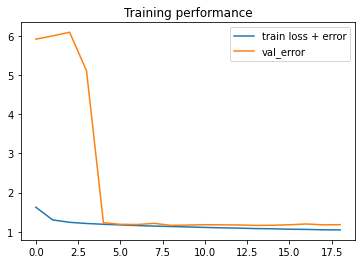

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

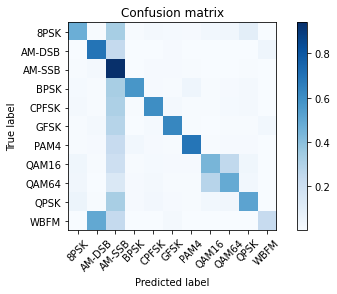

In [15]:
evaluationlib.plot_confusion_matrix(model, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08432392273402675


Overall Accuracy:  0.09390018484288355


Overall Accuracy:  0.09367267585719335


Overall Accuracy:  0.12052002810962754


Overall Accuracy:  0.15245664739884393


Overall Accuracy:  0.22627998567848193


Overall Accuracy:  0.3511286277319957


Overall Accuracy:  0.48255813953488375


Overall Accuracy:  0.5892793752218672


Overall Accuracy:  0.716391085549964


Overall Accuracy:  0.7904865649963689


Overall Accuracy:  0.8359177785791562


Overall Accuracy:  0.8550284629981024


Overall Accuracy:  0.8548507462686568


Overall Accuracy:  0.8631123919308358


Overall Accuracy:  0.8705796573095151


Overall Accuracy:  0.8615327656423547


Overall Accuracy:  0.8582173749529899


Overall Accuracy:  0.8618275607958733


Overall Accuracy:  0.8526881720430107


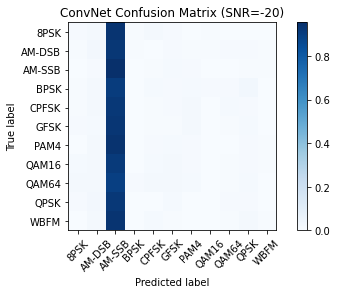

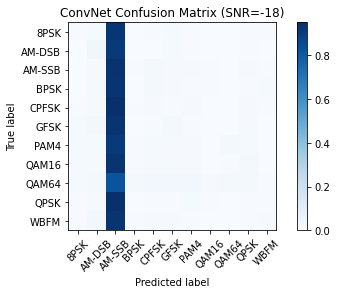

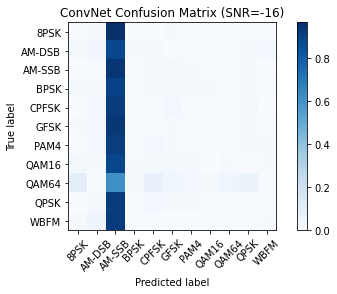

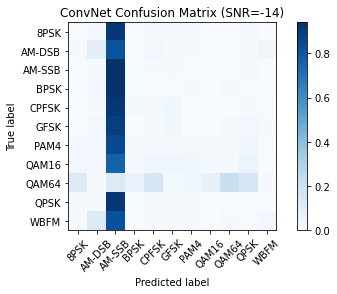

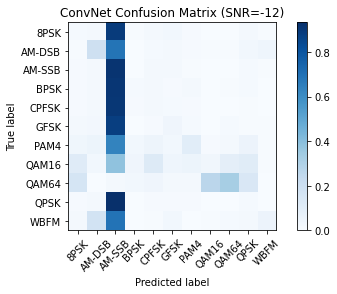

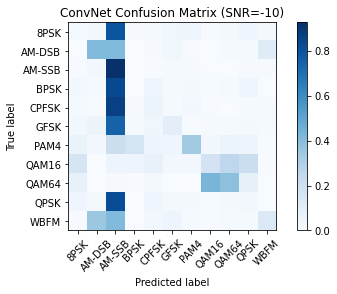

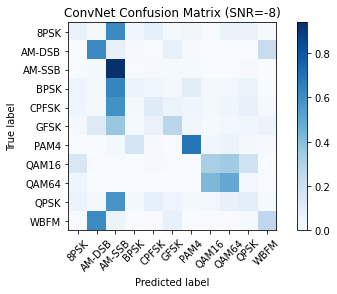

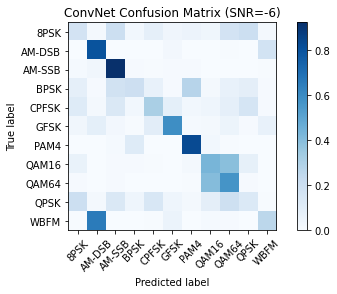

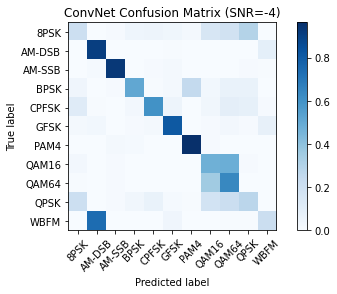

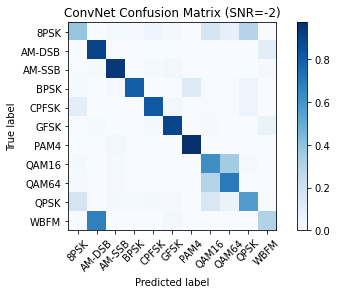

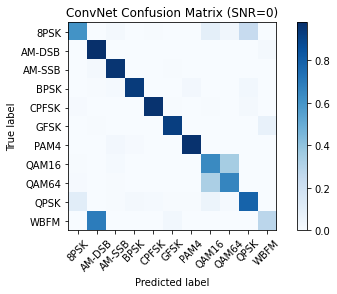

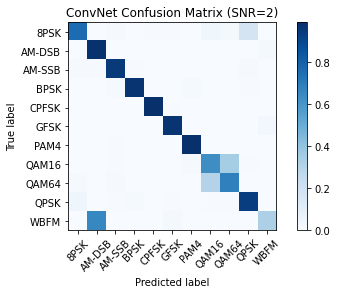

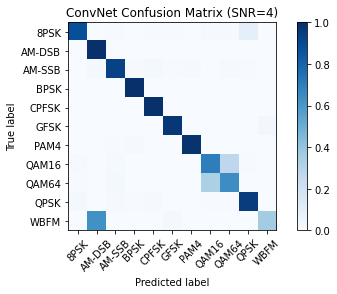

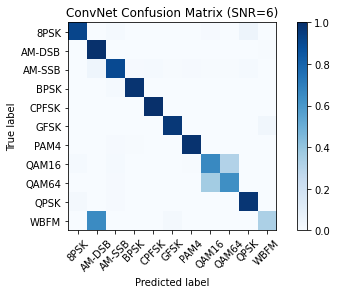

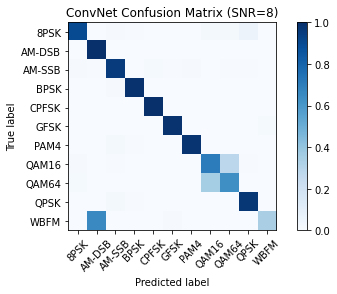

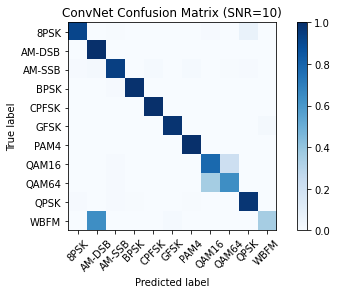

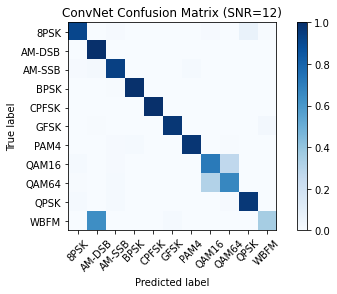

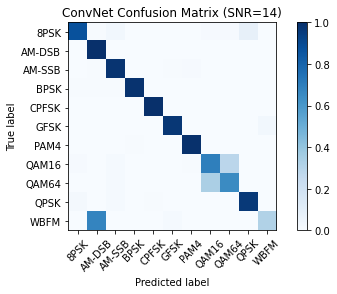

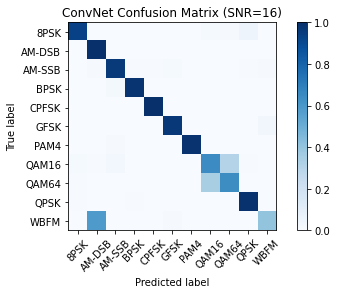

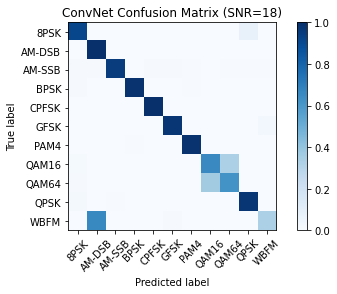

In [16]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [17]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,12,15,22,35,48,58,71,79,83,85,85,86,87,86,85,86,85


In [18]:
# Save results to a pickle file for plotting later
# fd = open(OUTPUT_FILENAME,'wb')
# pickle.dump( ("CNN2", 0.5, acc) , fd )

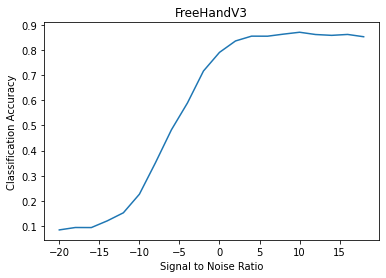

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)